# Pauli-X Operator 

In [2]:
import numpy as np

# Define a 6x6 matrix with your specified elements
measurements_matrix_x = np.array([
    [0, 1, 0.5, 0.5, 0.5, 0.5],  # Row 1
    [1, 0, 0.5, 0.5, 0.5, 0.5],  # Row 2
    [0.5, 0.5, 1, 0, 0.5, 0.5],  # Row 3
    [0.5, 0.5, 0, 1, 0.5, 0.5],  # Row 4
    [0.5, 0.5, 0.5, 0.5, 0, 1],  # Row 5
    [0.5, 0.5, 0.5, 0.5, 1, 0]   # Row 6
])

# Print the matrix
print("6x6 Matrix:")
print(measurements_matrix_x)


6x6 Matrix:
[[0.  1.  0.5 0.5 0.5 0.5]
 [1.  0.  0.5 0.5 0.5 0.5]
 [0.5 0.5 1.  0.  0.5 0.5]
 [0.5 0.5 0.  1.  0.5 0.5]
 [0.5 0.5 0.5 0.5 0.  1. ]
 [0.5 0.5 0.5 0.5 1.  0. ]]


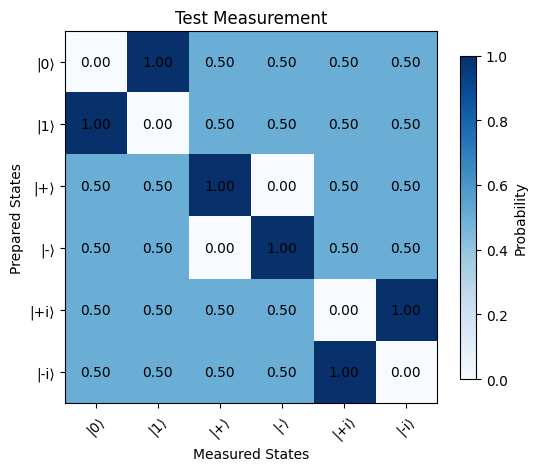

In [3]:
import numpy as np
import matplotlib.pyplot as plt


# Convert matrix to numpy array
Tomographic_measurements = measurements_matrix_x

# Define the state labels
state_labels = ['|0⟩', '|1⟩', '|+⟩', '|-⟩', '|+i⟩', '|-i⟩']

# Create the plot
fig, ax = plt.subplots(figsize=(6, 6))
heatmap = ax.imshow(Tomographic_measurements, cmap='Blues', interpolation='nearest')
ax.set_title('Test Measurement')
ax.set_xticks(np.arange(len(state_labels)))
ax.set_yticks(np.arange(len(state_labels)))
ax.set_xticklabels(state_labels, rotation=45)
ax.set_yticklabels(state_labels)
ax.set_xlabel('Measured States')
ax.set_ylabel('Prepared States')

# Add text annotations
for i in range(Tomographic_measurements.shape[0]):
    for j in range(Tomographic_measurements.shape[1]):
        value = Tomographic_measurements[i, j]
        ax.text(j, i, f'{value:.2f}', ha='center', va='center', color='black')

# Add color bar
plt.colorbar(heatmap, ax=ax, label='Probability', shrink=0.7)

# Save the plot
plt.savefig('Test_Measurements_Heatmap_x.png',dpi=100)

# Show the plot
plt.show()


Cost Function Evaluation

In [5]:
from qiskit import QuantumCircuit, transpile
from qiskit.circuit import Parameter
from qiskit_aer import AerSimulator
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# Define the reference circuits for each state
def create_reference_circuits():
    circuits = []

    # |0⟩ state
    qc_0 = QuantumCircuit(1)
    qc_0.ry(0, 0)
    qc_0.rz(0, 0)
    circuits.append(qc_0)

    # |1⟩ state
    qc_1 = QuantumCircuit(1)
    qc_1.ry(np.pi, 0)
    qc_1.rz(0, 0)
    circuits.append(qc_1)

    # |+⟩ state
    qc_plus = QuantumCircuit(1)
    qc_plus.ry(np.pi/2, 0)
    qc_plus.rz(0, 0)
    circuits.append(qc_plus)

    # |−⟩ state
    qc_minus = QuantumCircuit(1)
    qc_minus.ry(-np.pi/2, 0)  
    qc_minus.rz(0, 0)
    circuits.append(qc_minus)

    # |+i⟩ state
    qc_plus_i = QuantumCircuit(1)
    qc_plus_i.ry(np.pi/2, 0)
    qc_plus_i.rz(np.pi/2, 0)
    circuits.append(qc_plus_i)

    # |-i⟩ state
    qc_minus_i = QuantumCircuit(1)
    qc_minus_i.ry(-np.pi/2, 0)
    qc_minus_i.rz(np.pi/2, 0)
    circuits.append(qc_minus_i)

    return circuits

# Define parameters for the variational circuit
theta = Parameter('θ')
phi = Parameter('φ')
Lambda = Parameter('λ')

# Create a variational circuit
variational_circuit = QuantumCircuit(1)
variational_circuit.rz(Lambda, 0)
variational_circuit.ry(theta, 0)
variational_circuit.rz(phi, 0)

# Function to combine reference and variational circuits
def combine_circuits(reference_circuit, variational_circuit, params):
    combined_circuit = reference_circuit.compose(variational_circuit, inplace=False)
    combined_circuit = combined_circuit.assign_parameters(params)
    return combined_circuit

# Run the circuit and return probabilities
def get_probabilities(circuit, basis):
    simulator = AerSimulator()
    compiled_circuit = transpile(circuit, simulator)
    result = simulator.run(compiled_circuit, shots=1000).result()
    counts = result.get_counts()

    # Define state labels for each basis
    state_labels = {
        'z': {'0': '|0⟩', '1': '|1⟩'},
        'x': {'0': '|+⟩', '1': '|-⟩'},
        'y': {'0': '|+i⟩', '1': '|-i⟩'}
    }

    # Map counts to state labels
    labeled_counts = {state_labels[basis].get(k, k): v for k, v in counts.items()}
    total_shots = sum(labeled_counts.values())
    probabilities = {state: count / total_shots for state, count in labeled_counts.items()}

    return probabilities

# Measure circuit in different bases
def measure_circuit(circuit, basis):
    if basis == 'z':
        circuit.measure_all()
    elif basis == 'x':
        circuit.h(0)
        circuit.measure_all()
    elif basis == 'y':
        circuit.rx(np.pi / 2, 0)
        circuit.measure_all()
    else:
        raise ValueError("Basis must be one of 'z', 'x', or 'y'")
    return circuit

# Cost function across all reference states
def cost_function(params, target_measurements, callback=None):
    reference_circuits = create_reference_circuits()

    total_cost = 0  # Initialize total cost

    for i, reference_circuit in enumerate(reference_circuits):
        circuit = combine_circuits(reference_circuit, variational_circuit, params)
        
        # Measure in each basis and get probabilities
        prob_z = get_probabilities(measure_circuit(circuit.copy(), 'z'), 'z')
        prob_x = get_probabilities(measure_circuit(circuit.copy(), 'x'), 'x')
        prob_y = get_probabilities(measure_circuit(circuit.copy(), 'y'), 'y')

        # Extract probabilities for each basis
        prob_0 = prob_z.get('|0⟩', 0)
        prob_1 = prob_z.get('|1⟩', 0)
        prob_plus = prob_x.get('|+⟩', 0)
        prob_minus = prob_x.get('|-⟩', 0)
        prob_plus_i = prob_y.get('|+i⟩', 0)
        prob_minus_i = prob_y.get('|-i⟩', 0)

        # Combine all probabilities into a single list
        measured_probabilities = [prob_0, prob_1, prob_plus, prob_minus, prob_plus_i, prob_minus_i]

        # Calculate the cost for this reference circuit
        target_probabilities = np.array(target_measurements[i])
        cost = np.sum((measured_probabilities - target_probabilities) ** 2)
        total_cost += cost

    if callback:
        callback(params, total_cost)

    return total_cost

# Bounds constraint functions
def constraint_theta_lower(params):
    return params[0]  - (5*np.pi/6)

def constraint_theta_upper(params):
    return np.pi - params[0]  

def constraint_phi_lower(params):
    return params[1]  - (0)

def constraint_phi_upper(params):
    return np.pi/90 - params[1]  

def constraint_lambda_lower(params):
    return params[2]  - (5*np.pi/6)

def constraint_lambda_upper(params):
    return np.pi - params[2]  

# List of constraints
constraints = [
    {'type': 'ineq', 'fun': constraint_theta_lower},  
    {'type': 'ineq', 'fun': constraint_theta_upper},  
    {'type': 'ineq', 'fun': constraint_phi_lower},    
    {'type': 'ineq', 'fun': constraint_phi_upper},    
    {'type': 'ineq', 'fun': constraint_lambda_lower}, 
    {'type': 'ineq', 'fun': constraint_lambda_upper}   
]

# Initialize lists to store values
iterations = []
cost_values = []

# Callback function to update the lists
def callback_function(params, cost):
    iterations.append(len(iterations))  # Store the iteration number
    cost_values.append(cost)  # Store the cost value

target_measurements_X = measurements_matrix_x 
# Initial guess for parameters within [0, π/2]
initial_params = [5*np.pi/6, np.pi/360, 5*np.pi/6]  

result_x = minimize(cost_function, initial_params, args=(target_measurements_X, callback_function), 
                  method='Nelder-Mead',
                    bounds = [(5*np.pi/6, np.pi), (0, np.pi/90), (5*np.pi/6, np.pi)])
                    #constraints=constraints

# Plotting sections
# Plot and save normal scale plot
plt.figure()
plt.plot(iterations, cost_values, label="Cost Function (Normal Scale)")
plt.xlabel('Iteration')
plt.ylabel('Cost Function')
plt.title('Normal Scale Cost Function for Pauli-X operator')
plt.legend()
plt.savefig(' Nelder normal_scale_cost_function_plot.png')
plt.close()

# Plot and save log scale plot
plt.figure()
plt.plot(iterations, cost_values, label="Cost Function (Log Scale)")
plt.xlabel('Iteration')
plt.ylabel('Cost Function')
plt.title('Log Scale Cost Function for Pauli-X operator')
plt.yscale('log')
plt.legend()
plt.savefig('Nelder log_scale_cost_function_plot.png')
plt.close()

# Optimal parameters and cost
optimal_params_x = result_x.x
optimal_cost_x = result_x.fun
print("Optimal Parameters:", optimal_params_x)
print("Optimal Cost:", optimal_cost_x)

theta_opt_x, phi_opt_x, Lambda_opt_x = result_x.x
print(f"theta: {theta_opt_x}")
print(f"phi: {phi_opt_x}")
print(f"Lambda:{Lambda_opt_x}")


Optimal Parameters: [3.118564   0.00536447 3.13351243]
Optimal Cost: 0.0019540000000000035
theta: 3.1185640037370916
phi: 0.005364473357067161
Lambda:3.1335124255713


In [6]:
from qiskit import QuantumCircuit, transpile
from qiskit.circuit import Parameter
from qiskit_aer import AerSimulator
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# Define the reference circuits for each state
def create_reference_circuits_x1():
    circuits = []

    # |0⟩ state
    qc_0 = QuantumCircuit(1)
    qc_0.ry(0, 0)
    qc_0.rz(0, 0)
    circuits.append(qc_0)

    # |1⟩ state
    qc_1 = QuantumCircuit(1)
    qc_1.ry(np.pi, 0)
    qc_1.rz(0, 0)
    circuits.append(qc_1)

    # |+⟩ state
    qc_plus = QuantumCircuit(1)
    qc_plus.ry(np.pi/2, 0)
    qc_plus.rz(0, 0)
    circuits.append(qc_plus)

    # |−⟩ state
    qc_minus = QuantumCircuit(1)
    qc_minus.ry(-np.pi/2, 0)  
    qc_minus.rz(0, 0)
    circuits.append(qc_minus)

    # |+i⟩ state
    qc_plus_i = QuantumCircuit(1)
    qc_plus_i.ry(np.pi/2, 0)
    qc_plus_i.rz(np.pi/2, 0)
    circuits.append(qc_plus_i)

    # |-i⟩ state
    qc_minus_i = QuantumCircuit(1)
    qc_minus_i.ry(-np.pi/2, 0)
    qc_minus_i.rz(np.pi/2, 0)
    circuits.append(qc_minus_i)

    return circuits

# Define parameters for the variational circuit
theta_x1 = Parameter('θ')
phi_x1 = Parameter('φ')
Lambda_x1 = Parameter('λ')

# Create a variational circuit
variational_circuit_x1 = QuantumCircuit(1)
variational_circuit_x1.rz(Lambda_x1, 0)
variational_circuit_x1.ry(theta_x1, 0)
variational_circuit_x1.rz(phi_x1, 0)

# Function to combine reference and variational circuits
def combine_circuits_x1(reference_circuit, variational_circuit_x1, params):
    combined_circuit = reference_circuit.compose(variational_circuit, inplace=False)
    combined_circuit = combined_circuit.assign_parameters(params)
    return combined_circuit

# Run the circuit and return probabilities
def get_probabilities_x1(circuit, basis):
    simulator = AerSimulator()
    compiled_circuit = transpile(circuit, simulator)
    result = simulator.run(compiled_circuit, shots=10000).result()
    counts = result.get_counts()

    # Define state labels for each basis
    state_labels = {
        'z': {'0': '|0⟩', '1': '|1⟩'},
        'x': {'0': '|+⟩', '1': '|-⟩'},
        'y': {'0': '|+i⟩', '1': '|-i⟩'}
    }

    # Map counts to state labels
    labeled_counts = {state_labels[basis].get(k, k): v for k, v in counts.items()}
    total_shots = sum(labeled_counts.values())
    probabilities = {state: count / total_shots for state, count in labeled_counts.items()}

    return probabilities

# Measure circuit in different bases
def measure_circuit_x1(circuit, basis):
    if basis == 'z':
        circuit.measure_all()
    elif basis == 'x':
        circuit.h(0)
        circuit.measure_all()
    elif basis == 'y':
        circuit.rx(np.pi / 2, 0)
        circuit.measure_all()
    else:
        raise ValueError("Basis must be one of 'z', 'x', or 'y'")
    return circuit

# Cost function across all reference states
def cost_function_x1(params, target_measurements, callback=None):
    reference_circuits = create_reference_circuits_x1()

    total_cost = 0  # Initialize total cost

    for i, reference_circuit in enumerate(reference_circuits):
        circuit = combine_circuits_x1(reference_circuit, variational_circuit, params)
        
        # Measure in each basis and get probabilities
        prob_z = get_probabilities_x1(measure_circuit_x1(circuit.copy(), 'z'), 'z')
        prob_x = get_probabilities_x1(measure_circuit_x1(circuit.copy(), 'x'), 'x')
        prob_y = get_probabilities_x1(measure_circuit_x1(circuit.copy(), 'y'), 'y')

        # Extract probabilities for each basis
        prob_0 = prob_z.get('|0⟩', 0)
        prob_1 = prob_z.get('|1⟩', 0)
        prob_plus = prob_x.get('|+⟩', 0)
        prob_minus = prob_x.get('|-⟩', 0)
        prob_plus_i = prob_y.get('|+i⟩', 0)
        prob_minus_i = prob_y.get('|-i⟩', 0)

        # Combine all probabilities into a single list
        measured_probabilities_x1 = [prob_0, prob_1, prob_plus, prob_minus, prob_plus_i, prob_minus_i]

        # Calculate the cost for this reference circuit
        target_probabilities = np.array(target_measurements_X1[i])
        cost = np.sum((measured_probabilities_x1 - target_probabilities) ** 2)
        total_cost += cost

    if callback:
        callback(params, total_cost)

    return total_cost

# Bounds constraint functions
def constraint_theta_lower(params):
    return params[0]  - (5*np.pi/6)

def constraint_theta_upper(params):
    return np.pi - params[0]  

def constraint_phi_lower(params):
    return params[1]  - (0)

def constraint_phi_upper(params):
    return np.pi/90 - params[1]  

def constraint_lambda_lower(params):
    return params[2]  - (5*np.pi/6)

def constraint_lambda_upper(params):
    return np.pi - params[2]  

# List of constraints
constraints = [
    {'type': 'ineq', 'fun': constraint_theta_lower},  
    {'type': 'ineq', 'fun': constraint_theta_upper},  
    {'type': 'ineq', 'fun': constraint_phi_lower},    
    {'type': 'ineq', 'fun': constraint_phi_upper},    
    {'type': 'ineq', 'fun': constraint_lambda_lower}, 
    {'type': 'ineq', 'fun': constraint_lambda_upper}   
]

# Initialize lists to store values
iterations = []
cost_values = []

# Callback function to update the lists
def callback_function(params, cost):
    iterations.append(len(iterations))  # Store the iteration number
    cost_values.append(cost)  # Store the cost value

target_measurements_X1 = measurements_matrix_x 
# Initial guess for parameters within [0, π/2]
initial_params = [5*np.pi/6, np.pi/360, 5*np.pi/6]  

result_x1 = minimize(cost_function_x1, initial_params, args=(target_measurements_X1, callback_function), 
                  method='Nelder-Mead',
                  bounds = [(5*np.pi/6, np.pi), (0, np.pi/90), (5*np.pi/6, np.pi)]
                #constraints=constraints
)

# Plotting sections
# Plot and save normal scale plot
plt.figure()
plt.plot(iterations, cost_values, label="Cost Function (Normal Scale)")
plt.xlabel('Iteration')
plt.ylabel('Cost Function')
plt.title('Normal Scale Cost Function for Pauli-X operator')
plt.legend()
plt.savefig(' 10K normal_scale_cost_function_plot.png')
plt.close()

# Plot and save log scale plot
plt.figure()
plt.plot(iterations, cost_values, label="Cost Function (Log Scale)")
plt.xlabel('Iteration')
plt.ylabel('Cost Function')
plt.title('Log Scale Cost Function for Pauli-X operator')
plt.yscale('log')
plt.legend()
plt.savefig('10K log_scale_cost_function_plot.png')
plt.close()

# Optimal parameters and cost
optimal_params_x1 = result_x1.x
optimal_cost_x1 = result_x1.fun
print("Optimal Parameters:", optimal_params_x1)
print("Optimal Cost:", optimal_cost_x1)

theta_opt_x1, phi_opt_x1, Lambda_opt_x1 = result_x1.x
print(f"theta: {theta_opt_x1}")
print(f"phi: {phi_opt_x1}")
print(f"Lambda:{Lambda_opt_x1}")


Optimal Parameters: [3.14159265e+00 2.51039206e-03 3.14159265e+00]
Optimal Cost: 3.2559999999999675e-05
theta: 3.141592653589793
phi: 0.002510392063987554
Lambda:3.141592653589793


In [7]:
import numpy as np

def rotation_matrix(theta, phi, lambda_):
    """
    Returns the universal rotation matrix for a single qubit using the given theta, phi, and lambda.
    """
    return np.array([
        [np.cos(theta / 2), -np.exp(1j * lambda_) * np.sin(theta / 2)],
        [np.exp(1j * phi) * np.sin(theta / 2), np.exp(1j * (lambda_ + phi)) * np.cos(theta / 2)]
    ])


# Generate the rotation matrix
rotation_matrix_result_x = rotation_matrix(theta_opt_x, phi_opt_x, Lambda_opt_x)
rotation_matrix_result_x1 = rotation_matrix(theta_opt_x1, phi_opt_x1, Lambda_opt_x1)
# Print the resulting rotation matrix
print("\nUnitary Matrix, U:")
print(rotation_matrix_result_x)
print("\nUnitary Matrix, U_1:")
print(rotation_matrix_result_x1)


Unitary Matrix, U:
[[ 0.01151407+0.00000000e+00j  0.99990107-8.07960447e-03j]
 [ 0.99991932+5.36409202e-03j -0.01151403+3.12693522e-05j]]

Unitary Matrix, U_1:
[[ 6.12323400e-17+0.00000000e+00j  1.00000000e+00-1.22464680e-16j]
 [ 9.99996849e-01+2.51038943e-03j -6.12321470e-17-1.53717019e-19j]]


Visual Representation of the Unitary Operator 1000k

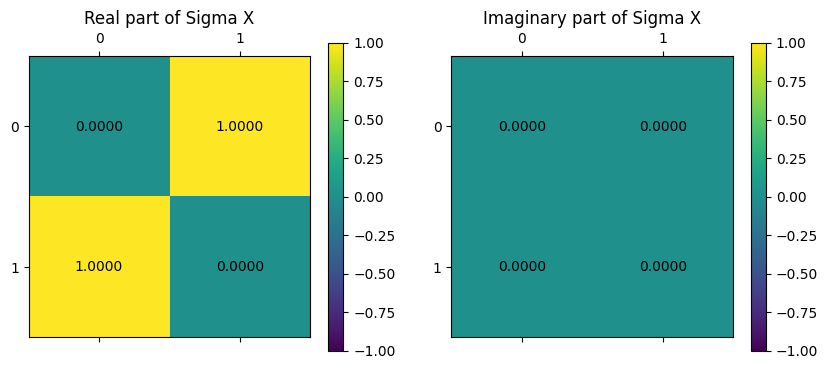

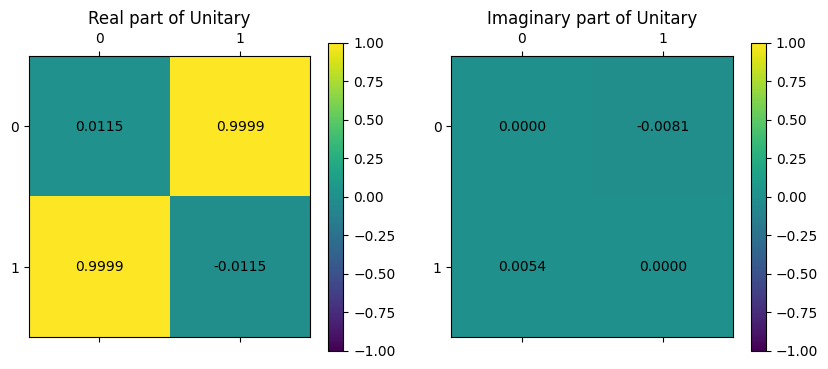

In [9]:
sigma_X = np.array([[0, 1], [1, 0]])
Unitary_x = np.array(rotation_matrix_result_x)

def plot_matrix(matrix, title, vmin=0, vmax=1):
    fig, ax = plt.subplots(1, 2, figsize=(10, 4))
    
    # Real part
    cax1 = ax[0].matshow(matrix.real, cmap='viridis', vmin=vmin, vmax=vmax)
    fig.colorbar(cax1, ax=ax[0])
    ax[0].set_title(f'Real part of {title}')
    
    # Add values to the real part heatmap
    for (i, j), val in np.ndenumerate(matrix.real):
        ax[0].text(j, i, f'{val:.4f}', ha='center', va='center', color='black')
    
    # Imaginary part
    cax2 = ax[1].matshow(matrix.imag, cmap='viridis', vmin=vmin, vmax=vmax)
    fig.colorbar(cax2, ax=ax[1])
    ax[1].set_title(f'Imaginary part of {title}')
    
    # Add values to the imaginary part heatmap
    for (i, j), val in np.ndenumerate(matrix.imag):
        ax[1].text(j, i, f'{val:.4f}', ha='center', va='center', color='black')
     
    plt.show()

# Plot with the desired color map limits (0 to 1)
plot_matrix(sigma_X, 'Sigma X', vmin=-1, vmax=1)
plot_matrix(Unitary_x, 'Unitary', vmin=-1, vmax=1)


Visual Representation of Unitary Operator 10k

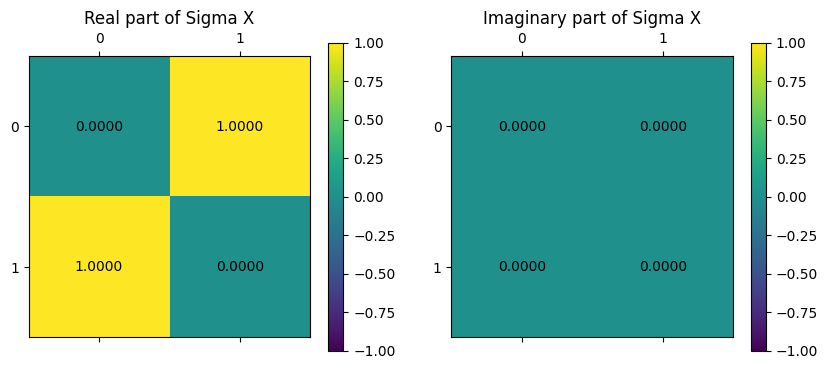

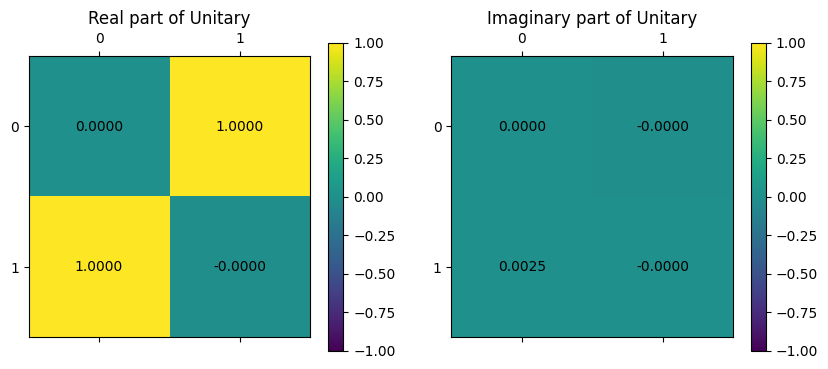

In [11]:
sigma_X = np.array([[0, 1], [1, 0]])
Unitary_x1 = np.array(rotation_matrix_result_x1)
#Unitary_x1 = np.array ([[0, 1], [1, 0]])
def plot_matrix(matrix, title, vmin=0, vmax=1):
    fig, ax = plt.subplots(1, 2, figsize=(10, 4))
    
    # Real part
    cax1 = ax[0].matshow(matrix.real, cmap='viridis', vmin=vmin, vmax=vmax)
    fig.colorbar(cax1, ax=ax[0])
    ax[0].set_title(f'Real part of {title}')
    
    # Add values to the real part heatmap
    for (i, j), val in np.ndenumerate(matrix.real):
        ax[0].text(j, i, f'{val:.4f}', ha='center', va='center', color='black')
    
    # Imaginary part
    cax2 = ax[1].matshow(matrix.imag, cmap='viridis', vmin=vmin, vmax=vmax)
    fig.colorbar(cax2, ax=ax[1])
    ax[1].set_title(f'Imaginary part of {title}')
    
    # Add values to the imaginary part heatmap
    for (i, j), val in np.ndenumerate(matrix.imag):
        ax[1].text(j, i, f'{val:.4f}', ha='center', va='center', color='black')
     
    plt.show()

# Plot with the desired color map limits (0 to 1)
plot_matrix(sigma_X, 'Sigma X', vmin=-1, vmax=1)
plot_matrix(Unitary_x1, 'Unitary', vmin=-1, vmax=1)


Measurement Comparison 1000

In [13]:
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
import numpy as np

# Function to compute Mean Squared Error (MSE) between two matrices (measured and target)
def compute_overall_mse(measured_matrix, target_matrix):
    measured_matrix = np.array(measured_matrix)
    target_matrix = np.array(target_matrix)
    return np.mean((measured_matrix - target_matrix) ** 2)

# Evaluate and store the measured probabilities in a matrix
def evaluate_measurements_matrix(optimal_params, target_measurements):
    reference_circuits = create_reference_circuits()
    measured_probabilities_matrix = []

    for i, reference_circuit in enumerate(reference_circuits):
        # Combine reference and variational circuits with optimal parameters
        circuit = combine_circuits(reference_circuit, variational_circuit, optimal_params)

        # Measure in Z, X, and Y bases
        prob_z = get_probabilities(measure_circuit(circuit.copy(), 'z'), 'z')
        prob_x = get_probabilities(measure_circuit(circuit.copy(), 'x'), 'x')
        prob_y = get_probabilities(measure_circuit(circuit.copy(), 'y'), 'y')

        # Extract probabilities for each basis
        prob_0 = prob_z.get('|0⟩', 0)
        prob_1 = prob_z.get('|1⟩', 0)
        prob_plus = prob_x.get('|+⟩', 0)
        prob_minus = prob_x.get('|-⟩', 0)
        prob_plus_i = prob_y.get('|+i⟩', 0)
        prob_minus_i = prob_y.get('|-i⟩', 0)

        # Combine all probabilities into a single list
        measured_probabilities = [prob_0, prob_1, prob_plus, prob_minus, prob_plus_i, prob_minus_i]

        # Append the list to the measured probabilities matrix
        measured_probabilities_matrix.append(measured_probabilities)

        # Print measured probabilities for clarity
        print(f"Measured Probabilities for reference state {i+1}: {measured_probabilities}")

    # Compute the overall MSE between the entire measured matrix and the target matrix
    overall_mse = compute_overall_mse(measured_probabilities_matrix, target_measurements)

    # Print the measured probability matrix and the overall MSE
    print("\nMeasured Probabilities Matrix:")
    for row in measured_probabilities_matrix:
        print(row)
    
    print(f"\nOverall Mean Squared Error (MSE): {overall_mse}")
    return measured_probabilities_matrix, overall_mse

# Now call the function with optimal_params and target_measurements

# Run the evaluation and get the measured matrix and MSE
measured_matrix, overall_mse = evaluate_measurements_matrix(optimal_params_x, target_measurements_X)



# Lets try to print the matrices

print("The Target Measurements \n")
target_matrix = np.array(target_measurements_X)
print(target_matrix)
print("\n")
print("The Prepared Measurements \n")
Prepared_measurements = np.array(measured_matrix)
np.set_printoptions(linewidth=200)
print(Prepared_measurements)

Measured Probabilities for reference state 1: [0, 1.0, 0.485, 0.515, 0.508, 0.492]
Measured Probabilities for reference state 2: [1.0, 0, 0.505, 0.495, 0.483, 0.517]
Measured Probabilities for reference state 3: [0.471, 0.529, 1.0, 0, 0.527, 0.473]
Measured Probabilities for reference state 4: [0.515, 0.485, 0, 1.0, 0.512, 0.488]
Measured Probabilities for reference state 5: [0.498, 0.502, 0.491, 0.509, 0, 1.0]
Measured Probabilities for reference state 6: [0.473, 0.527, 0.495, 0.505, 1.0, 0]

Measured Probabilities Matrix:
[0, 1.0, 0.485, 0.515, 0.508, 0.492]
[1.0, 0, 0.505, 0.495, 0.483, 0.517]
[0.471, 0.529, 1.0, 0, 0.527, 0.473]
[0.515, 0.485, 0, 1.0, 0.512, 0.488]
[0.498, 0.502, 0.491, 0.509, 0, 1.0]
[0.473, 0.527, 0.495, 0.505, 1.0, 0]

Overall Mean Squared Error (MSE): 0.00018783333333333363
The Target Measurements 

[[0.  1.  0.5 0.5 0.5 0.5]
 [1.  0.  0.5 0.5 0.5 0.5]
 [0.5 0.5 1.  0.  0.5 0.5]
 [0.5 0.5 0.  1.  0.5 0.5]
 [0.5 0.5 0.5 0.5 0.  1. ]
 [0.5 0.5 0.5 0.5 1.  0. ]]



Measurement Comparison 10K

In [15]:
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
import numpy as np

# Function to compute Mean Squared Error (MSE) between two matrices (measured and target)
def compute_overall_mse(measured_matrix, target_matrix):
    measured_matrix = np.array(measured_matrix)
    target_matrix = np.array(target_matrix)
    return np.mean((measured_matrix - target_matrix) ** 2)

# Evaluate and store the measured probabilities in a matrix
def evaluate_measurements_matrix(optimal_params, target_measurements):
    reference_circuits = create_reference_circuits_x1()
    measured_probabilities_matrix = []

    for i, reference_circuit in enumerate(reference_circuits):
        # Combine reference and variational circuits with optimal parameters
        circuit = combine_circuits_x1(reference_circuit, variational_circuit, optimal_params)

        # Measure in Z, X, and Y bases
        prob_z = get_probabilities_x1(measure_circuit_x1(circuit.copy(), 'z'), 'z')
        prob_x = get_probabilities_x1(measure_circuit_x1(circuit.copy(), 'x'), 'x')
        prob_y = get_probabilities_x1(measure_circuit_x1(circuit.copy(), 'y'), 'y')

        # Extract probabilities for each basis
        prob_0 = prob_z.get('|0⟩', 0)
        prob_1 = prob_z.get('|1⟩', 0)
        prob_plus = prob_x.get('|+⟩', 0)
        prob_minus = prob_x.get('|-⟩', 0)
        prob_plus_i = prob_y.get('|+i⟩', 0)
        prob_minus_i = prob_y.get('|-i⟩', 0)

        # Combine all probabilities into a single list
        measured_probabilities = [prob_0, prob_1, prob_plus, prob_minus, prob_plus_i, prob_minus_i]

        # Append the list to the measured probabilities matrix
        measured_probabilities_matrix.append(measured_probabilities)

        # Print measured probabilities for clarity
        print(f"Measured Probabilities for reference state {i+1}: {measured_probabilities}")

    # Compute the overall MSE between the entire measured matrix and the target matrix
    overall_mse = compute_overall_mse(measured_probabilities_matrix, target_measurements)

    # Print the measured probability matrix and the overall MSE
    print("\nMeasured Probabilities Matrix:")
    for row in measured_probabilities_matrix:
        print(row)
    
    print(f"\nOverall Mean Squared Error (MSE): {overall_mse}")
    return measured_probabilities_matrix, overall_mse

# Now call the function with optimal_params and target_measurements

# Run the evaluation and get the measured matrix and MSE
measured_matrix_2, overall_mse = evaluate_measurements_matrix(optimal_params_x1, target_measurements_X1)



# Lets try to print the matrices

print("The Target Measurements \n")
target_matrix_2 = np.array(target_measurements_X1)
print(target_matrix_2)
print("\n")
print("The Prepared Measurements \n")
Prepared_measurements_2 = np.array(measured_matrix_2)
np.set_printoptions(linewidth=200)
print(Prepared_measurements_2)

Measured Probabilities for reference state 1: [0, 1.0, 0.5017, 0.4983, 0.4989, 0.5011]
Measured Probabilities for reference state 2: [1.0, 0, 0.497, 0.503, 0.5045, 0.4955]
Measured Probabilities for reference state 3: [0.4983, 0.5017, 1.0, 0, 0.5012, 0.4988]
Measured Probabilities for reference state 4: [0.4984, 0.5016, 0, 1.0, 0.5016, 0.4984]
Measured Probabilities for reference state 5: [0.5093, 0.4907, 0.4931, 0.5069, 0, 1.0]
Measured Probabilities for reference state 6: [0.5008, 0.4992, 0.5029, 0.4971, 1.0, 0]

Measured Probabilities Matrix:
[0, 1.0, 0.5017, 0.4983, 0.4989, 0.5011]
[1.0, 0, 0.497, 0.503, 0.5045, 0.4955]
[0.4983, 0.5017, 1.0, 0, 0.5012, 0.4988]
[0.4984, 0.5016, 0, 1.0, 0.5016, 0.4984]
[0.5093, 0.4907, 0.4931, 0.5069, 0, 1.0]
[0.5008, 0.4992, 0.5029, 0.4971, 1.0, 0]

Overall Mean Squared Error (MSE): 1.0330555555555543e-05
The Target Measurements 

[[0.  1.  0.5 0.5 0.5 0.5]
 [1.  0.  0.5 0.5 0.5 0.5]
 [0.5 0.5 1.  0.  0.5 0.5]
 [0.5 0.5 0.  1.  0.5 0.5]
 [0.5 0.5 0.

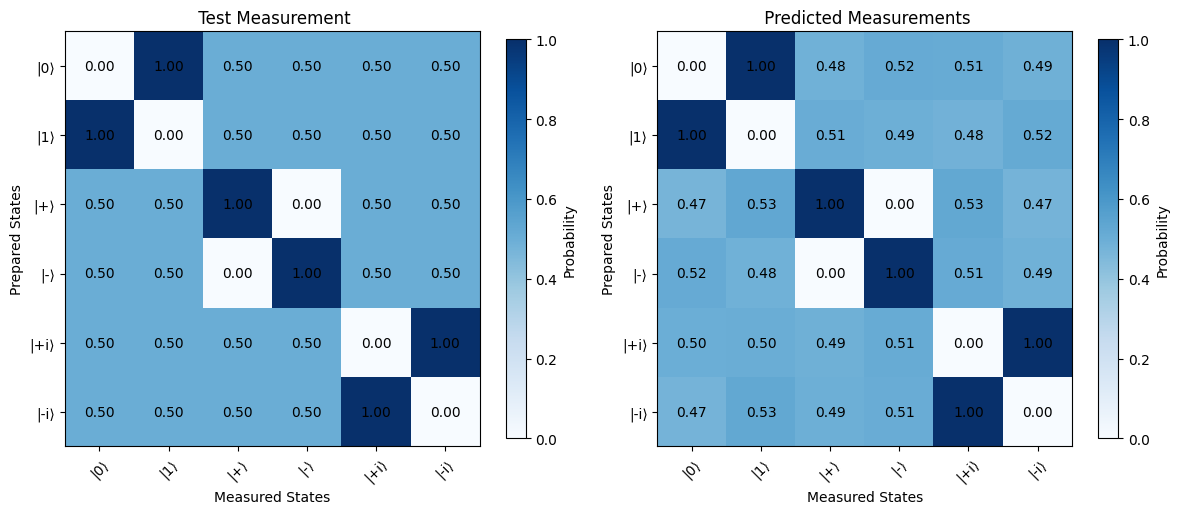

In [16]:
import numpy as np
import matplotlib.pyplot as plt

# Matrices 
Tomographic_measurements = np.array((target_matrix))
Experimental_measurements = np.array((Prepared_measurements))

# Define the state labels
state_labels = ['|0⟩', '|1⟩', '|+⟩', '|-⟩', '|+i⟩', '|-i⟩']

# Create a figure with two subplots (1 row, 2 columns)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot the Target Measurements heatmap on the left
heatmap1 = ax1.imshow(Tomographic_measurements, cmap='Blues', interpolation='nearest')
ax1.set_title(' Test Measurement')
ax1.set_xticks(np.arange(len(state_labels)))
ax1.set_yticks(np.arange(len(state_labels)))
ax1.set_xticklabels(state_labels, rotation=45)
ax1.set_yticklabels(state_labels)
ax1.set_xlabel('Measured States')
ax1.set_ylabel('Prepared States')

# Add text annotations to the target matrix
for i in range(Tomographic_measurements.shape[0]):
    for j in range(Tomographic_measurements.shape[1]):
        value = Tomographic_measurements[i, j]
        ax1.text(j, i, f'{value:.2f}', ha='center', va='center', color='black')

# Add color bar for the target heatmap
fig.colorbar(heatmap1, ax=ax1, label='Probability',shrink= 0.7)

# Plot the Prepared Measurements heatmap on the right
heatmap2 = ax2.imshow(Experimental_measurements, cmap='Blues', interpolation='nearest')
ax2.set_title(' Predicted Measurements')
ax2.set_xticks(np.arange(len(state_labels)))
ax2.set_yticks(np.arange(len(state_labels)))
ax2.set_xticklabels(state_labels, rotation=45)
ax2.set_yticklabels(state_labels)
ax2.set_xlabel('Measured States')
ax2.set_ylabel('Prepared States')

# Add text annotations to the prepared matrix
for i in range(Experimental_measurements.shape[0]):
    for j in range(Experimental_measurements.shape[1]):
        value = Experimental_measurements[i, j]
        ax2.text(j, i, f'{value:.2f}', ha='center', va='center', color='black')

# Add color bar for the prepared heatmap
fig.colorbar(heatmap2, ax=ax2, label='Probability',shrink= 0.7)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

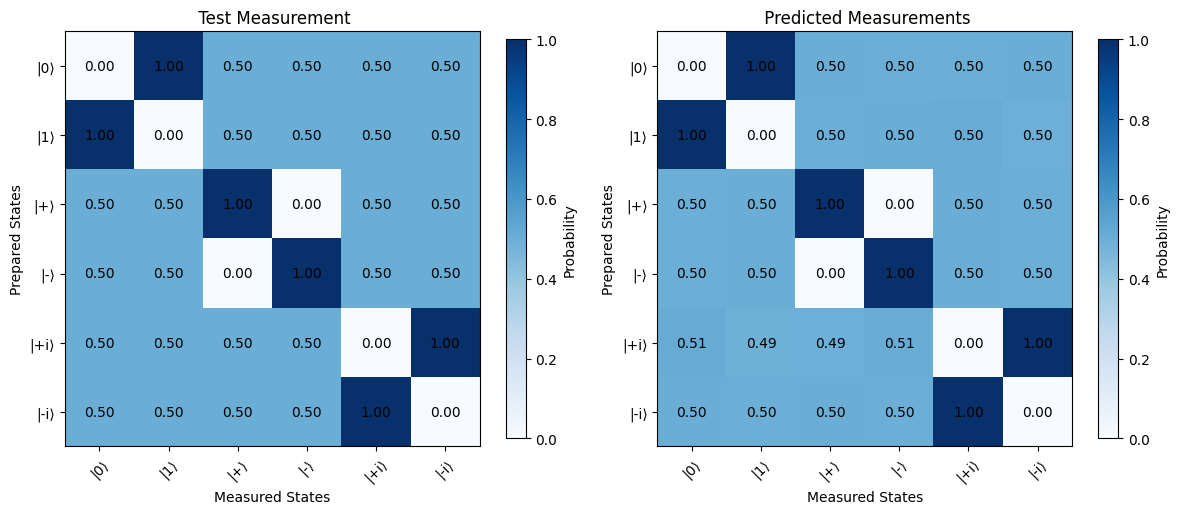

In [17]:
import numpy as np
import matplotlib.pyplot as plt

# Matrices 
Tomographic_measurements = np.array((target_matrix_2))
Experimental_measurements = np.array((Prepared_measurements_2))

# Define the state labels
state_labels = ['|0⟩', '|1⟩', '|+⟩', '|-⟩', '|+i⟩', '|-i⟩']

# Create a figure with two subplots (1 row, 2 columns)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot the Target Measurements heatmap on the left
heatmap1 = ax1.imshow(Tomographic_measurements, cmap='Blues', interpolation='nearest')
ax1.set_title(' Test Measurement')
ax1.set_xticks(np.arange(len(state_labels)))
ax1.set_yticks(np.arange(len(state_labels)))
ax1.set_xticklabels(state_labels, rotation=45)
ax1.set_yticklabels(state_labels)
ax1.set_xlabel('Measured States')
ax1.set_ylabel('Prepared States')

# Add text annotations to the target matrix
for i in range(Tomographic_measurements.shape[0]):
    for j in range(Tomographic_measurements.shape[1]):
        value = Tomographic_measurements[i, j]
        ax1.text(j, i, f'{value:.2f}', ha='center', va='center', color='black')

# Add color bar for the target heatmap
fig.colorbar(heatmap1, ax=ax1, label='Probability',shrink= 0.7)

# Plot the Prepared Measurements heatmap on the right
heatmap2 = ax2.imshow(Experimental_measurements, cmap='Blues', interpolation='nearest')
ax2.set_title(' Predicted Measurements')
ax2.set_xticks(np.arange(len(state_labels)))
ax2.set_yticks(np.arange(len(state_labels)))
ax2.set_xticklabels(state_labels, rotation=45)
ax2.set_yticklabels(state_labels)
ax2.set_xlabel('Measured States')
ax2.set_ylabel('Prepared States')

# Add text annotations to the prepared matrix
for i in range(Experimental_measurements.shape[0]):
    for j in range(Experimental_measurements.shape[1]):
        value = Experimental_measurements[i, j]
        ax2.text(j, i, f'{value:.2f}', ha='center', va='center', color='black')

# Add color bar for the prepared heatmap
fig.colorbar(heatmap2, ax=ax2, label='Probability',shrink= 0.7)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

# Pauli-Y Operator

Collecting Tomographic Measurements

In [136]:
import numpy as np

# Define a 6x6 matrix with your specified elements
measurements_matrix_y = np.array([
    [0, 1, 0.5, 0.5, 0.5, 0.5],  # Row 1
    [1, 0, 0.5, 0.5, 0.5, 0.5],  # Row 2
    [0.5, 0.5, 0, 1, 0.5, 0.5],  # Row 3
    [0.5, 0.5, 1, 0, 0.5, 0.5],  # Row 4
    [0.5, 0.5, 0.5, 0.5, 1, 0],  # Row 5
    [0.5, 0.5, 0.5, 0.5, 0, 1]   # Row 6
])

# Print the matrix
print("6x6 Matrix:")
print(measurements_matrix_y)


6x6 Matrix:
[[0.  1.  0.5 0.5 0.5 0.5]
 [1.  0.  0.5 0.5 0.5 0.5]
 [0.5 0.5 0.  1.  0.5 0.5]
 [0.5 0.5 1.  0.  0.5 0.5]
 [0.5 0.5 0.5 0.5 1.  0. ]
 [0.5 0.5 0.5 0.5 0.  1. ]]


Cost Function Evaluation

In [139]:
from qiskit import QuantumCircuit, transpile
from qiskit.circuit import Parameter
from qiskit_aer import AerSimulator
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# Define the reference circuits for each state
def create_reference_circuits():
    circuits = []

    # |0⟩ state
    qc_0 = QuantumCircuit(1)
    qc_0.ry(0, 0)
    qc_0.rz(0, 0)
    circuits.append(qc_0)

    # |1⟩ state
    qc_1 = QuantumCircuit(1)
    qc_1.ry(np.pi, 0)
    qc_1.rz(0, 0)
    circuits.append(qc_1)

    # |+⟩ state
    qc_plus = QuantumCircuit(1)
    qc_plus.ry(np.pi/2, 0)
    qc_plus.rz(0, 0)
    circuits.append(qc_plus)

    # |−⟩ state
    qc_minus = QuantumCircuit(1)
    qc_minus.ry(-np.pi/2, 0)  
    qc_minus.rz(0, 0)
    circuits.append(qc_minus)

    # |+i⟩ state
    qc_plus_i = QuantumCircuit(1)
    qc_plus_i.ry(np.pi/2, 0)
    qc_plus_i.rz(np.pi/2, 0)
    circuits.append(qc_plus_i)

    # |-i⟩ state
    qc_minus_i = QuantumCircuit(1)
    qc_minus_i.ry(-np.pi/2, 0)
    qc_minus_i.rz(np.pi/2, 0)
    circuits.append(qc_minus_i)

    return circuits

# Define parameters for the variational circuit
theta = Parameter('θ')
phi = Parameter('φ')
Lambda = Parameter('λ')

# Create a variational circuit
variational_circuit = QuantumCircuit(1)
variational_circuit.rz(Lambda, 0)
variational_circuit.ry(theta, 0)
variational_circuit.rz(phi, 0)

# Function to combine reference and variational circuits
def combine_circuits(reference_circuit, variational_circuit, params):
    combined_circuit = reference_circuit.compose(variational_circuit, inplace=False)
    combined_circuit = combined_circuit.assign_parameters(params)
    return combined_circuit

# Run the circuit and return probabilities
def get_probabilities(circuit, basis):
    simulator = AerSimulator()
    compiled_circuit = transpile(circuit, simulator)
    result = simulator.run(compiled_circuit, shots=1000).result()
    counts = result.get_counts()

    # Define state labels for each basis
    state_labels = {
        'z': {'0': '|0⟩', '1': '|1⟩'},
        'x': {'0': '|+⟩', '1': '|-⟩'},
        'y': {'0': '|+i⟩', '1': '|-i⟩'}
    }

    # Map counts to state labels
    labeled_counts = {state_labels[basis].get(k, k): v for k, v in counts.items()}
    total_shots = sum(labeled_counts.values())
    probabilities = {state: count / total_shots for state, count in labeled_counts.items()}

    return probabilities

# Measure circuit in different bases
def measure_circuit(circuit, basis):
    if basis == 'z':
        circuit.measure_all()
    elif basis == 'x':
        circuit.h(0)
        circuit.measure_all()
    elif basis == 'y':
        circuit.rx(np.pi / 2, 0)
        circuit.measure_all()
    else:
        raise ValueError("Basis must be one of 'z', 'x', or 'y'")
    return circuit

# Cost function across all reference states
def cost_function(params, target_measurements, callback=None):
    reference_circuits = create_reference_circuits()

    #total_cost = 0  # Initialize total cost

    for i, reference_circuit in enumerate(reference_circuits):
        circuit = combine_circuits(reference_circuit, variational_circuit, params)
        
        # Measure in each basis and get probabilities
        prob_z = get_probabilities(measure_circuit(circuit.copy(), 'z'), 'z')
        prob_x = get_probabilities(measure_circuit(circuit.copy(), 'x'), 'x')
        prob_y = get_probabilities(measure_circuit(circuit.copy(), 'y'), 'y')

        # Extract probabilities for each basis
        prob_0 = prob_z.get('|0⟩', 0)
        prob_1 = prob_z.get('|1⟩', 0)
        prob_plus = prob_x.get('|+⟩', 0)
        prob_minus = prob_x.get('|-⟩', 0)
        prob_plus_i = prob_y.get('|+i⟩', 0)
        prob_minus_i = prob_y.get('|-i⟩', 0)

        # Combine all probabilities into a single list
        measured_probabilities = [prob_0, prob_1, prob_plus, prob_minus, prob_plus_i, prob_minus_i]

        # Calculate the cost for this reference circuit
        target_probabilities = np.array(target_measurements[i])
        cost = np.sum((measured_probabilities - target_probabilities) ** 2)
        total_cost = cost

    if callback:
        callback(params, total_cost)

    return total_cost


# Callback function to stop optimization if the cost function is less than 0.003
def stopping_callback(params):
    cost = cost_function(params, target_measurements_Y)  # Recalculate the cost function

# Bounds constraint functions
def constraint_theta_lower(params):
    return params[0]  - (5*np.pi/6)

def constraint_theta_upper(params):
    return np.pi - params[0]  

def constraint_phi_lower(params):
    return params[1]  - (4*np.pi/9)

def constraint_phi_upper(params):
    return np.pi/2 - params[1]  

def constraint_lambda_lower(params):
    return params[2]  - (4*np.pi/9)

def constraint_lambda_upper(params):
    return np.pi/2 - params[2]  

# List of constraints
constraints = [
    {'type': 'ineq', 'fun': constraint_theta_lower},  
    {'type': 'ineq', 'fun': constraint_theta_upper},  
    {'type': 'ineq', 'fun': constraint_phi_lower},  
    {'type': 'ineq', 'fun': constraint_phi_upper},    
    {'type': 'ineq', 'fun': constraint_lambda_lower},  
    {'type': 'ineq', 'fun': constraint_lambda_upper}   
]

# Initialize lists to store values
iterations = []
cost_values = []

# Callback function to update the lists
def callback_function(params, cost):
    iterations.append(len(iterations))  # Store the iteration number
    cost_values.append(cost)  # Store the cost value
    #print(f"Parameters: {params}")
    #print(f"Cost: {cost}\n")

target_measurements_Y = measurements_matrix_y
# Initial guess for parameters
initial_params = [5*np.pi/6 , 4*np.pi/9, 4*np.pi/9]  

# Optimize parameters using COBYLA with constraints
result_y = minimize(
    cost_function, 
    initial_params, 
    args=(target_measurements_Y, callback_function), 
    method='Nelder-Mead',
    #constraints= constraints
    bounds = [(5*np.pi/6, np.pi), (4*np.pi/9, np.pi/2), (4*np.pi/9, np.pi/2)]
)

# Plotting sections
# Plot and save normal scale plot
plt.figure()
plt.plot(iterations, cost_values, label="Cost Function (Normal Scale)")
plt.xlabel('Iteration')
plt.ylabel('Cost Function')
plt.title('Normal Scale Cost Function for Pauli-Y operator')
plt.legend()
plt.savefig('Operator_Y 1k Nelder normal_scale_cost_function_plot.png')
plt.close()

# Plot and save log scale plot
plt.figure()
plt.plot(iterations, cost_values, label="Cost Function (Log Scale)")
plt.xlabel('Iteration')
plt.ylabel('Cost Function')
plt.title('Log Scale Cost Function for Pauli-Y operator')
plt.yscale('log')
plt.legend()
plt.savefig('Operator Y 1k Nelder log_scale_cost_function_plot.png')
plt.close()


# Optimal parameters
optimal_params_y = result_y.x
optimal_cost_y = result_y.fun
print("Optimal Parameters:", optimal_params_y)
print("Optimal Cost:", optimal_cost_y)

print("\n\nOptimal Parameters:")
theta_opt_y , phi_opt_y, Lambda_opt_y = result_y.x
print(f"theta: {theta_opt_y}")
print(f"phi: {phi_opt_y}")
print(f"Lambda:{Lambda_opt_y}")


Optimal Parameters: [3.14159265 1.3962634  1.43109018]
Optimal Cost: 6.000000000000009e-06


Optimal Parameters:
theta: 3.141592653589793
phi: 1.3962634015954636
Lambda:1.4310901819141804


In [160]:
from qiskit import QuantumCircuit, transpile
from qiskit.circuit import Parameter
from qiskit_aer import AerSimulator
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# Define the reference circuits for each state
def create_reference_circuits_1():
    circuits = []

    # |0⟩ state
    qc_0 = QuantumCircuit(1)
    qc_0.ry(0, 0)
    qc_0.rz(0, 0)
    circuits.append(qc_0)

    # |1⟩ state
    qc_1 = QuantumCircuit(1)
    qc_1.ry(np.pi, 0)
    qc_1.rz(0, 0)
    circuits.append(qc_1)

    # |+⟩ state
    qc_plus = QuantumCircuit(1)
    qc_plus.ry(np.pi/2, 0)
    qc_plus.rz(0, 0)
    circuits.append(qc_plus)

    # |−⟩ state
    qc_minus = QuantumCircuit(1)
    qc_minus.ry(-np.pi/2, 0)  
    qc_minus.rz(0, 0)
    circuits.append(qc_minus)

    # |+i⟩ state
    qc_plus_i = QuantumCircuit(1)
    qc_plus_i.ry(np.pi/2, 0)
    qc_plus_i.rz(np.pi/2, 0)
    circuits.append(qc_plus_i)

    # |-i⟩ state
    qc_minus_i = QuantumCircuit(1)
    qc_minus_i.ry(-np.pi/2, 0)
    qc_minus_i.rz(np.pi/2, 0)
    circuits.append(qc_minus_i)

    return circuits

# Define parameters for the variational circuit
theta_1 = Parameter('θ')
phi_1 = Parameter('φ')
Lambda_1 = Parameter('λ')

# Create a variational circuit
variational_circuit_1 = QuantumCircuit(1)
variational_circuit_1.rz(Lambda_1, 0)
variational_circuit_1.ry(theta_1, 0)
variational_circuit_1.rz(phi_1, 0)

# Function to combine reference and variational circuits
def combine_circuits_1(reference_circuit, variational_circuit, params):
    combined_circuit = reference_circuit.compose(variational_circuit, inplace=False)
    combined_circuit = combined_circuit.assign_parameters(params)
    return combined_circuit

# Run the circuit and return probabilities
def get_probabilities_1(circuit, basis):
    simulator = AerSimulator()
    compiled_circuit = transpile(circuit, simulator)
    result = simulator.run(compiled_circuit, shots=10000).result()
    counts = result.get_counts()

    # Define state labels for each basis
    state_labels = {
        'z': {'0': '|0⟩', '1': '|1⟩'},
        'x': {'0': '|+⟩', '1': '|-⟩'},
        'y': {'0': '|+i⟩', '1': '|-i⟩'}
    }

    # Map counts to state labels
    labeled_counts = {state_labels[basis].get(k, k): v for k, v in counts.items()}
    total_shots = sum(labeled_counts.values())
    probabilities = {state: count / total_shots for state, count in labeled_counts.items()}

    return probabilities

# Measure circuit in different bases
def measure_circuit_1(circuit, basis):
    if basis == 'z':
        circuit.measure_all()
    elif basis == 'x':
        circuit.h(0)
        circuit.measure_all()
    elif basis == 'y':
        circuit.rx(np.pi / 2, 0)
        circuit.measure_all()
    else:
        raise ValueError("Basis must be one of 'z', 'x', or 'y'")
    return circuit

# Cost function across all reference states
def cost_function_1(params, target_measurements, callback=None):
    reference_circuits = create_reference_circuits_1()

    #total_cost = 0  # Initialize total cost

    for i, reference_circuit in enumerate(reference_circuits):
        circuit = combine_circuits_1(reference_circuit, variational_circuit_1, params)
        
        # Measure in each basis and get probabilities
        prob_z_1 = get_probabilities_1(measure_circuit_1(circuit.copy(), 'z'), 'z')
        prob_x_1 = get_probabilities_1(measure_circuit_1(circuit.copy(), 'x'), 'x')
        prob_y_1 = get_probabilities_1(measure_circuit_1(circuit.copy(), 'y'), 'y')

        # Extract probabilities for each basis
        prob_0 = prob_z_1.get('|0⟩', 0)
        prob_1 = prob_z_1.get('|1⟩', 0)
        prob_plus = prob_x_1.get('|+⟩', 0)
        prob_minus = prob_x_1.get('|-⟩', 0)
        prob_plus_i = prob_y_1.get('|+i⟩', 0)
        prob_minus_i = prob_y_1.get('|-i⟩', 0)

        # Combine all probabilities into a single list
        measured_probabilities_1 = [prob_0, prob_1, prob_plus, prob_minus, prob_plus_i, prob_minus_i]

        # Calculate the cost for this reference circuit
        target_probabilities = np.array(target_measurements[i])
        cost = np.sum((measured_probabilities_1 - target_probabilities) ** 2)
        total_cost = cost

    if callback:
        callback(params, total_cost)

    return total_cost


# Callback function to stop optimization if the cost function is less than 0.003
def stopping_callback(params):
    cost = cost_function_1(params, target_measurements_Y_1)  # Recalculate the cost function

# Bounds constraint functions
def constraint_theta_lower(params):
    return params[0]  - (5*np.pi/6)

def constraint_theta_upper(params):
    return np.pi - params[0]  

def constraint_phi_lower(params):
    return params[1]  - (4*np.pi/9)

def constraint_phi_upper(params):
    return np.pi/2 - params[1]  

def constraint_lambda_lower(params):
    return params[2]  - (4*np.pi/9)

def constraint_lambda_upper(params):
    return np.pi/2 - params[2]  

# List of constraints
constraints = [
    {'type': 'ineq', 'fun': constraint_theta_lower},  
    {'type': 'ineq', 'fun': constraint_theta_upper},  
    {'type': 'ineq', 'fun': constraint_phi_lower},  
    {'type': 'ineq', 'fun': constraint_phi_upper},    
    {'type': 'ineq', 'fun': constraint_lambda_lower},  
    {'type': 'ineq', 'fun': constraint_lambda_upper}   
]

# Initialize lists to store values
iterations = []
cost_values = []

# Callback function to update the lists
def callback_function(params, cost):
    iterations.append(len(iterations))  # Store the iteration number
    cost_values.append(cost)  # Store the cost value
    #print(f"Parameters: {params}")
    #print(f"Cost: {cost}\n")

target_measurements_Y_1 = measurements_matrix_y
# Initial guess for parameters
initial_params_1 = [5*np.pi/6 , 4*np.pi/9, 4*np.pi/9]  

# Optimize parameters using COBYLA with constraints
result_y_1 = minimize(
    cost_function_1, 
    initial_params_1, 
    args=(target_measurements_Y, callback_function), 
    method='Nelder-Mead',
    #constraints= constraints
    bounds = [(5*np.pi/6, np.pi), (4*np.pi/9, np.pi/2), (4*np.pi/9, np.pi/2)]
)

# Plotting sections
# Plot and save normal scale plot
plt.figure()
plt.plot(iterations, cost_values, label="Cost Function (Normal Scale)")
plt.xlabel('Iteration')
plt.ylabel('Cost Function')
plt.title('Normal Scale Cost Function for Pauli-Y operator')
plt.legend()
plt.savefig('Operator_Y 10k Nelder normal_scale_cost_function_plot.png')
plt.close()

# Plot and save log scale plot
plt.figure()
plt.plot(iterations, cost_values, label="Cost Function (Log Scale)")
plt.xlabel('Iteration')
plt.ylabel('Cost Function')
plt.title('Log Scale Cost Function for Pauli-Y operator')
plt.yscale('log')
plt.legend()
plt.savefig('Operator Y 10k Nelder log_scale_cost_function_plot.png')
plt.close()


# Optimal parameters
optimal_params_y_1 = result_y_1.x
optimal_cost_y_1 = result_y_1.fun
print("Optimal Parameters:", optimal_params_y_1)
print("Optimal Cost:", optimal_cost_y_1)

print("\n\nOptimal Parameters:")
theta_opt_y_1 , phi_opt_y_1, Lambda_opt_y_1 = result_y_1.x
print(f"theta: {theta_opt_y_1}")
print(f"phi: {phi_opt_y_1}")
print(f"Lambda:{Lambda_opt_y_1}")


Optimal Parameters: [3.14159265 1.3962634  1.3962634 ]
Optimal Cost: 1.460000000000067e-06


Optimal Parameters:
theta: 3.141592653589793
phi: 1.3962634015954636
Lambda:1.3962634015954636


Unitary operator

In [162]:
import numpy as np

def rotation_matrix(theta, phi, lambda_):
    """
    Returns the universal rotation matrix for a single qubit using the given theta, phi, and lambda.
    """
    return np.array([
        [np.cos(theta / 2), -np.exp(1j * lambda_) * np.sin(theta / 2)],
        [np.exp(1j * phi) * np.sin(theta / 2), np.exp(1j * (lambda_ + phi)) * np.cos(theta / 2)]
    ])


# Generate the rotation matrix
rotation_matrix_result_y = rotation_matrix(theta_opt_y, phi_opt_y, Lambda_opt_y)
rotation_matrix_result_y1 = rotation_matrix(theta_opt_y_1, phi_opt_y_1, Lambda_opt_y_1)
# Print the resulting rotation matrix
print("\nUnitary Matrix, U:")
print(rotation_matrix_result_y)
print("\nUnitary Matrix, U_1:")
print(rotation_matrix_result_y1)


Unitary Matrix, U:
[[ 6.12323400e-17+0.00000000e+00j -1.39252129e-01-9.90256959e-01j]
 [ 1.73648178e-01+9.84807753e-01j -5.82339057e-17+1.89264811e-17j]]

Unitary Matrix, U_1:
[[ 6.12323400e-17+0.00000000e+00j -1.73648178e-01-9.84807753e-01j]
 [ 1.73648178e-01+9.84807753e-01j -5.75395780e-17+2.09426937e-17j]]


Unitary Visual Representation 1000

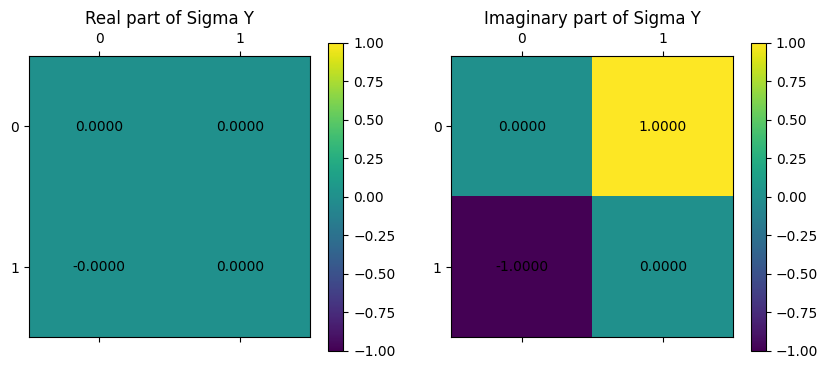

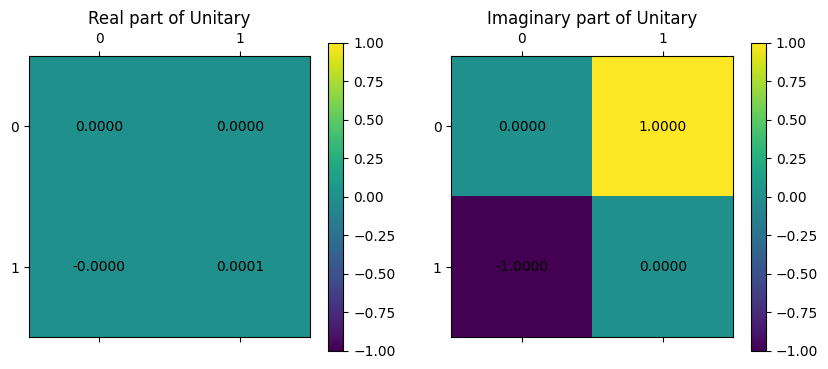

In [177]:
sigma_Y = np.array([[0, 1j], [-1j, 0]])
Unitary_y = np.array(rotation_matrix_result_y)

def plot_matrix(matrix, title, vmin=0, vmax=1):
    fig, ax = plt.subplots(1, 2, figsize=(10, 4))
    
    # Real part
    cax1 = ax[0].matshow(matrix.real, cmap='viridis', vmin=vmin, vmax=vmax)
    fig.colorbar(cax1, ax=ax[0])
    ax[0].set_title(f'Real part of {title}')
    
    # Add values to the real part heatmap
    for (i, j), val in np.ndenumerate(matrix.real):
        ax[0].text(j, i, f'{val:.4f}', ha='center', va='center', color='black')
    
    # Imaginary part
    cax2 = ax[1].matshow(matrix.imag, cmap='viridis', vmin=vmin, vmax=vmax)
    fig.colorbar(cax2, ax=ax[1])
    ax[1].set_title(f'Imaginary part of {title}')
    
    # Add values to the imaginary part heatmap
    for (i, j), val in np.ndenumerate(matrix.imag):
        ax[1].text(j, i, f'{val:.4f}', ha='center', va='center', color='black')
     
    plt.show()

# Plot with the desired color map limits (0 to 1)
plot_matrix(sigma_Y, 'Sigma Y', vmin=-1, vmax=1)
plot_matrix(Unitary_y, 'Unitary', vmin=-1, vmax=1)


Visual Representation 10k

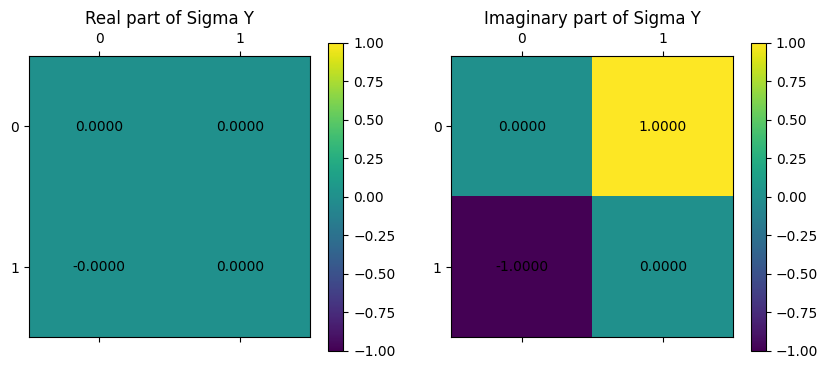

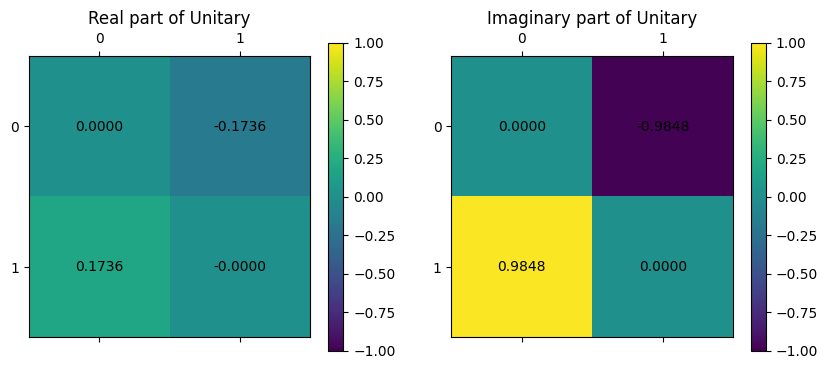

In [166]:
sigma_Y = np.array([[0, 1j], [-1j, 0]])
Unitary_y1 = np.array(rotation_matrix_result_y1)

def plot_matrix(matrix, title, vmin=0, vmax=1):
    fig, ax = plt.subplots(1, 2, figsize=(10, 4))
    
    # Real part
    cax1 = ax[0].matshow(matrix.real, cmap='viridis', vmin=vmin, vmax=vmax)
    fig.colorbar(cax1, ax=ax[0])
    ax[0].set_title(f'Real part of {title}')
    
    # Add values to the real part heatmap
    for (i, j), val in np.ndenumerate(matrix.real):
        ax[0].text(j, i, f'{val:.4f}', ha='center', va='center', color='black')
    
    # Imaginary part
    cax2 = ax[1].matshow(matrix.imag, cmap='viridis', vmin=vmin, vmax=vmax)
    fig.colorbar(cax2, ax=ax[1])
    ax[1].set_title(f'Imaginary part of {title}')
    
    # Add values to the imaginary part heatmap
    for (i, j), val in np.ndenumerate(matrix.imag):
        ax[1].text(j, i, f'{val:.4f}', ha='center', va='center', color='black')
     
    plt.show()

# Plot with the desired color map limits (0 to 1)
plot_matrix(sigma_Y, 'Sigma Y', vmin=-1, vmax=1)
plot_matrix(Unitary_y1, 'Unitary', vmin=-1, vmax=1)


Measurement Comparison 1000

In [148]:
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
import numpy as np

# Function to compute Mean Squared Error (MSE) between two matrices (measured and target)
def compute_overall_mse(measured_matrix, target_matrix):
    measured_matrix = np.array(measured_matrix)
    target_matrix = np.array(target_matrix)
    return np.mean((measured_matrix - target_matrix) ** 2)

# Evaluate and store the measured probabilities in a matrix
def evaluate_measurements_matrix(optimal_params, target_measurements):
    reference_circuits = create_reference_circuits()
    measured_probabilities_matrix = []

    for i, reference_circuit in enumerate(reference_circuits):
        # Combine reference and variational circuits with optimal parameters
        circuit = combine_circuits(reference_circuit, variational_circuit, optimal_params)

        # Measure in Z, X, and Y bases
        prob_z = get_probabilities(measure_circuit(circuit.copy(), 'z'), 'z')
        prob_x = get_probabilities(measure_circuit(circuit.copy(), 'x'), 'x')
        prob_y = get_probabilities(measure_circuit(circuit.copy(), 'y'), 'y')

        # Extract probabilities for each basis
        prob_0 = prob_z.get('|0⟩', 0)
        prob_1 = prob_z.get('|1⟩', 0)
        prob_plus = prob_x.get('|+⟩', 0)
        prob_minus = prob_x.get('|-⟩', 0)
        prob_plus_i = prob_y.get('|+i⟩', 0)
        prob_minus_i = prob_y.get('|-i⟩', 0)

        # Combine all probabilities into a single list
        measured_probabilities = [prob_0, prob_1, prob_plus, prob_minus, prob_plus_i, prob_minus_i]

        # Append the list to the measured probabilities matrix
        measured_probabilities_matrix.append(measured_probabilities)

        # Print measured probabilities for clarity
        print(f"Measured Probabilities for reference state {i+1}: {measured_probabilities}")

    # Compute the overall MSE between the entire measured matrix and the target matrix
    overall_mse = compute_overall_mse(measured_probabilities_matrix, target_measurements)

    # Print the measured probability matrix and the overall MSE
    print("\nMeasured Probabilities Matrix:")
    for row in measured_probabilities_matrix:
        print(row)
    
    print(f"\nOverall Mean Squared Error (MSE): {overall_mse}")
    return measured_probabilities_matrix, overall_mse

# Now call the function with optimal_params and target_measurements

# Run the evaluation and get the measured matrix and MSE
measured_matrix, overall_mse = evaluate_measurements_matrix(optimal_params_y, target_measurements_Y)



# Lets try to print the matrices

print("The Target Measurements \n")
target_matrix = np.array(target_measurements_Y)
print(target_matrix)
print("\n")
print("The Prepared Measurements \n")
Prepared_measurements = np.array(measured_matrix)
np.set_printoptions(linewidth=200)
print(Prepared_measurements)

Measured Probabilities for reference state 1: [0, 1.0, 0.526, 0.474, 0.509, 0.491]
Measured Probabilities for reference state 2: [1.0, 0, 0.51, 0.49, 0.504, 0.496]
Measured Probabilities for reference state 3: [0.536, 0.464, 0, 1.0, 0.466, 0.534]
Measured Probabilities for reference state 4: [0.529, 0.471, 1.0, 0, 0.547, 0.453]
Measured Probabilities for reference state 5: [0.505, 0.495, 0.495, 0.505, 1.0, 0]
Measured Probabilities for reference state 6: [0.482, 0.518, 0.513, 0.487, 0, 1.0]

Measured Probabilities Matrix:
[0, 1.0, 0.526, 0.474, 0.509, 0.491]
[1.0, 0, 0.51, 0.49, 0.504, 0.496]
[0.536, 0.464, 0, 1.0, 0.466, 0.534]
[0.529, 0.471, 1.0, 0, 0.547, 0.453]
[0.505, 0.495, 0.495, 0.505, 1.0, 0]
[0.482, 0.518, 0.513, 0.487, 0, 1.0]

Overall Mean Squared Error (MSE): 0.00038433333333333364
The Target Measurements 

[[0.  1.  0.5 0.5 0.5 0.5]
 [1.  0.  0.5 0.5 0.5 0.5]
 [0.5 0.5 0.  1.  0.5 0.5]
 [0.5 0.5 1.  0.  0.5 0.5]
 [0.5 0.5 0.5 0.5 1.  0. ]
 [0.5 0.5 0.5 0.5 0.  1. ]]


The

Measurement Comparison 10k

In [150]:
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
import numpy as np

# Function to compute Mean Squared Error (MSE) between two matrices (measured and target)
def compute_overall_mse(measured_matrix, target_matrix):
    measured_matrix = np.array(measured_matrix)
    target_matrix = np.array(target_matrix)
    return np.mean((measured_matrix - target_matrix) ** 2)

# Evaluate and store the measured probabilities in a matrix
def evaluate_measurements_matrix(optimal_params, target_measurements):
    reference_circuits = create_reference_circuits()
    measured_probabilities_matrix = []

    for i, reference_circuit in enumerate(reference_circuits):
        # Combine reference and variational circuits with optimal parameters
        circuit = combine_circuits(reference_circuit, variational_circuit, optimal_params)

        # Measure in Z, X, and Y bases
        prob_z = get_probabilities(measure_circuit(circuit.copy(), 'z'), 'z')
        prob_x = get_probabilities(measure_circuit(circuit.copy(), 'x'), 'x')
        prob_y = get_probabilities(measure_circuit(circuit.copy(), 'y'), 'y')

        # Extract probabilities for each basis
        prob_0 = prob_z.get('|0⟩', 0)
        prob_1 = prob_z.get('|1⟩', 0)
        prob_plus = prob_x.get('|+⟩', 0)
        prob_minus = prob_x.get('|-⟩', 0)
        prob_plus_i = prob_y.get('|+i⟩', 0)
        prob_minus_i = prob_y.get('|-i⟩', 0)

        # Combine all probabilities into a single list
        measured_probabilities = [prob_0, prob_1, prob_plus, prob_minus, prob_plus_i, prob_minus_i]

        # Append the list to the measured probabilities matrix
        measured_probabilities_matrix.append(measured_probabilities)

        # Print measured probabilities for clarity
        print(f"Measured Probabilities for reference state {i+1}: {measured_probabilities}")

    # Compute the overall MSE between the entire measured matrix and the target matrix
    overall_mse = compute_overall_mse(measured_probabilities_matrix, target_measurements)

    # Print the measured probability matrix and the overall MSE
    print("\nMeasured Probabilities Matrix:")
    for row in measured_probabilities_matrix:
        print(row)
    
    print(f"\nOverall Mean Squared Error (MSE): {overall_mse}")
    return measured_probabilities_matrix, overall_mse

# Now call the function with optimal_params and target_measurements

# Run the evaluation and get the measured matrix and MSE
measured_matrix, overall_mse = evaluate_measurements_matrix(optimal_params_y_1, target_measurements_Y_1)



# Lets try to print the matrices

print("The Target Measurements \n")
target_matrix = np.array(target_measurements_Y_1)
print(target_matrix)
print("\n")
print("The Prepared Measurements \n")
Prepared_measurements = np.array(measured_matrix)
np.set_printoptions(linewidth=200)
print(Prepared_measurements)

Measured Probabilities for reference state 1: [0, 1.0, 0.503, 0.497, 0.497, 0.503]
Measured Probabilities for reference state 2: [1.0, 0, 0.506, 0.494, 0.5, 0.5]
Measured Probabilities for reference state 3: [0.496, 0.504, 0, 1.0, 0.493, 0.507]
Measured Probabilities for reference state 4: [0.527, 0.473, 1.0, 0, 0.478, 0.522]
Measured Probabilities for reference state 5: [0.474, 0.526, 0.497, 0.503, 1.0, 0]
Measured Probabilities for reference state 6: [0.495, 0.505, 0.483, 0.517, 0, 1.0]

Measured Probabilities Matrix:
[0, 1.0, 0.503, 0.497, 0.497, 0.503]
[1.0, 0, 0.506, 0.494, 0.5, 0.5]
[0.496, 0.504, 0, 1.0, 0.493, 0.507]
[0.527, 0.473, 1.0, 0, 0.478, 0.522]
[0.474, 0.526, 0.497, 0.503, 1.0, 0]
[0.495, 0.505, 0.483, 0.517, 0, 1.0]

Overall Mean Squared Error (MSE): 0.00012950000000000022
The Target Measurements 

[[0.  1.  0.5 0.5 0.5 0.5]
 [1.  0.  0.5 0.5 0.5 0.5]
 [0.5 0.5 0.  1.  0.5 0.5]
 [0.5 0.5 1.  0.  0.5 0.5]
 [0.5 0.5 0.5 0.5 1.  0. ]
 [0.5 0.5 0.5 0.5 0.  1. ]]


The Pre

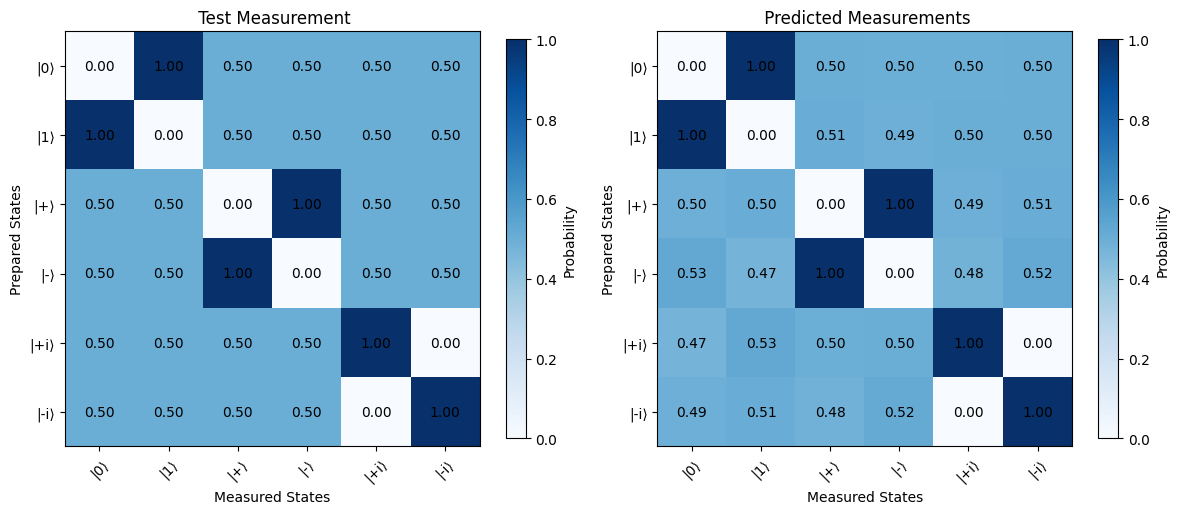

In [151]:
import numpy as np
import matplotlib.pyplot as plt

# Matrices 
Tomographic_measurements = np.array((target_matrix))
Experimental_measurements = np.array((Prepared_measurements))

# Define the state labels
state_labels = ['|0⟩', '|1⟩', '|+⟩', '|-⟩', '|+i⟩', '|-i⟩']

# Create a figure with two subplots (1 row, 2 columns)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot the Target Measurements heatmap on the left
heatmap1 = ax1.imshow(Tomographic_measurements, cmap='Blues', interpolation='nearest')
ax1.set_title(' Test Measurement')
ax1.set_xticks(np.arange(len(state_labels)))
ax1.set_yticks(np.arange(len(state_labels)))
ax1.set_xticklabels(state_labels, rotation=45)
ax1.set_yticklabels(state_labels)
ax1.set_xlabel('Measured States')
ax1.set_ylabel('Prepared States')

# Add text annotations to the target matrix
for i in range(Tomographic_measurements.shape[0]):
    for j in range(Tomographic_measurements.shape[1]):
        value = Tomographic_measurements[i, j]
        ax1.text(j, i, f'{value:.2f}', ha='center', va='center', color='black')

# Add color bar for the target heatmap
fig.colorbar(heatmap1, ax=ax1, label='Probability',shrink= 0.7)

# Plot the Prepared Measurements heatmap on the right
heatmap2 = ax2.imshow(Experimental_measurements, cmap='Blues', interpolation='nearest')
ax2.set_title(' Predicted Measurements')
ax2.set_xticks(np.arange(len(state_labels)))
ax2.set_yticks(np.arange(len(state_labels)))
ax2.set_xticklabels(state_labels, rotation=45)
ax2.set_yticklabels(state_labels)
ax2.set_xlabel('Measured States')
ax2.set_ylabel('Prepared States')

# Add text annotations to the prepared matrix
for i in range(Experimental_measurements.shape[0]):
    for j in range(Experimental_measurements.shape[1]):
        value = Experimental_measurements[i, j]
        ax2.text(j, i, f'{value:.2f}', ha='center', va='center', color='black')

# Add color bar for the prepared heatmap
fig.colorbar(heatmap2, ax=ax2, label='Probability',shrink= 0.7)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

# Pauli-Z Operator

In [36]:
import numpy as np

# Define a 6x6 matrix with your specified elements
measurements_matrix_z = np.array([
    [1, 0, 0.5, 0.5, 0.5, 0.5],  # Row 1
    [0, 1, 0.5, 0.5, 0.5, 0.5],  # Row 2
    [0.5, 0.5, 0, 1, 0.5, 0.5],  # Row 3
    [0.5, 0.5, 1, 0, 0.5, 0.5],  # Row 4
    [0.5, 0.5, 0.5, 0.5, 0, 1],  # Row 5
    [0.5, 0.5, 0.5, 0.5, 1, 0]   # Row 6
])

# Print the matrix
print("6x6 Matrix:")
print(measurements_matrix_z)


6x6 Matrix:
[[1.  0.  0.5 0.5 0.5 0.5]
 [0.  1.  0.5 0.5 0.5 0.5]
 [0.5 0.5 0.  1.  0.5 0.5]
 [0.5 0.5 1.  0.  0.5 0.5]
 [0.5 0.5 0.5 0.5 0.  1. ]
 [0.5 0.5 0.5 0.5 1.  0. ]]


In [37]:
from qiskit import QuantumCircuit, transpile
from qiskit.circuit import Parameter
from qiskit_aer import AerSimulator
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# Define the reference circuits for each state
def create_reference_circuits():
    circuits = []

    # |0⟩ state
    qc_0 = QuantumCircuit(1)
    qc_0.ry(0, 0)
    qc_0.rz(0, 0)
    circuits.append(qc_0)

    # |1⟩ state
    qc_1 = QuantumCircuit(1)
    qc_1.ry(np.pi, 0)
    qc_1.rz(0, 0)
    circuits.append(qc_1)

    # |+⟩ state
    qc_plus = QuantumCircuit(1)
    qc_plus.ry(np.pi/2, 0)
    qc_plus.rz(0, 0)
    circuits.append(qc_plus)

    # |−⟩ state
    qc_minus = QuantumCircuit(1)
    qc_minus.ry(-np.pi/2, 0)  
    qc_minus.rz(0, 0)
    circuits.append(qc_minus)

    # |+i⟩ state
    qc_plus_i = QuantumCircuit(1)
    qc_plus_i.ry(np.pi/2, 0)
    qc_plus_i.rz(np.pi/2, 0)
    circuits.append(qc_plus_i)

    # |-i⟩ state
    qc_minus_i = QuantumCircuit(1)
    qc_minus_i.ry(-np.pi/2, 0)
    qc_minus_i.rz(np.pi/2, 0)
    circuits.append(qc_minus_i)

    return circuits

# Define parameters for the variational circuit
theta = Parameter('θ')
phi = Parameter('φ')
Lambda = Parameter('λ')

# Create a variational circuit
variational_circuit = QuantumCircuit(1)
variational_circuit.rz(Lambda, 0)
variational_circuit.ry(theta, 0)
variational_circuit.rz(phi, 0)

# Function to combine reference and variational circuits
def combine_circuits(reference_circuit, variational_circuit, params):
    combined_circuit = reference_circuit.compose(variational_circuit, inplace=False)
    combined_circuit = combined_circuit.assign_parameters(params)
    return combined_circuit

# Run the circuit and return probabilities
def get_probabilities(circuit, basis):
    simulator = AerSimulator()
    compiled_circuit = transpile(circuit, simulator)
    result = simulator.run(compiled_circuit, shots=1000).result()
    counts = result.get_counts()

    # Define state labels for each basis
    state_labels = {
        'z': {'0': '|0⟩', '1': '|1⟩'},
        'x': {'0': '|+⟩', '1': '|-⟩'},
        'y': {'0': '|+i⟩', '1': '|-i⟩'}
    }

    # Map counts to state labels
    labeled_counts = {state_labels[basis].get(k, k): v for k, v in counts.items()}
    total_shots = sum(labeled_counts.values())
    probabilities = {state: count / total_shots for state, count in labeled_counts.items()}

    return probabilities

# Measure circuit in different bases
def measure_circuit(circuit, basis):
    if basis == 'z':
        circuit.measure_all()
    elif basis == 'x':
        circuit.h(0)
        circuit.measure_all()
    elif basis == 'y':
        circuit.rx(np.pi / 2, 0)
        circuit.measure_all()
    else:
        raise ValueError("Basis must be one of 'z', 'x', or 'y'")
    return circuit

# Cost function across all reference states
def cost_function(params, target_measurements, callback=None):
    reference_circuits = create_reference_circuits()

    #total_cost = 0  # Initialize total cost

    for i, reference_circuit in enumerate(reference_circuits):
        circuit = combine_circuits(reference_circuit, variational_circuit, params)
        
        # Measure in each basis and get probabilities
        prob_z = get_probabilities(measure_circuit(circuit.copy(), 'z'), 'z')
        prob_x = get_probabilities(measure_circuit(circuit.copy(), 'x'), 'x')
        prob_y = get_probabilities(measure_circuit(circuit.copy(), 'y'), 'y')

        # Extract probabilities for each basis
        prob_0 = prob_z.get('|0⟩', 0)
        prob_1 = prob_z.get('|1⟩', 0)
        prob_plus = prob_x.get('|+⟩', 0)
        prob_minus = prob_x.get('|-⟩', 0)
        prob_plus_i = prob_y.get('|+i⟩', 0)
        prob_minus_i = prob_y.get('|-i⟩', 0)

        # Combine all probabilities into a single list
        measured_probabilities = [prob_0, prob_1, prob_plus, prob_minus, prob_plus_i, prob_minus_i]

        # Calculate the cost for this reference circuit
        target_probabilities = np.array(target_measurements[i])
        cost = np.sum((measured_probabilities - target_probabilities) ** 2)
        total_cost = cost

    if callback:
        callback(params, total_cost)

    return total_cost


# Callback function to stop optimization if the cost function is less than 0.003
def stopping_callback(params):
    cost = cost_function(params, target_measurements_Y)  # Recalculate the cost function

# Bounds constraint functions
def constraint_theta_lower(params):
    return params[0] 

def constraint_theta_upper(params):
    return np.pi/18 - params[0]  

def constraint_phi_lower(params):
    return params[1]  - (4*np.pi/9)

def constraint_phi_upper(params):
    return np.pi/2 - params[1]  

def constraint_lambda_lower(params):
    return params[2]  - (4*np.pi/9)

def constraint_lambda_upper(params):
    return np.pi/2 - params[2]  

# List of constraints
constraints = [
    {'type': 'ineq', 'fun': constraint_theta_lower},  
    {'type': 'ineq', 'fun': constraint_theta_upper},  
    {'type': 'ineq', 'fun': constraint_phi_lower},  
    {'type': 'ineq', 'fun': constraint_phi_upper},    
    {'type': 'ineq', 'fun': constraint_lambda_lower},  
    {'type': 'ineq', 'fun': constraint_lambda_upper}   
]

# Initialize lists to store values
iterations = []
cost_values = []

# Callback function to update the lists
def callback_function(params, cost):
    iterations.append(len(iterations))  # Store the iteration number
    cost_values.append(cost)  # Store the cost value
    #print(f"Parameters: {params}")
    #print(f"Cost: {cost}\n")

target_measurements_Z = measurements_matrix_z
# Initial guess for parameters
initial_params = [np.pi/36 , 4*np.pi/9, 4*np.pi/9]  

# Optimize parameters using COBYLA with constraints
result_z = minimize(
    cost_function, 
    initial_params, 
    args=(target_measurements_Z, callback_function), 
    method='COBYLA',
    constraints= constraints
    #bounds = [(0, np.pi/36), (4*np.pi/9, np.pi/2), (4*np.pi/9, np.pi/2)]
)

# Plot the final cost vs iterations after optimization
# Plot and save normal scale plot
plt.figure()
plt.plot(iterations, cost_values, label="Cost Function (Normal Scale)")
plt.xlabel('Iteration')
plt.ylabel('Cost Function')
plt.title('Normal Scale Cost Function for Pauli-Z operator')
plt.legend()
plt.savefig('1000 COBYLA_Z normal_scale_cost_function_plot.png')
plt.close()

# Plot and save log scale plot
plt.figure()
plt.plot(iterations, cost_values, label="Cost Function (Log Scale)")
plt.xlabel('Iteration')
plt.ylabel('Cost Function')
plt.title('Log Scale Cost Function for Pauli-Z operator')
plt.yscale('log')
plt.legend()
plt.savefig('1000 COBYLA_Z log_scale_cost_function_plot.png')
plt.close()
# Optimal parameters
optimal_params_z = result_z.x
optimal_cost_z = result_z.fun
print("Optimal Parameters:", optimal_params_z)
print("Optimal Cost:", optimal_cost_z)

print("\n\nOptimal Parameters:")
theta_opt_z , phi_opt_z, Lambda_opt_z = result_z.x
print(f"theta: {theta_opt_z}")
print(f"phi: {phi_opt_z}")
print(f"Lambda:{Lambda_opt_z}")



Optimal Parameters: [0.04486733 1.57079633 1.57071251]
Optimal Cost: 0.00043600000000000084


Optimal Parameters:
theta: 0.044867328192430236
phi: 1.5707963267948966
Lambda:1.5707125136349278


In [38]:
from qiskit import QuantumCircuit, transpile
from qiskit.circuit import Parameter
from qiskit_aer import AerSimulator
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# Define the reference circuits for each state
def create_reference_circuits_z1():
    circuits = []

    # |0⟩ state
    qc_0 = QuantumCircuit(1)
    qc_0.ry(0, 0)
    qc_0.rz(0, 0)
    circuits.append(qc_0)

    # |1⟩ state
    qc_1 = QuantumCircuit(1)
    qc_1.ry(np.pi, 0)
    qc_1.rz(0, 0)
    circuits.append(qc_1)

    # |+⟩ state
    qc_plus = QuantumCircuit(1)
    qc_plus.ry(np.pi/2, 0)
    qc_plus.rz(0, 0)
    circuits.append(qc_plus)

    # |−⟩ state
    qc_minus = QuantumCircuit(1)
    qc_minus.ry(-np.pi/2, 0)  
    qc_minus.rz(0, 0)
    circuits.append(qc_minus)

    # |+i⟩ state
    qc_plus_i = QuantumCircuit(1)
    qc_plus_i.ry(np.pi/2, 0)
    qc_plus_i.rz(np.pi/2, 0)
    circuits.append(qc_plus_i)

    # |-i⟩ state
    qc_minus_i = QuantumCircuit(1)
    qc_minus_i.ry(-np.pi/2, 0)
    qc_minus_i.rz(np.pi/2, 0)
    circuits.append(qc_minus_i)

    return circuits

# Define parameters for the variational circuit
theta_z1 = Parameter('θ')
phi_z1 = Parameter('φ')
Lambda_z1 = Parameter('λ')

# Create a variational circuit
variational_circuit_z1 = QuantumCircuit(1)
variational_circuit_z1.rz(Lambda_z1, 0)
variational_circuit_z1.ry(theta_z1, 0)
variational_circuit_z1.rz(phi_z1, 0)

# Function to combine reference and variational circuits
def combine_circuits_z1(reference_circuit, variational_circuit_z1, params):
    combined_circuit = reference_circuit.compose(variational_circuit_z1, inplace=False)
    combined_circuit = combined_circuit.assign_parameters(params)
    return combined_circuit

# Run the circuit and return probabilities
def get_probabilities_z1(circuit, basis):
    simulator = AerSimulator()
    compiled_circuit = transpile(circuit, simulator)
    result = simulator.run(compiled_circuit, shots=1000).result()
    counts = result.get_counts()

    # Define state labels for each basis
    state_labels = {
        'z': {'0': '|0⟩', '1': '|1⟩'},
        'x': {'0': '|+⟩', '1': '|-⟩'},
        'y': {'0': '|+i⟩', '1': '|-i⟩'}
    }

    # Map counts to state labels
    labeled_counts = {state_labels[basis].get(k, k): v for k, v in counts.items()}
    total_shots = sum(labeled_counts.values())
    probabilities = {state: count / total_shots for state, count in labeled_counts.items()}

    return probabilities

# Measure circuit in different bases
def measure_circuit_z1(circuit, basis):
    if basis == 'z':
        circuit.measure_all()
    elif basis == 'x':
        circuit.h(0)
        circuit.measure_all()
    elif basis == 'y':
        circuit.rx(np.pi / 2, 0)
        circuit.measure_all()
    else:
        raise ValueError("Basis must be one of 'z', 'x', or 'y'")
    return circuit

# Cost function across all reference states
def cost_function_z1(params, target_measurements_Z1, callback=None):
    reference_circuits = create_reference_circuits_z1()

    #total_cost = 0  # Initialize total cost

    for i, reference_circuit in enumerate(reference_circuits):
        circuit = combine_circuits_z1(reference_circuit, variational_circuit_z1, params)
        
        # Measure in each basis and get probabilities
        prob_z1 = get_probabilities_z1(measure_circuit_z1(circuit.copy(), 'z'), 'z')
        prob_x1 = get_probabilities_z1(measure_circuit_z1(circuit.copy(), 'x'), 'x')
        prob_y1 = get_probabilities_z1(measure_circuit_z1(circuit.copy(), 'y'), 'y')

        # Extract probabilities for each basis
        prob_0 = prob_z1.get('|0⟩', 0)
        prob_1 = prob_z1.get('|1⟩', 0)
        prob_plus = prob_x1.get('|+⟩', 0)
        prob_minus = prob_x1.get('|-⟩', 0)
        prob_plus_i = prob_y1.get('|+i⟩', 0)
        prob_minus_i = prob_y1.get('|-i⟩', 0)

        # Combine all probabilities into a single list
        measured_probabilities = [prob_0, prob_1, prob_plus, prob_minus, prob_plus_i, prob_minus_i]

        # Calculate the cost for this reference circuit
        target_probabilities = np.array(target_measurements_Z1[i])
        cost = np.sum((measured_probabilities - target_probabilities) ** 2)
        total_cost = cost

    if callback:
        callback(params, total_cost)

    return total_cost


# Callback function to stop optimization if the cost function is less than 0.003
def stopping_callback(params):
    cost = cost_function(params, target_measurements_Z1)  # Recalculate the cost function

# Bounds constraint functions
def constraint_theta_lower(params):
    return params[0] 

def constraint_theta_upper(params):
    return np.pi/18 - params[0]  

def constraint_phi_lower(params):
    return params[1]  - (4*np.pi/9)

def constraint_phi_upper(params):
    return np.pi/2 - params[1]  

def constraint_lambda_lower(params):
    return params[2]  - (4*np.pi/9)

def constraint_lambda_upper(params):
    return np.pi/2 - params[2]  

# List of constraints
constraints = [
    {'type': 'ineq', 'fun': constraint_theta_lower},  
    {'type': 'ineq', 'fun': constraint_theta_upper},  
    {'type': 'ineq', 'fun': constraint_phi_lower},  
    {'type': 'ineq', 'fun': constraint_phi_upper},    
    {'type': 'ineq', 'fun': constraint_lambda_lower},  
    {'type': 'ineq', 'fun': constraint_lambda_upper}   
]

# Initialize lists to store values
iterations = []
cost_values = []

# Callback function to update the lists
def callback_function(params, cost):
    iterations.append(len(iterations))  # Store the iteration number
    cost_values.append(cost)  # Store the cost value
    #print(f"Parameters: {params}")
    #print(f"Cost: {cost}\n")

target_measurements_Z1 = measurements_matrix_z
# Initial guess for parameters
initial_params = [np.pi/36 , 4*np.pi/9, 4*np.pi/9]  

# Optimize parameters using COBYLA with constraints
result_z1 = minimize(
    cost_function_z1, 
    initial_params, 
    args=(target_measurements_Z1, callback_function), 
    method='COBYLA',
    constraints= constraints
    #bounds = [(0, np.pi/36), (4*np.pi/9, np.pi/2), (4*np.pi/9, np.pi/2)]
)

# Plot the final cost vs iterations after optimization
# Plot and save normal scale plot
plt.figure()
plt.plot(iterations, cost_values, label="Cost Function (Normal Scale)")
plt.xlabel('Iteration')
plt.ylabel('Cost Function')
plt.title('Normal Scale Cost Function for Pauli-Z operator')
plt.legend()
plt.savefig('1000 COBYLA_Z normal_scale_cost_function_plot.png')
plt.close()

# Plot and save log scale plot
plt.figure()
plt.plot(iterations, cost_values, label="Cost Function (Log Scale)")
plt.xlabel('Iteration')
plt.ylabel('Cost Function')
plt.title('Log Scale Cost Function for Pauli-Z operator')
plt.yscale('log')
plt.legend()
plt.savefig('1000 COBYLA_Z log_scale_cost_function_plot.png')
plt.close()
# Optimal parameters
optimal_params_z1 = result_z1.x
optimal_cost_z1 = result_z1.fun
print("Optimal Parameters:", optimal_params_z1)
print("Optimal Cost:", optimal_cost_z1)

print("\n\nOptimal Parameters:")
theta_opt_z1 , phi_opt_z1, Lambda_opt_z1 = result_z1.x
print(f"theta: {theta_opt_z1}")
print(f"phi: {phi_opt_z1}")
print(f"Lambda:{Lambda_opt_z1}")


Optimal Parameters: [0.00400625 1.57079633 1.57079633]
Optimal Cost: 0.0005200000000000009


Optimal Parameters:
theta: 0.00400625
phi: 1.5707963267948966
Lambda:1.5707963267948966


In [39]:
import numpy as np

def rotation_matrix(theta, phi, lambda_):
    """
    Returns the universal rotation matrix for a single qubit using the given theta, phi, and lambda.
    """
    return np.array([
        [np.cos(theta / 2), -np.exp(1j * lambda_) * np.sin(theta / 2)],
        [np.exp(1j * phi) * np.sin(theta / 2), np.exp(1j * (lambda_ + phi)) * np.cos(theta / 2)]
    ])


# Generate the rotation matrix
rotation_matrix_result_z = rotation_matrix(theta_opt_z, phi_opt_z, Lambda_opt_z)
rotation_matrix_result_z1 = rotation_matrix(theta_opt_z1, phi_opt_z1, Lambda_opt_z1)
# Print the resulting rotation matrix
print("\nUnitary Matrix, U:")
print(rotation_matrix_result_z)
print("\nUnitary Matrix, U_1:")
print(rotation_matrix_result_z1)


Unitary Matrix, U:
[[ 9.99748376e-01+0.00000000e+00j -1.88007857e-06-2.24317824e-02j]
 [ 1.37355053e-18+2.24317824e-02j -9.99748372e-01+8.37920705e-05j]]

Unitary Matrix, U_1:
[[ 9.99997994e-01+0.00000000e+00j -1.22655949e-19-2.00312366e-03j]
 [ 1.22655949e-19+2.00312366e-03j -9.99997994e-01+1.22464434e-16j]]


Visual Representation 1000

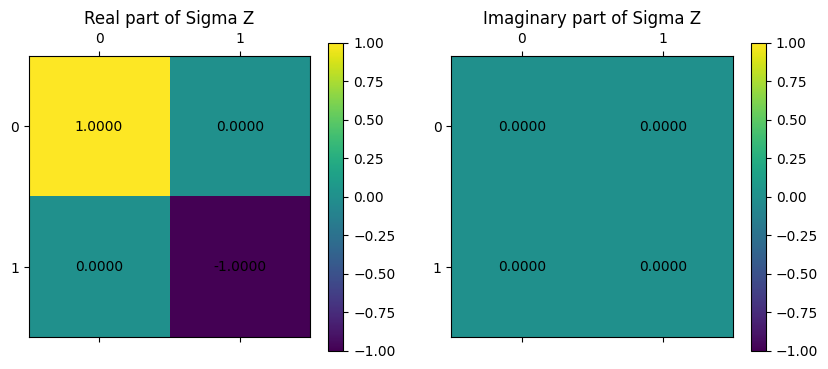

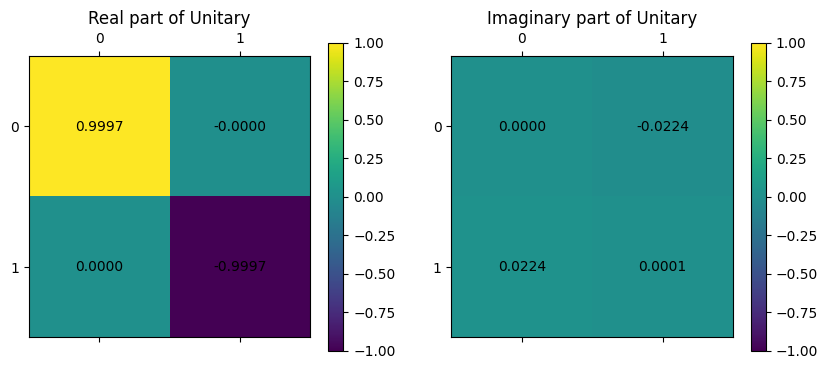

In [41]:
sigma_Z = np.array([[1, 0], [0, -1]])
Unitary_z = np.array(rotation_matrix_result_z)

def plot_matrix(matrix, title, vmin=0, vmax=1):
    fig, ax = plt.subplots(1, 2, figsize=(10, 4))
    
    # Real part
    cax1 = ax[0].matshow(matrix.real, cmap='viridis', vmin=vmin, vmax=vmax)
    fig.colorbar(cax1, ax=ax[0])
    ax[0].set_title(f'Real part of {title}')
    
    # Add values to the real part heatmap
    for (i, j), val in np.ndenumerate(matrix.real):
        ax[0].text(j, i, f'{val:.4f}', ha='center', va='center', color='black')
    
    # Imaginary part
    cax2 = ax[1].matshow(matrix.imag, cmap='viridis', vmin=vmin, vmax=vmax)
    fig.colorbar(cax2, ax=ax[1])
    ax[1].set_title(f'Imaginary part of {title}')
    
    # Add values to the imaginary part heatmap
    for (i, j), val in np.ndenumerate(matrix.imag):
        ax[1].text(j, i, f'{val:.4f}', ha='center', va='center', color='black')
     
    plt.show()

# Plot with the desired color map limits (0 to 1)
plot_matrix(sigma_Z, 'Sigma Z', vmin=-1, vmax=1)
plot_matrix(Unitary_z, 'Unitary', vmin=-1, vmax=1)


Visual Representation 10k

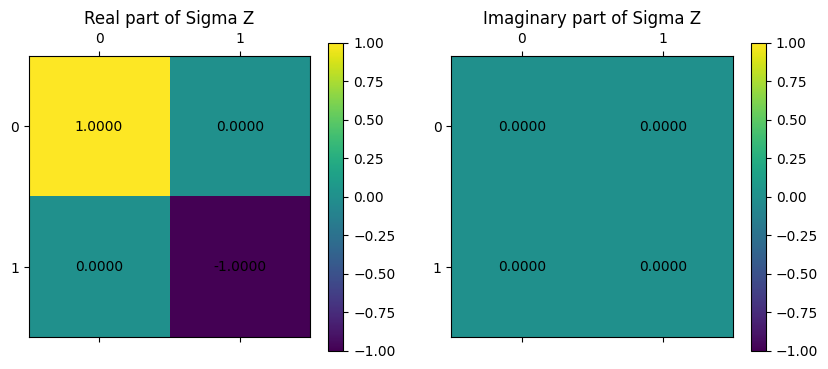

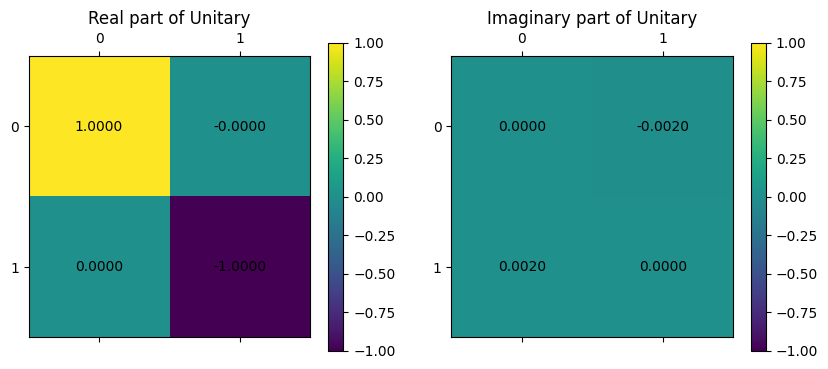

In [43]:
sigma_Z = np.array([[1, 0], [0, -1]])
Unitary_z1 = np.array(rotation_matrix_result_z1)

def plot_matrix(matrix, title, vmin=0, vmax=1):
    fig, ax = plt.subplots(1, 2, figsize=(10, 4))
    
    # Real part
    cax1 = ax[0].matshow(matrix.real, cmap='viridis', vmin=vmin, vmax=vmax)
    fig.colorbar(cax1, ax=ax[0])
    ax[0].set_title(f'Real part of {title}')
    
    # Add values to the real part heatmap
    for (i, j), val in np.ndenumerate(matrix.real):
        ax[0].text(j, i, f'{val:.4f}', ha='center', va='center', color='black')
    
    # Imaginary part
    cax2 = ax[1].matshow(matrix.imag, cmap='viridis', vmin=vmin, vmax=vmax)
    fig.colorbar(cax2, ax=ax[1])
    ax[1].set_title(f'Imaginary part of {title}')
    
    # Add values to the imaginary part heatmap
    for (i, j), val in np.ndenumerate(matrix.imag):
        ax[1].text(j, i, f'{val:.4f}', ha='center', va='center', color='black')
     
    plt.show()

# Plot with the desired color map limits (0 to 1)
plot_matrix(sigma_Z, 'Sigma Z', vmin=-1, vmax=1)
plot_matrix(Unitary_z1, 'Unitary', vmin=-1, vmax=1)


Measurement Comparison 1000

In [45]:
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
import numpy as np

# Function to compute Mean Squared Error (MSE) between two matrices (measured and target)
def compute_overall_mse(measured_matrix, target_matrix):
    measured_matrix = np.array(measured_matrix)
    target_matrix = np.array(target_matrix)
    return np.mean((measured_matrix - target_matrix) ** 2)

# Evaluate and store the measured probabilities in a matrix
def evaluate_measurements_matrix(optimal_params, target_measurements):
    reference_circuits = create_reference_circuits()
    measured_probabilities_matrix = []

    for i, reference_circuit in enumerate(reference_circuits):
        # Combine reference and variational circuits with optimal parameters
        circuit = combine_circuits(reference_circuit, variational_circuit, optimal_params)

        # Measure in Z, X, and Y bases
        prob_z = get_probabilities(measure_circuit(circuit.copy(), 'z'), 'z')
        prob_x = get_probabilities(measure_circuit(circuit.copy(), 'x'), 'x')
        prob_y = get_probabilities(measure_circuit(circuit.copy(), 'y'), 'y')

        # Extract probabilities for each basis
        prob_0 = prob_z.get('|0⟩', 0)
        prob_1 = prob_z.get('|1⟩', 0)
        prob_plus = prob_x.get('|+⟩', 0)
        prob_minus = prob_x.get('|-⟩', 0)
        prob_plus_i = prob_y.get('|+i⟩', 0)
        prob_minus_i = prob_y.get('|-i⟩', 0)

        # Combine all probabilities into a single list
        measured_probabilities = [prob_0, prob_1, prob_plus, prob_minus, prob_plus_i, prob_minus_i]

        # Append the list to the measured probabilities matrix
        measured_probabilities_matrix.append(measured_probabilities)

        # Print measured probabilities for clarity
        print(f"Measured Probabilities for reference state {i+1}: {measured_probabilities}")

    # Compute the overall MSE between the entire measured matrix and the target matrix
    overall_mse = compute_overall_mse(measured_probabilities_matrix, target_measurements)

    # Print the measured probability matrix and the overall MSE
    print("\nMeasured Probabilities Matrix:")
    for row in measured_probabilities_matrix:
        print(row)
    
    print(f"\nOverall Mean Squared Error (MSE): {overall_mse}")
    return measured_probabilities_matrix, overall_mse

# Now call the function with optimal_params and target_measurements

# Run the evaluation and get the measured matrix and MSE
measured_matrix, overall_mse = evaluate_measurements_matrix(optimal_params_z, target_measurements_Z)



# Lets try to print the matrices

print("The Target Measurements \n")
target_matrix = np.array(target_measurements_Z)
print(target_matrix)
print("\n")
print("The Prepared Measurements \n")
Prepared_measurements = np.array(measured_matrix)
np.set_printoptions(linewidth=200)
print(Prepared_measurements)

Measured Probabilities for reference state 1: [1.0, 0, 0.526, 0.474, 0.491, 0.509]
Measured Probabilities for reference state 2: [0, 1.0, 0.489, 0.511, 0.494, 0.506]
Measured Probabilities for reference state 3: [0.505, 0.495, 0, 1.0, 0.505, 0.495]
Measured Probabilities for reference state 4: [0.502, 0.498, 1.0, 0, 0.531, 0.469]
Measured Probabilities for reference state 5: [0.544, 0.456, 0.517, 0.483, 0.001, 0.999]
Measured Probabilities for reference state 6: [0.427, 0.573, 0.487, 0.513, 1.0, 0]

Measured Probabilities Matrix:
[1.0, 0, 0.526, 0.474, 0.491, 0.509]
[0, 1.0, 0.489, 0.511, 0.494, 0.506]
[0.505, 0.495, 0, 1.0, 0.505, 0.495]
[0.502, 0.498, 1.0, 0, 0.531, 0.469]
[0.544, 0.456, 0.517, 0.483, 0.001, 0.999]
[0.427, 0.573, 0.487, 0.513, 1.0, 0]

Overall Mean Squared Error (MSE): 0.0005362777777777779
The Target Measurements 

[[1.  0.  0.5 0.5 0.5 0.5]
 [0.  1.  0.5 0.5 0.5 0.5]
 [0.5 0.5 0.  1.  0.5 0.5]
 [0.5 0.5 1.  0.  0.5 0.5]
 [0.5 0.5 0.5 0.5 0.  1. ]
 [0.5 0.5 0.5 0.5 

Measurement Comparison 10k

In [47]:
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
import numpy as np

# Function to compute Mean Squared Error (MSE) between two matrices (measured and target)
def compute_overall_mse(measured_matrix, target_matrix):
    measured_matrix = np.array(measured_matrix)
    target_matrix = np.array(target_matrix)
    return np.mean((measured_matrix - target_matrix) ** 2)

# Evaluate and store the measured probabilities in a matrix
def evaluate_measurements_matrix(optimal_params, target_measurements):
    reference_circuits = create_reference_circuits()
    measured_probabilities_matrix = []

    for i, reference_circuit in enumerate(reference_circuits):
        # Combine reference and variational circuits with optimal parameters
        circuit = combine_circuits(reference_circuit, variational_circuit, optimal_params)

        # Measure in Z, X, and Y bases
        prob_z = get_probabilities(measure_circuit(circuit.copy(), 'z'), 'z')
        prob_x = get_probabilities(measure_circuit(circuit.copy(), 'x'), 'x')
        prob_y = get_probabilities(measure_circuit(circuit.copy(), 'y'), 'y')

        # Extract probabilities for each basis
        prob_0 = prob_z.get('|0⟩', 0)
        prob_1 = prob_z.get('|1⟩', 0)
        prob_plus = prob_x.get('|+⟩', 0)
        prob_minus = prob_x.get('|-⟩', 0)
        prob_plus_i = prob_y.get('|+i⟩', 0)
        prob_minus_i = prob_y.get('|-i⟩', 0)

        # Combine all probabilities into a single list
        measured_probabilities = [prob_0, prob_1, prob_plus, prob_minus, prob_plus_i, prob_minus_i]

        # Append the list to the measured probabilities matrix
        measured_probabilities_matrix.append(measured_probabilities)

        # Print measured probabilities for clarity
        print(f"Measured Probabilities for reference state {i+1}: {measured_probabilities}")

    # Compute the overall MSE between the entire measured matrix and the target matrix
    overall_mse = compute_overall_mse(measured_probabilities_matrix, target_measurements)

    # Print the measured probability matrix and the overall MSE
    print("\nMeasured Probabilities Matrix:")
    for row in measured_probabilities_matrix:
        print(row)
    
    print(f"\nOverall Mean Squared Error (MSE): {overall_mse}")
    return measured_probabilities_matrix, overall_mse

# Now call the function with optimal_params and target_measurements

# Run the evaluation and get the measured matrix and MSE
measured_matrix, overall_mse = evaluate_measurements_matrix(optimal_params_z1, target_measurements_Z1)



# Lets try to print the matrices

print("The Target Measurements \n")
target_matrix = np.array(target_measurements_Z1)
print(target_matrix)
print("\n")
print("The Prepared Measurements \n")
Prepared_measurements = np.array(measured_matrix)
np.set_printoptions(linewidth=200)
print(Prepared_measurements)

Measured Probabilities for reference state 1: [1.0, 0, 0.506, 0.494, 0.505, 0.495]
Measured Probabilities for reference state 2: [0, 1.0, 0.483, 0.517, 0.48, 0.52]
Measured Probabilities for reference state 3: [0.524, 0.476, 0, 1.0, 0.49, 0.51]
Measured Probabilities for reference state 4: [0.498, 0.502, 1.0, 0, 0.483, 0.517]
Measured Probabilities for reference state 5: [0.481, 0.519, 0.511, 0.489, 0, 1.0]
Measured Probabilities for reference state 6: [0.543, 0.457, 0.506, 0.494, 1.0, 0]

Measured Probabilities Matrix:
[1.0, 0, 0.506, 0.494, 0.505, 0.495]
[0, 1.0, 0.483, 0.517, 0.48, 0.52]
[0.524, 0.476, 0, 1.0, 0.49, 0.51]
[0.498, 0.502, 1.0, 0, 0.483, 0.517]
[0.481, 0.519, 0.511, 0.489, 0, 1.0]
[0.543, 0.457, 0.506, 0.494, 1.0, 0]

Overall Mean Squared Error (MSE): 0.0002270000000000002
The Target Measurements 

[[1.  0.  0.5 0.5 0.5 0.5]
 [0.  1.  0.5 0.5 0.5 0.5]
 [0.5 0.5 0.  1.  0.5 0.5]
 [0.5 0.5 1.  0.  0.5 0.5]
 [0.5 0.5 0.5 0.5 0.  1. ]
 [0.5 0.5 0.5 0.5 1.  0. ]]


The Prep

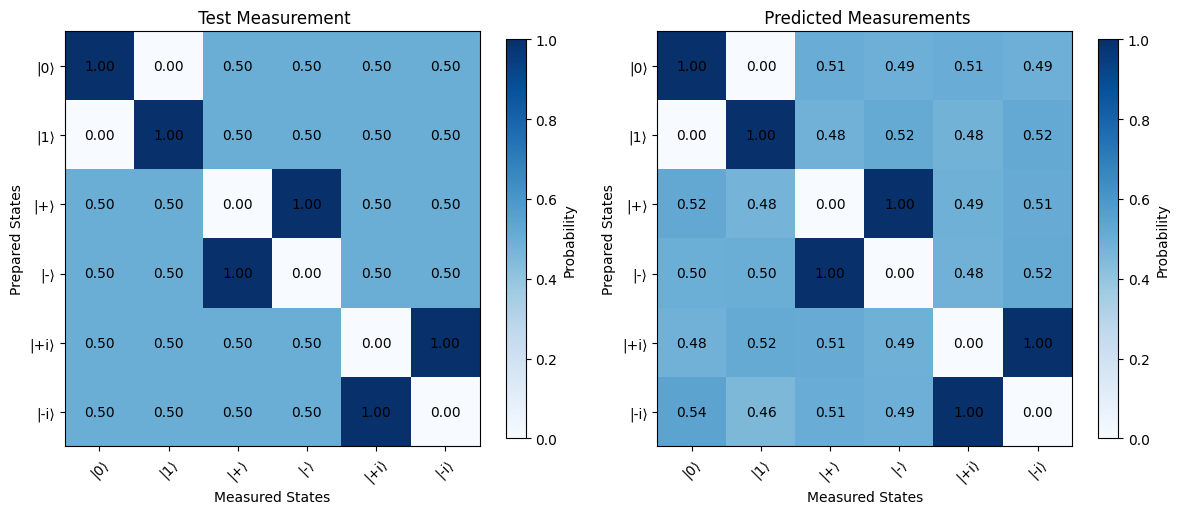

In [48]:
import numpy as np
import matplotlib.pyplot as plt

# Matrices 
Tomographic_measurements = np.array((target_matrix))
Experimental_measurements = np.array((Prepared_measurements))

# Define the state labels
state_labels = ['|0⟩', '|1⟩', '|+⟩', '|-⟩', '|+i⟩', '|-i⟩']

# Create a figure with two subplots (1 row, 2 columns)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot the Target Measurements heatmap on the left
heatmap1 = ax1.imshow(Tomographic_measurements, cmap='Blues', interpolation='nearest')
ax1.set_title(' Test Measurement')
ax1.set_xticks(np.arange(len(state_labels)))
ax1.set_yticks(np.arange(len(state_labels)))
ax1.set_xticklabels(state_labels, rotation=45)
ax1.set_yticklabels(state_labels)
ax1.set_xlabel('Measured States')
ax1.set_ylabel('Prepared States')

# Add text annotations to the target matrix
for i in range(Tomographic_measurements.shape[0]):
    for j in range(Tomographic_measurements.shape[1]):
        value = Tomographic_measurements[i, j]
        ax1.text(j, i, f'{value:.2f}', ha='center', va='center', color='black')

# Add color bar for the target heatmap
fig.colorbar(heatmap1, ax=ax1, label='Probability',shrink= 0.7)

# Plot the Prepared Measurements heatmap on the right
heatmap2 = ax2.imshow(Experimental_measurements, cmap='Blues', interpolation='nearest')
ax2.set_title(' Predicted Measurements')
ax2.set_xticks(np.arange(len(state_labels)))
ax2.set_yticks(np.arange(len(state_labels)))
ax2.set_xticklabels(state_labels, rotation=45)
ax2.set_yticklabels(state_labels)
ax2.set_xlabel('Measured States')
ax2.set_ylabel('Prepared States')

# Add text annotations to the prepared matrix
for i in range(Experimental_measurements.shape[0]):
    for j in range(Experimental_measurements.shape[1]):
        value = Experimental_measurements[i, j]
        ax2.text(j, i, f'{value:.2f}', ha='center', va='center', color='black')

# Add color bar for the prepared heatmap
fig.colorbar(heatmap2, ax=ax2, label='Probability',shrink= 0.7)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

# Hadamard Gate

In [179]:
import numpy as np

# Define a 6x6 matrix with your specified elements
measurements_matrix_H = np.array([
    [0.5, 0.5, 1, 0, 0.5, 0.5],  # Row 1
    [0.5, 0.5, 0, 1, 0.5, 0.5],  # Row 2
    [1, 0, 0.5, 0.5, 0.5, 0.5],  # Row 3
    [0, 1, 0.5, 0.5, 0.5, 0.5],  # Row 4
    [0.5, 0.5, 0.5, 0.5, 0, 1],  # Row 5
    [0.5, 0.5, 0.5, 0.5, 1, 0]   # Row 6
])

# Print the matrix
print("6x6 Matrix:")
print(measurements_matrix_H)


6x6 Matrix:
[[0.5 0.5 1.  0.  0.5 0.5]
 [0.5 0.5 0.  1.  0.5 0.5]
 [1.  0.  0.5 0.5 0.5 0.5]
 [0.  1.  0.5 0.5 0.5 0.5]
 [0.5 0.5 0.5 0.5 0.  1. ]
 [0.5 0.5 0.5 0.5 1.  0. ]]


In [181]:
from qiskit import QuantumCircuit, transpile
from qiskit.circuit import Parameter
from qiskit_aer import AerSimulator
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# Define the reference circuits for each state
def create_reference_circuits_H():
    circuits = []

    # |0⟩ state
    qc_0 = QuantumCircuit(1)
    qc_0.ry(0, 0)
    qc_0.rz(0, 0)
    circuits.append(qc_0)

    # |1⟩ state
    qc_1 = QuantumCircuit(1)
    qc_1.ry(np.pi, 0)
    qc_1.rz(0, 0)
    circuits.append(qc_1)

    # |+⟩ state
    qc_plus = QuantumCircuit(1)
    qc_plus.ry(np.pi/2, 0)
    qc_plus.rz(0, 0)
    circuits.append(qc_plus)

    # |−⟩ state
    qc_minus = QuantumCircuit(1)
    qc_minus.ry(-np.pi/2, 0)  
    qc_minus.rz(0, 0)
    circuits.append(qc_minus)

    # |+i⟩ state
    qc_plus_i = QuantumCircuit(1)
    qc_plus_i.ry(np.pi/2, 0)
    qc_plus_i.rz(np.pi/2, 0)
    circuits.append(qc_plus_i)

    # |-i⟩ state
    qc_minus_i = QuantumCircuit(1)
    qc_minus_i.ry(-np.pi/2, 0)
    qc_minus_i.rz(np.pi/2, 0)
    circuits.append(qc_minus_i)

    return circuits

# Define parameters for the variational circuit
theta_H = Parameter('θ')
phi_H = Parameter('φ')
Lambda_H = Parameter('λ')

# Create a variational circuit
variational_circuit_H = QuantumCircuit(1)
variational_circuit_H.rz(Lambda_H, 0)
variational_circuit_H.ry(theta_H, 0)
variational_circuit_H.rz(phi_H, 0)

# Function to combine reference and variational circuits
def combine_circuits_H(reference_circuit, variational_circuit_H, params):
    combined_circuit = reference_circuit.compose(variational_circuit_H, inplace=False)
    combined_circuit = combined_circuit.assign_parameters(params)
    return combined_circuit

# Run the circuit and return probabilities
def get_probabilities_H(circuit, basis):
    simulator = AerSimulator()
    compiled_circuit = transpile(circuit, simulator)
    result = simulator.run(compiled_circuit, shots=1000).result()
    counts = result.get_counts()

    # Define state labels for each basis
    state_labels = {
        'z': {'0': '|0⟩', '1': '|1⟩'},
        'x': {'0': '|+⟩', '1': '|-⟩'},
        'y': {'0': '|+i⟩', '1': '|-i⟩'}
    }

    # Map counts to state labels
    labeled_counts = {state_labels[basis].get(k, k): v for k, v in counts.items()}
    total_shots = sum(labeled_counts.values())
    probabilities = {state: count / total_shots for state, count in labeled_counts.items()}

    return probabilities

# Measure circuit in different bases
def measure_circuit_H(circuit, basis):
    if basis == 'z':
        circuit.z(0)
        circuit.x(0)
        circuit.measure_all()
    elif basis == 'x':
        circuit.h(0)
        circuit.x(0)
        circuit.measure_all()
    elif basis == 'y':
        circuit.rx(np.pi / 2, 0)
        circuit.measure_all()
    else:
        raise ValueError("Basis must be one of 'z', 'x', or 'y'")
    return circuit




# Cost function across all reference states
def cost_function_H(params, target_measurements_H, callback=None):
    reference_circuits = create_reference_circuits_H()

    #total_cost = 0  # Initialize total cost

    for i, reference_circuit in enumerate(reference_circuits):
        circuit = combine_circuits_H(reference_circuit, variational_circuit_H, params)
        
        # Measure in each basis and get probabilities
        prob_z = get_probabilities_H(measure_circuit_H(circuit.copy(), 'z'), 'z')
        prob_x = get_probabilities_H(measure_circuit_H(circuit.copy(), 'x'), 'x')
        prob_y = get_probabilities_H(measure_circuit_H(circuit.copy(), 'y'), 'y')

        # Extract probabilities for each basis
        prob_0 = prob_z.get('|0⟩', 0)
        prob_1 = prob_z.get('|1⟩', 0)
        prob_plus = prob_x.get('|+⟩', 0)
        prob_minus = prob_x.get('|-⟩', 0)
        prob_plus_i = prob_y.get('|+i⟩', 0)
        prob_minus_i = prob_y.get('|-i⟩', 0)

        # Combine all probabilities into a single list
        measured_probabilities_H = [prob_0, prob_1, prob_plus, prob_minus, prob_plus_i, prob_minus_i]

        # Calculate the cost for this reference circuit
        target_probabilities = np.array(target_measurements_H[i])
        cost = np.sum((measured_probabilities_H - target_probabilities) ** 2)
        total_cost = cost

    if callback:
        callback(params, total_cost)

    return total_cost

# Bounds constraint functions
def constraint_theta_lower(params):
    return params[0]  - (4*np.pi/9)

def constraint_theta_upper(params):
    return np.pi - params[0]  

def constraint_phi_lower(params):
    return params[1]  

def constraint_phi_upper(params):
    return np.pi/36 - params[1]  

def constraint_lambda_lower(params):
    return params[2]  - (5*np.pi/6)

def constraint_lambda_upper(params):
    return np.pi - params[2]  

# List of constraints
constraints = [
    {'type': 'ineq', 'fun': constraint_theta_lower},  
    {'type': 'ineq', 'fun': constraint_theta_upper},  
    {'type': 'ineq', 'fun': constraint_phi_lower},  
    {'type': 'ineq', 'fun': constraint_phi_upper},    
    {'type': 'ineq', 'fun': constraint_lambda_lower},  
    {'type': 'ineq', 'fun': constraint_lambda_upper}   
]

# Initialize lists to store values
iterations = []
cost_values = []

# Callback function to update the lists
def callback_function(params, cost):
    iterations.append(len(iterations))  # Store the iteration number
    cost_values.append(cost)  # Store the cost value
    #print(f"Parameters: {params}")
    #print(f"Cost: {cost}\n")

target_measurements_H = measurements_matrix_H
# Initial guess for parameters 
initial_params = [4*np.pi/9, np.pi/36, 5*np.pi/6]  

# Optimize parameters using COBYLA with constraints
result_H = minimize(
    cost_function_H, 
    initial_params, 
    args=(target_measurements_H, callback_function), 
    method='Nelder-Mead', 
    bounds = [(4*np.pi/9, np.pi/2) , (0, np.pi/36 ), (5*np.pi/6, np.pi)]
    #constraints=constraints
)

# Plot the final cost vs iterations after optimization
# Plot and save normal scale plot
plt.figure()
plt.plot(iterations, cost_values, label="Cost Function (Normal Scale)")
plt.xlabel('Iteration')
plt.ylabel('Cost Function')
plt.title('Normal Scale Cost Function for Pauli-Z operator')
plt.legend()
plt.savefig('1000 COBYLA_H normal_scale_cost_function_plot.png')
plt.close()

# Plot and save log scale plot
plt.figure()
plt.plot(iterations, cost_values, label="Cost Function (Log Scale)")
plt.xlabel('Iteration')
plt.ylabel('Cost Function')
plt.title('Log Scale Cost Function for Pauli-Z operator')
plt.yscale('log')
plt.legend()
plt.savefig('1000 COBYLA_H log_scale_cost_function_plot.png')
plt.close()

# Optimal parameters
optimal_params_H = result_H.x
optimal_cost_H = result_H.fun
print("Optimal Parameters:", optimal_params_H)
print("Optimal Cost:", optimal_cost_H)

print("\n\nOptimal Parameters:")
theta_opt_H, phi_opt_H, Lambda_opt_H = result_H.x
print(f"theta: {theta_opt_H}")
print(f"phi: {phi_opt_H}")
print(f"Lambda:{Lambda_opt_H}")


Optimal Parameters: [1.42009309 0.08726646 3.14149165]
Optimal Cost: 8.400000000000014e-05


Optimal Parameters:
theta: 1.4200930913369136
phi: 0.08726646259971643
Lambda:3.141491650739562


In [182]:
from qiskit import QuantumCircuit, transpile
from qiskit.circuit import Parameter
from qiskit_aer import AerSimulator
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# Define the reference circuits for each state
def create_reference_circuits_H1():
    circuits = []

    # |0⟩ state
    qc_0 = QuantumCircuit(1)
    qc_0.ry(0, 0)
    qc_0.rz(0, 0)
    circuits.append(qc_0)

    # |1⟩ state
    qc_1 = QuantumCircuit(1)
    qc_1.ry(np.pi, 0)
    qc_1.rz(0, 0)
    circuits.append(qc_1)

    # |+⟩ state
    qc_plus = QuantumCircuit(1)
    qc_plus.ry(np.pi/2, 0)
    qc_plus.rz(0, 0)
    circuits.append(qc_plus)

    # |−⟩ state
    qc_minus = QuantumCircuit(1)
    qc_minus.ry(-np.pi/2, 0)  
    qc_minus.rz(0, 0)
    circuits.append(qc_minus)

    # |+i⟩ state
    qc_plus_i = QuantumCircuit(1)
    qc_plus_i.ry(np.pi/2, 0)
    qc_plus_i.rz(np.pi/2, 0)
    circuits.append(qc_plus_i)

    # |-i⟩ state
    qc_minus_i = QuantumCircuit(1)
    qc_minus_i.ry(-np.pi/2, 0)
    qc_minus_i.rz(np.pi/2, 0)
    circuits.append(qc_minus_i)

    return circuits

# Define parameters for the variational circuit
theta_H1 = Parameter('θ')
phi_H1 = Parameter('φ')
Lambda_H1 = Parameter('λ')

# Create a variational circuit
variational_circuit_H1 = QuantumCircuit(1)
variational_circuit_H1.rz(Lambda_H1, 0)
variational_circuit_H1.ry(theta_H1, 0)
variational_circuit_H1.rz(phi_H1, 0)

# Function to combine reference and variational circuits
def combine_circuits_H1(reference_circuit, variational_circuit_H1, params):
    combined_circuit = reference_circuit.compose(variational_circuit_H1, inplace=False)
    combined_circuit = combined_circuit.assign_parameters(params)
    return combined_circuit

# Run the circuit and return probabilities
def get_probabilities_H1(circuit, basis):
    simulator = AerSimulator()
    compiled_circuit = transpile(circuit, simulator)
    result = simulator.run(compiled_circuit, shots=10000).result()
    counts = result.get_counts()

    # Define state labels for each basis
    state_labels = {
        'z': {'0': '|0⟩', '1': '|1⟩'},
        'x': {'0': '|+⟩', '1': '|-⟩'},
        'y': {'0': '|+i⟩', '1': '|-i⟩'}
    }

    # Map counts to state labels
    labeled_counts = {state_labels[basis].get(k, k): v for k, v in counts.items()}
    total_shots = sum(labeled_counts.values())
    probabilities = {state: count / total_shots for state, count in labeled_counts.items()}

    return probabilities

# Measure circuit in different bases
def measure_circuit_H1(circuit, basis):
    if basis == 'z':
        circuit.z(0)
        circuit.x(0)
        circuit.measure_all()
    elif basis == 'x':
        circuit.h(0)
        circuit.x(0)
        circuit.measure_all()
    elif basis == 'y':
        circuit.rx(np.pi / 2, 0)
        circuit.measure_all()
    else:
        raise ValueError("Basis must be one of 'z', 'x', or 'y'")
    return circuit




# Cost function across all reference states
def cost_function_H1(params, target_measurements_H1, callback=None):
    reference_circuits = create_reference_circuits_H1()

    #total_cost = 0  # Initialize total cost

    for i, reference_circuit in enumerate(reference_circuits):
        circuit = combine_circuits_H1(reference_circuit, variational_circuit_H1, params)
        
        # Measure in each basis and get probabilities
        prob_z = get_probabilities_H1(measure_circuit_H1(circuit.copy(), 'z'), 'z')
        prob_x = get_probabilities_H1(measure_circuit_H1(circuit.copy(), 'x'), 'x')
        prob_y = get_probabilities_H1(measure_circuit_H1(circuit.copy(), 'y'), 'y')

        # Extract probabilities for each basis
        prob_0 = prob_z.get('|0⟩', 0)
        prob_1 = prob_z.get('|1⟩', 0)
        prob_plus = prob_x.get('|+⟩', 0)
        prob_minus = prob_x.get('|-⟩', 0)
        prob_plus_i = prob_y.get('|+i⟩', 0)
        prob_minus_i = prob_y.get('|-i⟩', 0)

        # Combine all probabilities into a single list
        measured_probabilities_H1 = [prob_0, prob_1, prob_plus, prob_minus, prob_plus_i, prob_minus_i]

        # Calculate the cost for this reference circuit
        target_probabilities = np.array(target_measurements_H1[i])
        cost = np.sum((measured_probabilities_H1 - target_probabilities) ** 2)
        total_cost = cost

    if callback:
        callback(params, total_cost)

    return total_cost

# Bounds constraint functions
def constraint_theta_lower(params):
    return params[0]  - (4*np.pi/9)

def constraint_theta_upper(params):
    return np.pi - params[0]  

def constraint_phi_lower(params):
    return params[1]  

def constraint_phi_upper(params):
    return np.pi/36 - params[1]  

def constraint_lambda_lower(params):
    return params[2]  - (5*np.pi/6)

def constraint_lambda_upper(params):
    return np.pi - params[2]  

# List of constraints
constraints = [
    {'type': 'ineq', 'fun': constraint_theta_lower},  
    {'type': 'ineq', 'fun': constraint_theta_upper},  
    {'type': 'ineq', 'fun': constraint_phi_lower},  
    {'type': 'ineq', 'fun': constraint_phi_upper},    
    {'type': 'ineq', 'fun': constraint_lambda_lower},  
    {'type': 'ineq', 'fun': constraint_lambda_upper}   
]

# Initialize lists to store values
iterations = []
cost_values = []

# Callback function to update the lists
def callback_function(params, cost):
    iterations.append(len(iterations))  # Store the iteration number
    cost_values.append(cost)  # Store the cost value
    #print(f"Parameters: {params}")
    #print(f"Cost: {cost}\n")

target_measurements_H1 = measurements_matrix_H
# Initial guess for parameters 
initial_params = [4*np.pi/9, np.pi/36, 5*np.pi/6]  

# Optimize parameters using COBYLA with constraints
result_H1 = minimize(
    cost_function_H1, 
    initial_params, 
    args=(target_measurements_H1, callback_function), 
    method='Nelder-Mead', 
    bounds = [(4*np.pi/9, np.pi/2) , (0, np.pi/36 ), (5*np.pi/6, np.pi)]
    #constraints=constraints
)

# Plot the final cost vs iterations after optimization
# Plot and save normal scale plot
plt.figure()
plt.plot(iterations, cost_values, label="Cost Function (Normal Scale)")
plt.xlabel('Iteration')
plt.ylabel('Cost Function')
plt.title('Normal Scale Cost Function for Pauli-Z operator')
plt.legend()
plt.savefig('10000 COBYLA_H normal_scale_cost_function_plot.png')
plt.close()

# Plot and save log scale plot
plt.figure()
plt.plot(iterations, cost_values, label="Cost Function (Log Scale)")
plt.xlabel('Iteration')
plt.ylabel('Cost Function')
plt.title('Log Scale Cost Function for Pauli-Z operator')
plt.yscale('log')
plt.legend()
plt.savefig('10000 COBYLA_H log_scale_cost_function_plot.png')
plt.close()

# Optimal parameters
optimal_params_H1 = result_H.x
optimal_cost_H1 = result_H1.fun
print("Optimal Parameters:", optimal_params_H1)
print("Optimal Cost:", optimal_cost_H1)

print("\n\nOptimal Parameters:")
theta_opt_H1, phi_opt_H1, Lambda_opt_H1 = result_H1.x
print(f"theta: {theta_opt_H1}")
print(f"phi: {phi_opt_H1}")
print(f"Lambda:{Lambda_opt_H1}")


Optimal Parameters: [1.42009309 0.08726646 3.14149165]
Optimal Cost: 0.0019808999999999994


Optimal Parameters:
theta: 1.4005664304074705
phi: 0.08726646259971643
Lambda:3.141592653589793


In [183]:
import numpy as np

def rotation_matrix(theta, phi, lambda_):
    """
    Returns the universal rotation matrix for a single qubit using the given theta, phi, and lambda.
    """
    return np.array([
        [np.cos(theta / 2), -np.exp(1j * lambda_) * np.sin(theta / 2)],
        [np.exp(1j * phi) * np.sin(theta / 2), np.exp(1j * (lambda_ + phi)) * np.cos(theta / 2)]
    ])


# Generate the rotation matrix
rotation_matrix_result_h = rotation_matrix(theta_opt_H, phi_opt_H, Lambda_opt_H)
rotation_matrix_result_h1 = rotation_matrix(theta_opt_H1, phi_opt_H1, Lambda_opt_H1)
# Print the resulting rotation matrix
print("\nUnitary Matrix, U:")
print(rotation_matrix_result_h)
print("\nUnitary Matrix, U_1:")
print(rotation_matrix_result_h1)


Unitary Matrix, U:
[[ 0.75833154+0.00000000e+00j  0.65186907-6.58406338e-05j]
 [ 0.64938851+5.68141329e-02j -0.75545253-6.60166457e-02j]]

Unitary Matrix, U_1:
[[ 0.7646597 +0.00000000e+00j  0.64443428-7.89204374e-17j]
 [ 0.64198201+5.61661480e-02j -0.76174994-6.66444845e-02j]]


Visual Representation 1000

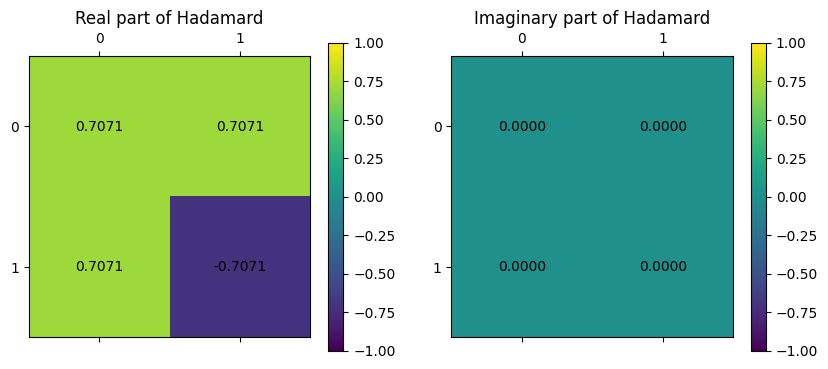

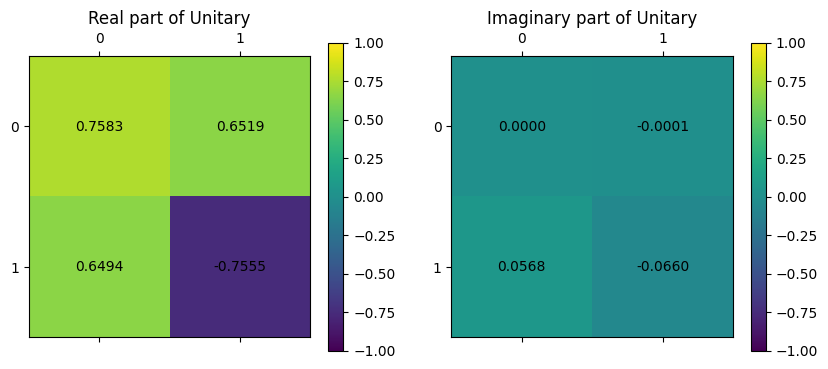

In [203]:
Hadamard = np.array([[1/np.sqrt(2), 1/np.sqrt(2)], [1/np.sqrt(2), -1/np.sqrt(2)]])
Unitary_H = np.array(rotation_matrix_result_h)

def plot_matrix(matrix, title, vmin=0, vmax=1):
    fig, ax = plt.subplots(1, 2, figsize=(10, 4))
    
    # Real part
    cax1 = ax[0].matshow(matrix.real, cmap='viridis', vmin=vmin, vmax=vmax)
    fig.colorbar(cax1, ax=ax[0])
    ax[0].set_title(f'Real part of {title}')
    
    # Add values to the real part heatmap
    for (i, j), val in np.ndenumerate(matrix.real):
        ax[0].text(j, i, f'{val:.4f}', ha='center', va='center', color='black')
    
    # Imaginary part
    cax2 = ax[1].matshow(matrix.imag, cmap='viridis', vmin=vmin, vmax=vmax)
    fig.colorbar(cax2, ax=ax[1])
    ax[1].set_title(f'Imaginary part of {title}')
    
    # Add values to the imaginary part heatmap
    for (i, j), val in np.ndenumerate(matrix.imag):
        ax[1].text(j, i, f'{val:.4f}', ha='center', va='center', color='black')
     
    plt.show()

# Plot with the desired color map limits (0 to 1)
plot_matrix(Hadamard, 'Hadamard', vmin=-1, vmax=1)
plot_matrix(Unitary_H, 'Unitary', vmin=-1, vmax=1)


Visual Representation 10k

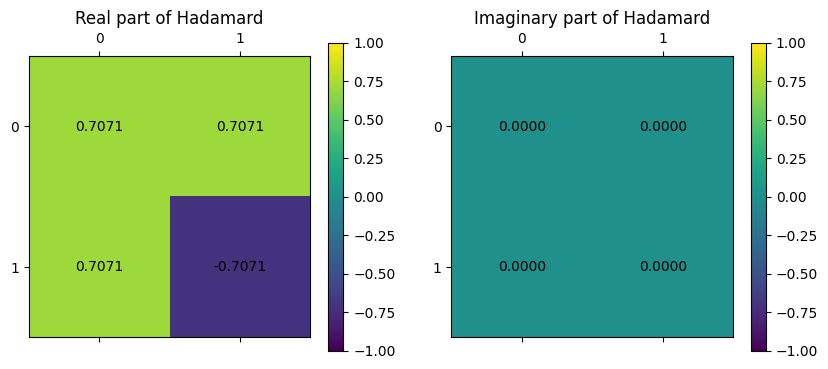

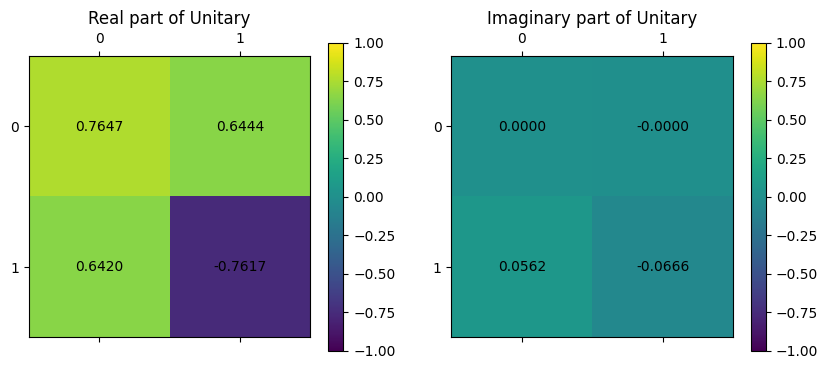

In [211]:
Hadamard = np.array([[1/np.sqrt(2), 1/np.sqrt(2)], [1/np.sqrt(2), -1/np.sqrt(2)]])
Unitary_H1 = np.array(rotation_matrix_result_h1)
def plot_matrix(matrix, title, vmin=0, vmax=1):
    fig, ax = plt.subplots(1, 2, figsize=(10, 4))
    
    # Real part
    cax1 = ax[0].matshow(matrix.real, cmap='viridis', vmin=vmin, vmax=vmax)
    fig.colorbar(cax1, ax=ax[0])
    ax[0].set_title(f'Real part of {title}')
    
    # Add values to the real part heatmap
    for (i, j), val in np.ndenumerate(matrix.real):
        ax[0].text(j, i, f'{val:.4f}', ha='center', va='center', color='black')
    
    # Imaginary part
    cax2 = ax[1].matshow(matrix.imag, cmap='viridis', vmin=vmin, vmax=vmax)
    fig.colorbar(cax2, ax=ax[1])
    ax[1].set_title(f'Imaginary part of {title}')
    
    # Add values to the imaginary part heatmap
    for (i, j), val in np.ndenumerate(matrix.imag):
        ax[1].text(j, i, f'{val:.4f}', ha='center', va='center', color='black')
     
    plt.show()

# Plot with the desired color map limits (0 to 1)
plot_matrix(Hadamard, 'Hadamard', vmin=-1, vmax=1)
plot_matrix(Unitary_H1, 'Unitary', vmin=-1, vmax=1)


Measurement Comparison 1000

In [189]:
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
import numpy as np

# Function to compute Mean Squared Error (MSE) between two matrices (measured and target)
def compute_overall_mse(measured_matrix, target_matrix):
    measured_matrix = np.array(measured_matrix)
    target_matrix = np.array(target_matrix)
    return np.mean((measured_matrix - target_matrix) ** 2)

# Evaluate and store the measured probabilities in a matrix
def evaluate_measurements_matrix(optimal_params, target_measurements):
    reference_circuits = create_reference_circuits()
    measured_probabilities_matrix = []

    for i, reference_circuit in enumerate(reference_circuits):
        # Combine reference and variational circuits with optimal parameters
        circuit = combine_circuits_H1(reference_circuit, variational_circuit, optimal_params)

        # Measure in Z, X, and Y bases
        prob_z = get_probabilities_H1(measure_circuit_H1(circuit.copy(), 'z'), 'z')
        prob_x = get_probabilities_H1(measure_circuit_H1(circuit.copy(), 'x'), 'x')
        prob_y = get_probabilities_H1(measure_circuit_H1(circuit.copy(), 'y'), 'y')

        # Extract probabilities for each basis
        prob_0 = prob_z.get('|0⟩', 0)
        prob_1 = prob_z.get('|1⟩', 0)
        prob_plus = prob_x.get('|+⟩', 0)
        prob_minus = prob_x.get('|-⟩', 0)
        prob_plus_i = prob_y.get('|+i⟩', 0)
        prob_minus_i = prob_y.get('|-i⟩', 0)

        # Combine all probabilities into a single list
        measured_probabilities = [prob_0, prob_1, prob_plus, prob_minus, prob_plus_i, prob_minus_i]

        # Append the list to the measured probabilities matrix
        measured_probabilities_matrix.append(measured_probabilities)

        # Print measured probabilities for clarity
        print(f"Measured Probabilities for reference state {i+1}: {measured_probabilities}")

    # Compute the overall MSE between the entire measured matrix and the target matrix
    overall_mse = compute_overall_mse(measured_probabilities_matrix, target_measurements)

    # Print the measured probability matrix and the overall MSE
    print("\nMeasured Probabilities Matrix:")
    for row in measured_probabilities_matrix:
        print(row)
    
    print(f"\nOverall Mean Squared Error (MSE): {overall_mse}")
    return measured_probabilities_matrix, overall_mse

# Now call the function with optimal_params and target_measurements

# Run the evaluation and get the measured matrix and MSE
measured_matrix, overall_mse = evaluate_measurements_matrix(optimal_params_H, target_measurements_H)



# Lets try to print the matrices

print("The Target Measurements \n")
target_matrix = np.array(target_measurements_H)
print(target_matrix)
print("\n")
print("The Prepared Measurements \n")
Prepared_measurements = np.array(measured_matrix)
np.set_printoptions(linewidth=200)
print(Prepared_measurements)

Measured Probabilities for reference state 1: [0.4211, 0.5789, 0.9932, 0.0068, 0.5019, 0.4981]
Measured Probabilities for reference state 2: [0.5832, 0.4168, 0.0062, 0.9938, 0.5099, 0.4901]
Measured Probabilities for reference state 3: [0.9923, 0.0077, 0.5736, 0.4264, 0.4581, 0.5419]
Measured Probabilities for reference state 4: [0.0079, 0.9921, 0.4286, 0.5714, 0.5377, 0.4623]
Measured Probabilities for reference state 5: [0.4476, 0.5524, 0.4835, 0.5165, 0.002, 0.998]
Measured Probabilities for reference state 6: [0.5451, 0.4549, 0.5069, 0.4931, 0.9983, 0.0017]

Measured Probabilities Matrix:
[0.4211, 0.5789, 0.9932, 0.0068, 0.5019, 0.4981]
[0.5832, 0.4168, 0.0062, 0.9938, 0.5099, 0.4901]
[0.9923, 0.0077, 0.5736, 0.4264, 0.4581, 0.5419]
[0.0079, 0.9921, 0.4286, 0.5714, 0.5377, 0.4623]
[0.4476, 0.5524, 0.4835, 0.5165, 0.002, 0.998]
[0.5451, 0.4549, 0.5069, 0.4931, 0.9983, 0.0017]

Overall Mean Squared Error (MSE): 0.0017918772222222231
The Target Measurements 

[[0.5 0.5 1.  0.  0.5 0.5

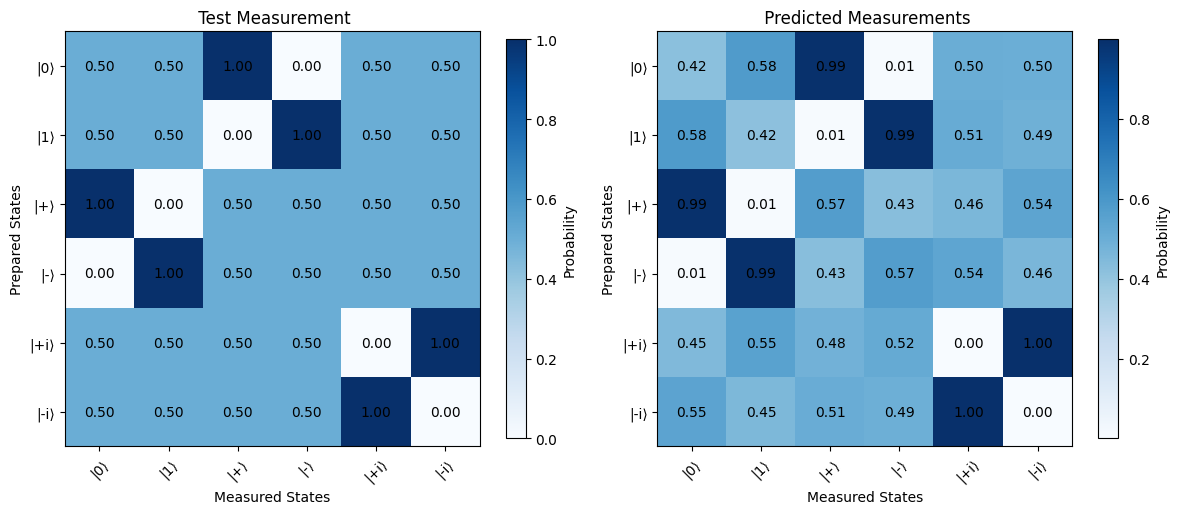

In [190]:
import numpy as np
import matplotlib.pyplot as plt

# Matrices 
Tomographic_measurements = np.array((target_matrix))
Experimental_measurements = np.array((Prepared_measurements))

# Define the state labels
state_labels = ['|0⟩', '|1⟩', '|+⟩', '|-⟩', '|+i⟩', '|-i⟩']

# Create a figure with two subplots (1 row, 2 columns)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot the Target Measurements heatmap on the left
heatmap1 = ax1.imshow(Tomographic_measurements, cmap='Blues', interpolation='nearest')
ax1.set_title(' Test Measurement')
ax1.set_xticks(np.arange(len(state_labels)))
ax1.set_yticks(np.arange(len(state_labels)))
ax1.set_xticklabels(state_labels, rotation=45)
ax1.set_yticklabels(state_labels)
ax1.set_xlabel('Measured States')
ax1.set_ylabel('Prepared States')

# Add text annotations to the target matrix
for i in range(Tomographic_measurements.shape[0]):
    for j in range(Tomographic_measurements.shape[1]):
        value = Tomographic_measurements[i, j]
        ax1.text(j, i, f'{value:.2f}', ha='center', va='center', color='black')

# Add color bar for the target heatmap
fig.colorbar(heatmap1, ax=ax1, label='Probability',shrink= 0.7)

# Plot the Prepared Measurements heatmap on the right
heatmap2 = ax2.imshow(Experimental_measurements, cmap='Blues', interpolation='nearest')
ax2.set_title(' Predicted Measurements')
ax2.set_xticks(np.arange(len(state_labels)))
ax2.set_yticks(np.arange(len(state_labels)))
ax2.set_xticklabels(state_labels, rotation=45)
ax2.set_yticklabels(state_labels)
ax2.set_xlabel('Measured States')
ax2.set_ylabel('Prepared States')

# Add text annotations to the prepared matrix
for i in range(Experimental_measurements.shape[0]):
    for j in range(Experimental_measurements.shape[1]):
        value = Experimental_measurements[i, j]
        ax2.text(j, i, f'{value:.2f}', ha='center', va='center', color='black')

# Add color bar for the prepared heatmap
fig.colorbar(heatmap2, ax=ax2, label='Probability',shrink= 0.7)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

Measurement Comparison 10k

In [192]:
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
import numpy as np

# Function to compute Mean Squared Error (MSE) between two matrices (measured and target)
def compute_overall_mse(measured_matrix, target_matrix):
    measured_matrix = np.array(measured_matrix)
    target_matrix = np.array(target_matrix)
    return np.mean((measured_matrix - target_matrix) ** 2)

# Evaluate and store the measured probabilities in a matrix
def evaluate_measurements_matrix(optimal_params, target_measurements):
    reference_circuits = create_reference_circuits()
    measured_probabilities_matrix = []

    for i, reference_circuit in enumerate(reference_circuits):
        # Combine reference and variational circuits with optimal parameters
        circuit = combine_circuits_H1(reference_circuit, variational_circuit, optimal_params)

        # Measure in Z, X, and Y bases
        prob_z = get_probabilities_H1(measure_circuit_H1(circuit.copy(), 'z'), 'z')
        prob_x = get_probabilities_H1(measure_circuit_H1(circuit.copy(), 'x'), 'x')
        prob_y = get_probabilities_H1(measure_circuit_H1(circuit.copy(), 'y'), 'y')

        # Extract probabilities for each basis
        prob_0 = prob_z.get('|0⟩', 0)
        prob_1 = prob_z.get('|1⟩', 0)
        prob_plus = prob_x.get('|+⟩', 0)
        prob_minus = prob_x.get('|-⟩', 0)
        prob_plus_i = prob_y.get('|+i⟩', 0)
        prob_minus_i = prob_y.get('|-i⟩', 0)

        # Combine all probabilities into a single list
        measured_probabilities = [prob_0, prob_1, prob_plus, prob_minus, prob_plus_i, prob_minus_i]

        # Append the list to the measured probabilities matrix
        measured_probabilities_matrix.append(measured_probabilities)

        # Print measured probabilities for clarity
        print(f"Measured Probabilities for reference state {i+1}: {measured_probabilities}")

    # Compute the overall MSE between the entire measured matrix and the target matrix
    overall_mse = compute_overall_mse(measured_probabilities_matrix, target_measurements)

    # Print the measured probability matrix and the overall MSE
    print("\nMeasured Probabilities Matrix:")
    for row in measured_probabilities_matrix:
        print(row)
    
    print(f"\nOverall Mean Squared Error (MSE): {overall_mse}")
    return measured_probabilities_matrix, overall_mse

# Now call the function with optimal_params and target_measurements

# Run the evaluation and get the measured matrix and MSE
measured_matrix, overall_mse = evaluate_measurements_matrix(optimal_params_H1, target_measurements_H1)



# Lets try to print the matrices

print("The Target Measurements \n")
target_matrix = np.array(target_measurements_H1)
print(target_matrix)
print("\n")
print("The Prepared Measurements \n")
Prepared_measurements = np.array(measured_matrix)
np.set_printoptions(linewidth=200)
print(Prepared_measurements)

Measured Probabilities for reference state 1: [0.4227, 0.5773, 0.9951, 0.0049, 0.5062, 0.4938]
Measured Probabilities for reference state 2: [0.5748, 0.4252, 0.005, 0.995, 0.4967, 0.5033]
Measured Probabilities for reference state 3: [0.9928, 0.0072, 0.5779, 0.4221, 0.4514, 0.5486]
Measured Probabilities for reference state 4: [0.0077, 0.9923, 0.4196, 0.5804, 0.5364, 0.4636]
Measured Probabilities for reference state 5: [0.4637, 0.5363, 0.4977, 0.5023, 0.0014, 0.9986]
Measured Probabilities for reference state 6: [0.539, 0.461, 0.5105, 0.4895, 0.9972, 0.0028]

Measured Probabilities Matrix:
[0.4227, 0.5773, 0.9951, 0.0049, 0.5062, 0.4938]
[0.5748, 0.4252, 0.005, 0.995, 0.4967, 0.5033]
[0.9928, 0.0072, 0.5779, 0.4221, 0.4514, 0.5486]
[0.0077, 0.9923, 0.4196, 0.5804, 0.5364, 0.4636]
[0.4637, 0.5363, 0.4977, 0.5023, 0.0014, 0.9986]
[0.539, 0.461, 0.5105, 0.4895, 0.9972, 0.0028]

Overall Mean Squared Error (MSE): 0.0017201844444444446
The Target Measurements 

[[0.5 0.5 1.  0.  0.5 0.5]
 [

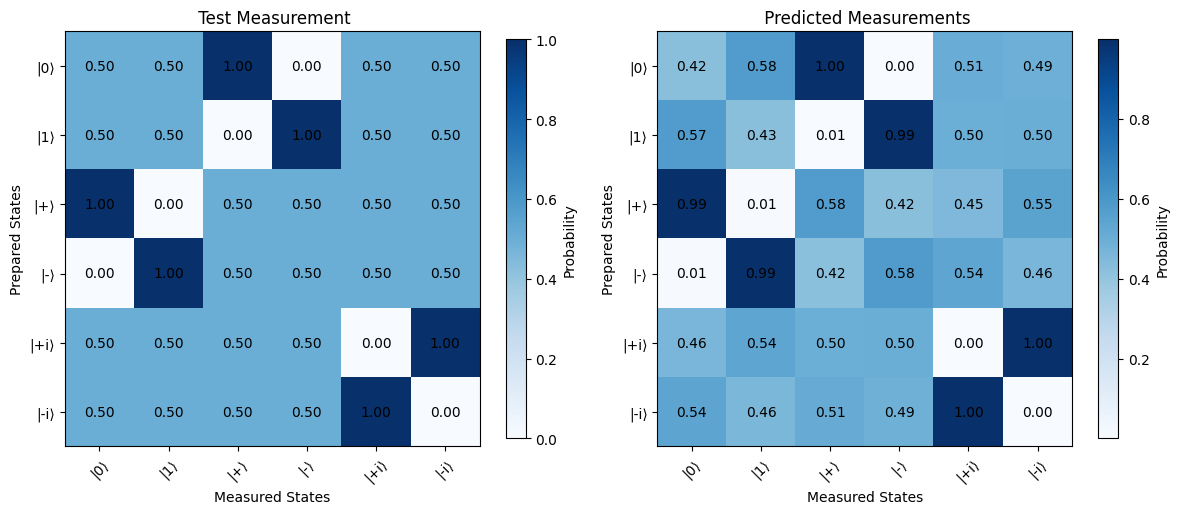

In [193]:
import numpy as np
import matplotlib.pyplot as plt

# Matrices 
Tomographic_measurements = np.array((target_matrix))
Experimental_measurements = np.array((Prepared_measurements))

# Define the state labels
state_labels = ['|0⟩', '|1⟩', '|+⟩', '|-⟩', '|+i⟩', '|-i⟩']

# Create a figure with two subplots (1 row, 2 columns)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot the Target Measurements heatmap on the left
heatmap1 = ax1.imshow(Tomographic_measurements, cmap='Blues', interpolation='nearest')
ax1.set_title(' Test Measurement')
ax1.set_xticks(np.arange(len(state_labels)))
ax1.set_yticks(np.arange(len(state_labels)))
ax1.set_xticklabels(state_labels, rotation=45)
ax1.set_yticklabels(state_labels)
ax1.set_xlabel('Measured States')
ax1.set_ylabel('Prepared States')

# Add text annotations to the target matrix
for i in range(Tomographic_measurements.shape[0]):
    for j in range(Tomographic_measurements.shape[1]):
        value = Tomographic_measurements[i, j]
        ax1.text(j, i, f'{value:.2f}', ha='center', va='center', color='black')

# Add color bar for the target heatmap
fig.colorbar(heatmap1, ax=ax1, label='Probability',shrink= 0.7)

# Plot the Prepared Measurements heatmap on the right
heatmap2 = ax2.imshow(Experimental_measurements, cmap='Blues', interpolation='nearest')
ax2.set_title(' Predicted Measurements')
ax2.set_xticks(np.arange(len(state_labels)))
ax2.set_yticks(np.arange(len(state_labels)))
ax2.set_xticklabels(state_labels, rotation=45)
ax2.set_yticklabels(state_labels)
ax2.set_xlabel('Measured States')
ax2.set_ylabel('Prepared States')

# Add text annotations to the prepared matrix
for i in range(Experimental_measurements.shape[0]):
    for j in range(Experimental_measurements.shape[1]):
        value = Experimental_measurements[i, j]
        ax2.text(j, i, f'{value:.2f}', ha='center', va='center', color='black')

# Add color bar for the prepared heatmap
fig.colorbar(heatmap2, ax=ax2, label='Probability',shrink= 0.7)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

# Phase-S Gate

In [65]:
import numpy as np

# Define a 6x6 matrix with your specified elements
measurements_matrix_s = np.array([
    [1, 0, 0.5, 0.5, 0.5, 0.5],  # Row 1
    [0, 1, 0.5, 0.5, 0.5, 0.5],  # Row 2
    [0.5, 0.5, 0.5, 0.5, 1, 0],  # Row 3
    [0.5, 0.5, 0.5, 0.5, 0, 1],  # Row 4
    [0.5, 0.5, 0, 1, 0.5, 0.5],  # Row 5
    [0.5, 0.5, 1, 0, 0.5, 0.5]   # Row 6
])

# Print the matrix
print("6x6 Matrix:")
print(measurements_matrix_s)


6x6 Matrix:
[[1.  0.  0.5 0.5 0.5 0.5]
 [0.  1.  0.5 0.5 0.5 0.5]
 [0.5 0.5 0.5 0.5 1.  0. ]
 [0.5 0.5 0.5 0.5 0.  1. ]
 [0.5 0.5 0.  1.  0.5 0.5]
 [0.5 0.5 1.  0.  0.5 0.5]]


In [66]:
from qiskit import QuantumCircuit, transpile
from qiskit.circuit import Parameter
from qiskit_aer import AerSimulator
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# Define the reference circuits for each state
def create_reference_circuits_s():
    circuits = []

    # |0⟩ state
    qc_0 = QuantumCircuit(1)
    qc_0.ry(0, 0)
    qc_0.rz(0, 0)
    circuits.append(qc_0)

    # |1⟩ state
    qc_1 = QuantumCircuit(1)
    qc_1.ry(np.pi, 0)
    qc_1.rz(0, 0)
    circuits.append(qc_1)

    # |+⟩ state
    qc_plus = QuantumCircuit(1)
    qc_plus.ry(np.pi/2, 0)
    qc_plus.rz(0, 0)
    circuits.append(qc_plus)

    # |−⟩ state
    qc_minus = QuantumCircuit(1)
    qc_minus.ry(-np.pi/2, 0)  
    qc_minus.rz(0, 0)
    circuits.append(qc_minus)

    # |+i⟩ state
    qc_plus_i = QuantumCircuit(1)
    qc_plus_i.ry(np.pi/2, 0)
    qc_plus_i.rz(np.pi/2, 0)
    circuits.append(qc_plus_i)

    # |-i⟩ state
    qc_minus_i = QuantumCircuit(1)
    qc_minus_i.ry(-np.pi/2, 0)
    qc_minus_i.rz(np.pi/2, 0)
    circuits.append(qc_minus_i)

    return circuits

# Define parameters for the variational circuit
theta_s = Parameter('θ')
phi_s = Parameter('φ')
Lambda_s = Parameter('λ')

# Create a variational circuit
variational_circuit_s = QuantumCircuit(1)
variational_circuit_s.rz(Lambda_s, 0)
variational_circuit_s.ry(theta_s, 0)
variational_circuit_s.rz(phi_s, 0)

# Function to combine reference and variational circuits
def combine_circuits_s(reference_circuit, variational_circuit_s, params):
    combined_circuit = reference_circuit.compose(variational_circuit_s, inplace=False)
    combined_circuit = combined_circuit.assign_parameters(params)
    return combined_circuit

# Run the circuit and return probabilities
def get_probabilities_s(circuit, basis):
    simulator = AerSimulator()
    compiled_circuit = transpile(circuit, simulator)
    result = simulator.run(compiled_circuit, shots=1000).result()
    counts = result.get_counts()

    # Define state labels for each basis
    state_labels = {
        'z': {'0': '|0⟩', '1': '|1⟩'},
        'x': {'0': '|+⟩', '1': '|-⟩'},
        'y': {'0': '|+i⟩', '1': '|-i⟩'}
    }

    # Map counts to state labels
    labeled_counts = {state_labels[basis].get(k, k): v for k, v in counts.items()}
    total_shots = sum(labeled_counts.values())
    probabilities = {state: count / total_shots for state, count in labeled_counts.items()}

    return probabilities

# Measure circuit in different bases
def measure_circuit_s(circuit, basis):
    if basis == 'z':
        circuit.measure_all()
    elif basis == 'x':
        circuit.h(0)
        circuit.measure_all()
    elif basis == 'y':
        circuit.rx(np.pi / 2, 0)
        circuit.measure_all()
    else:
        raise ValueError("Basis must be one of 'z', 'x', or 'y'")
    return circuit

# Cost function across all reference states
def cost_function_s(params, target_measurements_S, callback=None):
    reference_circuits = create_reference_circuits_s()

    #total_cost = 0  # Initialize total cost

    for i, reference_circuit in enumerate(reference_circuits):
        circuit = combine_circuits_s(reference_circuit, variational_circuit_s, params)
        
        # Measure in each basis and get probabilities
        prob_z = get_probabilities_s(measure_circuit_s(circuit.copy(), 'z'), 'z')
        prob_x = get_probabilities_s(measure_circuit_s(circuit.copy(), 'x'), 'x')
        prob_y = get_probabilities_s(measure_circuit_s(circuit.copy(), 'y'), 'y')

        # Extract probabilities for each basis
        prob_0 = prob_z.get('|0⟩', 0)
        prob_1 = prob_z.get('|1⟩', 0)
        prob_plus = prob_x.get('|+⟩', 0)
        prob_minus = prob_x.get('|-⟩', 0)
        prob_plus_i = prob_y.get('|+i⟩', 0)
        prob_minus_i = prob_y.get('|-i⟩', 0)

        # Combine all probabilities into a single list
        measured_probabilities_s = [prob_0, prob_1, prob_plus, prob_minus, prob_plus_i, prob_minus_i]

        # Calculate the cost for this reference circuit
        target_probabilities = np.array(target_measurements_S[i])
        cost = np.sum((measured_probabilities_s - target_probabilities) ** 2)
        total_cost = cost

    if callback:
        callback(params, total_cost)

    return total_cost


# Callback function to stop optimization if the cost function is less than 0.003
def stopping_callback(params):
    cost = cost_function(params, target_measurements_S)  # Recalculate the cost function

# Bounds constraint functions
def constraint_theta_lower(params):
    return params[0] 

def constraint_theta_upper(params):
    return np.pi/18 - params[0]  

def constraint_phi_lower(params):
    return params[1]  - (np.pi/6)

def constraint_phi_upper(params):
    return np.pi/4 - params[1]  

def constraint_lambda_lower(params):
    return params[2]  - (np.pi/6)

def constraint_lambda_upper(params):
    return np.pi/4 - params[2]  

# List of constraints
constraints = [
    {'type': 'ineq', 'fun': constraint_theta_lower},  
    {'type': 'ineq', 'fun': constraint_theta_upper},  
    {'type': 'ineq', 'fun': constraint_phi_lower},  
    {'type': 'ineq', 'fun': constraint_phi_upper},    
    {'type': 'ineq', 'fun': constraint_lambda_lower},  
    {'type': 'ineq', 'fun': constraint_lambda_upper}   
]

# Initialize lists to store values
iterations = []
cost_values = []

# Callback function to update the lists
def callback_function(params, cost):
    iterations.append(len(iterations))  # Store the iteration number
    cost_values.append(cost)  # Store the cost value
    #print(f"Parameters: {params}")
    #print(f"Cost: {cost}\n")

target_measurements_S = measurements_matrix_s
# Initial guess for parameters
initial_params = [np.pi/36 , np.pi/6, np.pi/6]  

# Optimize parameters using COBYLA with constraints
result_s = minimize(
    cost_function_s, 
    initial_params, 
    args=(target_measurements_S, callback_function), 
    method='COBYLA',
    constraints= constraints
    #bounds = [(0, np.pi/36), (np.pi/6, np.pi/4), (np.pi/6, np.pi/4)]
)

# Plot and save normal scale plot
plt.figure()
plt.plot(iterations, cost_values, label="Cost Function (Normal Scale)")
plt.xlabel('Iteration')
plt.ylabel('Cost Function')
plt.title('Normal Scale Cost Function for Pauli-Z operator')
plt.legend()
plt.savefig('1000 COBYLA_S normal_scale_cost_function_plot.png')
plt.close()

# Plot and save log scale plot
plt.figure()
plt.plot(iterations, cost_values, label="Cost Function (Log Scale)")
plt.xlabel('Iteration')
plt.ylabel('Cost Function')
plt.title('Log Scale Cost Function for Pauli-Z operator')
plt.yscale('log')
plt.legend()
plt.savefig('1000 COBYLA_S log_scale_cost_function_plot.png')
plt.close()


# Optimal parameters
optimal_params_s = result_s.x
optimal_cost_s = result_s.fun
print("Optimal Parameters:", optimal_params_s)
print("Optimal Cost:", optimal_cost_s)

print("\n\nOptimal Parameters:")
theta_opt_s , phi_opt_s, Lambda_opt_s = result_s.x
print(f"theta: {theta_opt_s}")
print(f"phi: {phi_opt_s}")
print(f"Lambda:{Lambda_opt_s}")

Optimal Parameters: [1.04093076e-21 7.54248163e-01 7.85398163e-01]
Optimal Cost: 0.0038620000000000017


Optimal Parameters:
theta: 1.0409307645058536e-21
phi: 0.7542481633974483
Lambda:0.7853981633974483


In [67]:
from qiskit import QuantumCircuit, transpile
from qiskit.circuit import Parameter
from qiskit_aer import AerSimulator
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# Define the reference circuits for each state
def create_reference_circuits_s1():
    circuits = []

    # |0⟩ state
    qc_0 = QuantumCircuit(1)
    qc_0.ry(0, 0)
    qc_0.rz(0, 0)
    circuits.append(qc_0)

    # |1⟩ state
    qc_1 = QuantumCircuit(1)
    qc_1.ry(np.pi, 0)
    qc_1.rz(0, 0)
    circuits.append(qc_1)

    # |+⟩ state
    qc_plus = QuantumCircuit(1)
    qc_plus.ry(np.pi/2, 0)
    qc_plus.rz(0, 0)
    circuits.append(qc_plus)

    # |−⟩ state
    qc_minus = QuantumCircuit(1)
    qc_minus.ry(-np.pi/2, 0)  
    qc_minus.rz(0, 0)
    circuits.append(qc_minus)

    # |+i⟩ state
    qc_plus_i = QuantumCircuit(1)
    qc_plus_i.ry(np.pi/2, 0)
    qc_plus_i.rz(np.pi/2, 0)
    circuits.append(qc_plus_i)

    # |-i⟩ state
    qc_minus_i = QuantumCircuit(1)
    qc_minus_i.ry(-np.pi/2, 0)
    qc_minus_i.rz(np.pi/2, 0)
    circuits.append(qc_minus_i)

    return circuits

# Define parameters for the variational circuit
theta_s1 = Parameter('θ')
phi_s1 = Parameter('φ')
Lambda_s1 = Parameter('λ')

# Create a variational circuit
variational_circuit_s1 = QuantumCircuit(1)
variational_circuit_s1.rz(Lambda_s1, 0)
variational_circuit_s1.ry(theta_s1, 0)
variational_circuit_s1.rz(phi_s1, 0)

# Function to combine reference and variational circuits
def combine_circuits_s1(reference_circuit, variational_circuit, params):
    combined_circuit = reference_circuit.compose(variational_circuit, inplace=False)
    combined_circuit = combined_circuit.assign_parameters(params)
    return combined_circuit

# Run the circuit and return probabilities
def get_probabilities_s1(circuit, basis):
    simulator = AerSimulator()
    compiled_circuit = transpile(circuit, simulator)
    result = simulator.run(compiled_circuit, shots=10000).result()
    counts = result.get_counts()

    # Define state labels for each basis
    state_labels = {
        'z': {'0': '|0⟩', '1': '|1⟩'},
        'x': {'0': '|+⟩', '1': '|-⟩'},
        'y': {'0': '|+i⟩', '1': '|-i⟩'}
    }

    # Map counts to state labels
    labeled_counts = {state_labels[basis].get(k, k): v for k, v in counts.items()}
    total_shots = sum(labeled_counts.values())
    probabilities = {state: count / total_shots for state, count in labeled_counts.items()}

    return probabilities

# Measure circuit in different bases
def measure_circuit_s1(circuit, basis):
    if basis == 'z':
        circuit.measure_all()
    elif basis == 'x':
        circuit.h(0)
        circuit.measure_all()
    elif basis == 'y':
        circuit.rx(np.pi / 2, 0)
        circuit.measure_all()
    else:
        raise ValueError("Basis must be one of 'z', 'x', or 'y'")
    return circuit

# Cost function across all reference states
def cost_function_s1(params, target_measurements_S1, callback=None):
    reference_circuits = create_reference_circuits_s1()

    #total_cost = 0  # Initialize total cost

    for i, reference_circuit in enumerate(reference_circuits):
        circuit = combine_circuits_s1(reference_circuit, variational_circuit_s1, params)
        
        # Measure in each basis and get probabilities
        prob_z = get_probabilities_s1(measure_circuit_s1(circuit.copy(), 'z'), 'z')
        prob_x = get_probabilities_s1(measure_circuit_s1(circuit.copy(), 'x'), 'x')
        prob_y = get_probabilities_s1(measure_circuit_s1(circuit.copy(), 'y'), 'y')

        # Extract probabilities for each basis
        prob_0 = prob_z.get('|0⟩', 0)
        prob_1 = prob_z.get('|1⟩', 0)
        prob_plus = prob_x.get('|+⟩', 0)
        prob_minus = prob_x.get('|-⟩', 0)
        prob_plus_i = prob_y.get('|+i⟩', 0)
        prob_minus_i = prob_y.get('|-i⟩', 0)

        # Combine all probabilities into a single list
        measured_probabilities = [prob_0, prob_1, prob_plus, prob_minus, prob_plus_i, prob_minus_i]

        # Calculate the cost for this reference circuit
        target_probabilities = np.array(target_measurements_S1[i])
        cost = np.sum((measured_probabilities - target_probabilities) ** 2)
        total_cost = cost

    if callback:
        callback(params, total_cost)

    return total_cost


# Callback function to stop optimization if the cost function is less than 0.003
def stopping_callback(params):
    cost = cost_function(params, target_measurements_S)  # Recalculate the cost function

# Bounds constraint functions
def constraint_theta_lower(params):
    return params[0] 

def constraint_theta_upper(params):
    return np.pi/18 - params[0]  

def constraint_phi_lower(params):
    return params[1]  - (np.pi/6)

def constraint_phi_upper(params):
    return np.pi/4 - params[1]  

def constraint_lambda_lower(params):
    return params[2]  - (np.pi/6)

def constraint_lambda_upper(params):
    return np.pi/4 - params[2]  

# List of constraints
constraints = [
    {'type': 'ineq', 'fun': constraint_theta_lower},  
    {'type': 'ineq', 'fun': constraint_theta_upper},  
    {'type': 'ineq', 'fun': constraint_phi_lower},  
    {'type': 'ineq', 'fun': constraint_phi_upper},    
    {'type': 'ineq', 'fun': constraint_lambda_lower},  
    {'type': 'ineq', 'fun': constraint_lambda_upper}   
]

# Initialize lists to store values
iterations = []
cost_values = []

# Callback function to update the lists
def callback_function(params, cost):
    iterations.append(len(iterations))  # Store the iteration number
    cost_values.append(cost)  # Store the cost value
    #print(f"Parameters: {params}")
    #print(f"Cost: {cost}\n")

target_measurements_S1 = measurements_matrix_s
# Initial guess for parameters
initial_params = [np.pi/36 , np.pi/6, np.pi/6]  

# Optimize parameters using COBYLA with constraints
result_s1 = minimize(
    cost_function_s1, 
    initial_params, 
    args=(target_measurements_S1, callback_function), 
    method='COBYLA',
    constraints= constraints
    #bounds = [(0, np.pi/36), (np.pi/6, np.pi/4), (np.pi/6, np.pi/4)]
)

# Plot and save normal scale plot
plt.figure()
plt.plot(iterations, cost_values, label="Cost Function (Normal Scale)")
plt.xlabel('Iteration')
plt.ylabel('Cost Function')
plt.title('Normal Scale Cost Function for Phase-S operator')
plt.legend()
plt.savefig('10000 COBYLA_S normal_scale_cost_function_plot.png')
plt.close()

# Plot and save log scale plot
plt.figure()
plt.plot(iterations, cost_values, label="Cost Function (Log Scale)")
plt.xlabel('Iteration')
plt.ylabel('Cost Function')
plt.title('Log Scale Cost Function for Phase-S operator')
plt.yscale('log')
plt.legend()
plt.savefig('10000 COBYLA_S log_scale_cost_function_plot.png')
plt.close()


# Optimal parameters
optimal_params_s1 = result_s1.x
optimal_cost_s1 = result_s1.fun
print("Optimal Parameters:", optimal_params_s1)
print("Optimal Cost:", optimal_cost_s1)

print("\n\nOptimal Parameters:")
theta_opt_s1 , phi_opt_s1, Lambda_opt_s1 = result_s1.x
print(f"theta: {theta_opt_s1}")
print(f"phi: {phi_opt_s1}")
print(f"Lambda:{Lambda_opt_s1}")

Optimal Parameters: [0.         0.78139191 0.78539816]
Optimal Cost: 3.2980000000000074e-05


Optimal Parameters:
theta: 0.0
phi: 0.7813919133974483
Lambda:0.7853981633974483


In [68]:
import numpy as np

def rotation_matrix(theta, phi, lambda_):
    """
    Returns the universal rotation matrix for a single qubit using the given theta, phi, and lambda.
    """
    return np.array([
        [np.cos(theta / 2), -np.exp(1j * lambda_) * np.sin(theta / 2)],
        [np.exp(1j * phi) * np.sin(theta / 2), np.exp(1j * (lambda_ + phi)) * np.cos(theta / 2)]
    ])


# Generate the rotation matrix
rotation_matrix_result_s = rotation_matrix(theta_opt_s, phi_opt_s, Lambda_opt_s)
rotation_matrix_result_s1 = rotation_matrix(theta_opt_s1, phi_opt_s1, Lambda_opt_s1)
# Print the resulting rotation matrix
print("\nUnitary Matrix, U:")
print(rotation_matrix_result_s)
print("\nUnitary Matrix, U_1:")
print(rotation_matrix_result_s1)


Unitary Matrix, U:
[[ 1.00000000e+00+0.00000000e+00j -3.68024601e-22-3.68024601e-22j]
 [ 3.79308177e-22+3.56383952e-22j  3.11449627e-02+9.99514878e-01j]]

Unitary Matrix, U_1:
[[1.        +0.j         0.        -0.j        ]
 [0.        +0.j         0.00400624+0.99999197j]]


Visual Representation 1000

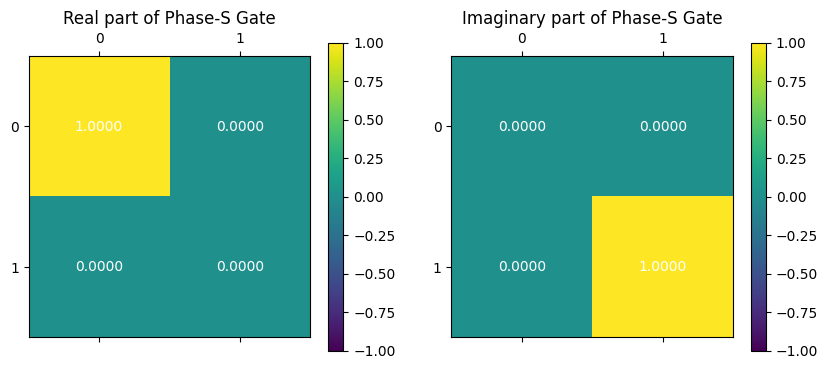

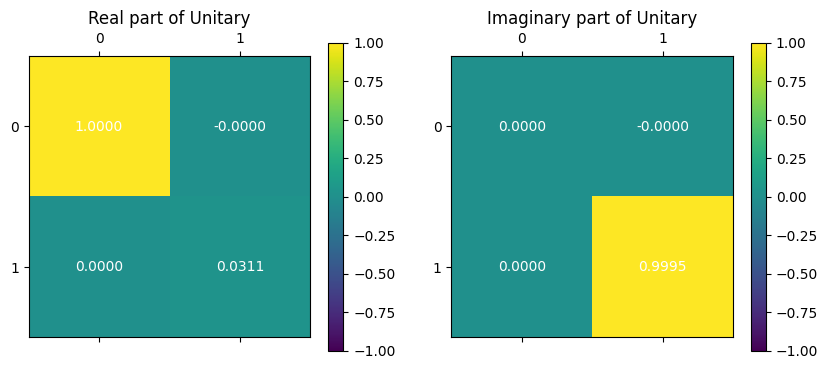

In [70]:
Phase_S = np.array([[1, 0], [0, 1j]])
Unitary_S = np.array(rotation_matrix_result_s)

def plot_matrix(matrix, title, vmin=0, vmax=1):
    fig, ax = plt.subplots(1, 2, figsize=(10, 4))
    
    # Real part
    cax1 = ax[0].matshow(matrix.real, cmap='viridis', vmin=vmin, vmax=vmax)
    fig.colorbar(cax1, ax=ax[0])
    ax[0].set_title(f'Real part of {title}')
    
    # Add values to the real part heatmap
    for (i, j), val in np.ndenumerate(matrix.real):
        ax[0].text(j, i, f'{val:.4f}', ha='center', va='center', color='white')
    
    # Imaginary part
    cax2 = ax[1].matshow(matrix.imag, cmap='viridis', vmin=vmin, vmax=vmax)
    fig.colorbar(cax2, ax=ax[1])
    ax[1].set_title(f'Imaginary part of {title}')
    
    # Add values to the imaginary part heatmap
    for (i, j), val in np.ndenumerate(matrix.imag):
        ax[1].text(j, i, f'{val:.4f}', ha='center', va='center', color='white')
     
    plt.show()

# Plot with the desired color map limits (0 to 1)
plot_matrix(Phase_S, 'Phase-S Gate', vmin=-1, vmax=1)
plot_matrix(Unitary_S, 'Unitary', vmin=-1, vmax=1)


Visual Representation 10k

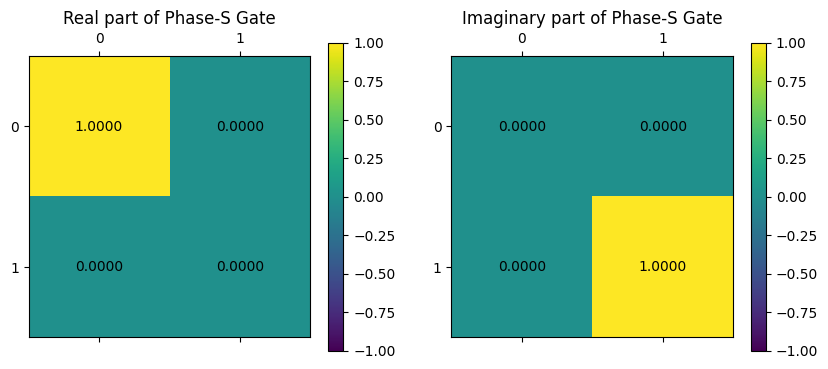

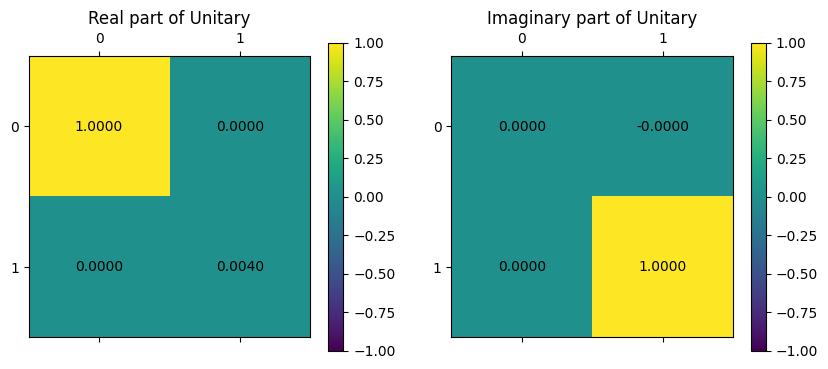

In [213]:
Phase_S = np.array([[1, 0], [0, 1j]])
Unitary_S1 = np.array(rotation_matrix_result_s1)

def plot_matrix(matrix, title, vmin=0, vmax=1):
    fig, ax = plt.subplots(1, 2, figsize=(10, 4))
    
    # Real part
    cax1 = ax[0].matshow(matrix.real, cmap='viridis', vmin=vmin, vmax=vmax)
    fig.colorbar(cax1, ax=ax[0])
    ax[0].set_title(f'Real part of {title}')
    
    # Add values to the real part heatmap
    for (i, j), val in np.ndenumerate(matrix.real):
        ax[0].text(j, i, f'{val:.4f}', ha='center', va='center', color='black')
    
    # Imaginary part
    cax2 = ax[1].matshow(matrix.imag, cmap='viridis', vmin=vmin, vmax=vmax)
    fig.colorbar(cax2, ax=ax[1])
    ax[1].set_title(f'Imaginary part of {title}')
    
    # Add values to the imaginary part heatmap
    for (i, j), val in np.ndenumerate(matrix.imag):
        ax[1].text(j, i, f'{val:.4f}', ha='center', va='center', color='black')
     
    plt.show()

# Plot with the desired color map limits (0 to 1)
plot_matrix(Phase_S, 'Phase-S Gate', vmin=-1, vmax=1)
plot_matrix(Unitary_S1, 'Unitary', vmin=-1, vmax=1)


Measurement Comparison 1000

In [74]:
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
import numpy as np

# Function to compute Mean Squared Error (MSE) between two matrices (measured and target)
def compute_overall_mse(measured_matrix, target_matrix):
    measured_matrix = np.array(measured_matrix)
    target_matrix = np.array(target_matrix)
    return np.mean((measured_matrix - target_matrix) ** 2)

# Evaluate and store the measured probabilities in a matrix
def evaluate_measurements_matrix(optimal_params, target_measurements):
    reference_circuits = create_reference_circuits()
    measured_probabilities_matrix = []

    for i, reference_circuit in enumerate(reference_circuits):
        # Combine reference and variational circuits with optimal parameters
        circuit = combine_circuits_s1(reference_circuit, variational_circuit, optimal_params)

        # Measure in Z, X, and Y bases
        prob_z = get_probabilities(measure_circuit(circuit.copy(), 'z'), 'z')
        prob_x = get_probabilities(measure_circuit(circuit.copy(), 'x'), 'x')
        prob_y = get_probabilities(measure_circuit(circuit.copy(), 'y'), 'y')

        # Extract probabilities for each basis
        prob_0 = prob_z.get('|0⟩', 0)
        prob_1 = prob_z.get('|1⟩', 0)
        prob_plus = prob_x.get('|+⟩', 0)
        prob_minus = prob_x.get('|-⟩', 0)
        prob_plus_i = prob_y.get('|+i⟩', 0)
        prob_minus_i = prob_y.get('|-i⟩', 0)

        # Combine all probabilities into a single list
        measured_probabilities = [prob_0, prob_1, prob_plus, prob_minus, prob_plus_i, prob_minus_i]

        # Append the list to the measured probabilities matrix
        measured_probabilities_matrix.append(measured_probabilities)

        # Print measured probabilities for clarity
        print(f"Measured Probabilities for reference state {i+1}: {measured_probabilities}")

    # Compute the overall MSE between the entire measured matrix and the target matrix
    overall_mse = compute_overall_mse(measured_probabilities_matrix, target_measurements)

    # Print the measured probability matrix and the overall MSE
    print("\nMeasured Probabilities Matrix:")
    for row in measured_probabilities_matrix:
        print(row)
    
    print(f"\nOverall Mean Squared Error (MSE): {overall_mse}")
    return measured_probabilities_matrix, overall_mse

# Now call the function with optimal_params and target_measurements

# Run the evaluation and get the measured matrix and MSE
measured_matrix, overall_mse = evaluate_measurements_matrix(optimal_params_s, target_measurements_S)



# Lets try to print the matrices

print("The Target Measurements \n")
target_matrix = np.array(target_measurements_S)
print(target_matrix)
print("\n")
print("The Prepared Measurements \n")
Prepared_measurements = np.array(measured_matrix)
np.set_printoptions(linewidth=200)
print(Prepared_measurements)

Measured Probabilities for reference state 1: [1.0, 0, 0.494, 0.506, 0.492, 0.508]
Measured Probabilities for reference state 2: [0, 1.0, 0.497, 0.503, 0.486, 0.514]
Measured Probabilities for reference state 3: [0.495, 0.505, 0.525, 0.475, 1.0, 0]
Measured Probabilities for reference state 4: [0.525, 0.475, 0.479, 0.521, 0, 1.0]
Measured Probabilities for reference state 5: [0.5, 0.5, 0, 1.0, 0.514, 0.486]
Measured Probabilities for reference state 6: [0.503, 0.497, 0.999, 0.001, 0.482, 0.518]

Measured Probabilities Matrix:
[1.0, 0, 0.494, 0.506, 0.492, 0.508]
[0, 1.0, 0.497, 0.503, 0.486, 0.514]
[0.495, 0.505, 0.525, 0.475, 1.0, 0]
[0.525, 0.475, 0.479, 0.521, 0, 1.0]
[0.5, 0.5, 0, 1.0, 0.514, 0.486]
[0.503, 0.497, 0.999, 0.001, 0.482, 0.518]

Overall Mean Squared Error (MSE): 0.00014172222222222247
The Target Measurements 

[[1.  0.  0.5 0.5 0.5 0.5]
 [0.  1.  0.5 0.5 0.5 0.5]
 [0.5 0.5 0.5 0.5 1.  0. ]
 [0.5 0.5 0.5 0.5 0.  1. ]
 [0.5 0.5 0.  1.  0.5 0.5]
 [0.5 0.5 1.  0.  0.5 0.5

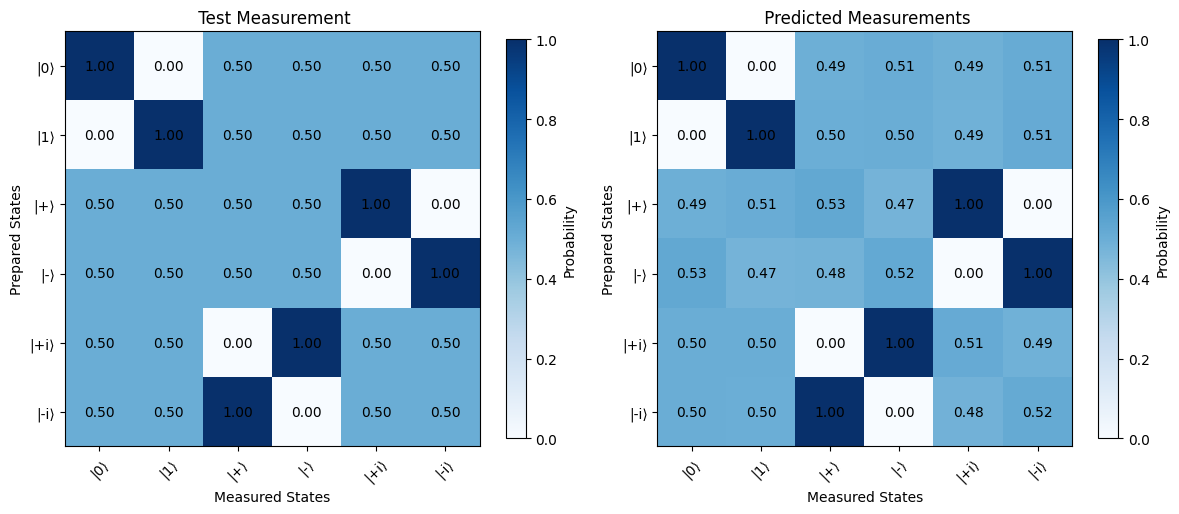

In [75]:
import numpy as np
import matplotlib.pyplot as plt

# Matrices 
Tomographic_measurements = np.array((target_matrix))
Experimental_measurements = np.array((Prepared_measurements))

# Define the state labels
state_labels = ['|0⟩', '|1⟩', '|+⟩', '|-⟩', '|+i⟩', '|-i⟩']

# Create a figure with two subplots (1 row, 2 columns)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot the Target Measurements heatmap on the left
heatmap1 = ax1.imshow(Tomographic_measurements, cmap='Blues', interpolation='nearest')
ax1.set_title(' Test Measurement')
ax1.set_xticks(np.arange(len(state_labels)))
ax1.set_yticks(np.arange(len(state_labels)))
ax1.set_xticklabels(state_labels, rotation=45)
ax1.set_yticklabels(state_labels)
ax1.set_xlabel('Measured States')
ax1.set_ylabel('Prepared States')

# Add text annotations to the target matrix
for i in range(Tomographic_measurements.shape[0]):
    for j in range(Tomographic_measurements.shape[1]):
        value = Tomographic_measurements[i, j]
        ax1.text(j, i, f'{value:.2f}', ha='center', va='center', color='black')

# Add color bar for the target heatmap
fig.colorbar(heatmap1, ax=ax1, label='Probability',shrink= 0.7)

# Plot the Prepared Measurements heatmap on the right
heatmap2 = ax2.imshow(Experimental_measurements, cmap='Blues', interpolation='nearest')
ax2.set_title(' Predicted Measurements')
ax2.set_xticks(np.arange(len(state_labels)))
ax2.set_yticks(np.arange(len(state_labels)))
ax2.set_xticklabels(state_labels, rotation=45)
ax2.set_yticklabels(state_labels)
ax2.set_xlabel('Measured States')
ax2.set_ylabel('Prepared States')

# Add text annotations to the prepared matrix
for i in range(Experimental_measurements.shape[0]):
    for j in range(Experimental_measurements.shape[1]):
        value = Experimental_measurements[i, j]
        ax2.text(j, i, f'{value:.2f}', ha='center', va='center', color='black')

# Add color bar for the prepared heatmap
fig.colorbar(heatmap2, ax=ax2, label='Probability',shrink= 0.7)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

Measurement Comparison 10k

In [77]:
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
import numpy as np

# Function to compute Mean Squared Error (MSE) between two matrices (measured and target)
def compute_overall_mse(measured_matrix, target_matrix):
    measured_matrix = np.array(measured_matrix)
    target_matrix = np.array(target_matrix)
    return np.mean((measured_matrix - target_matrix) ** 2)

# Evaluate and store the measured probabilities in a matrix
def evaluate_measurements_matrix(optimal_params, target_measurements):
    reference_circuits = create_reference_circuits()
    measured_probabilities_matrix = []

    for i, reference_circuit in enumerate(reference_circuits):
        # Combine reference and variational circuits with optimal parameters
        circuit = combine_circuits_s1(reference_circuit, variational_circuit, optimal_params)

        # Measure in Z, X, and Y bases
        prob_z = get_probabilities(measure_circuit(circuit.copy(), 'z'), 'z')
        prob_x = get_probabilities(measure_circuit(circuit.copy(), 'x'), 'x')
        prob_y = get_probabilities(measure_circuit(circuit.copy(), 'y'), 'y')

        # Extract probabilities for each basis
        prob_0 = prob_z.get('|0⟩', 0)
        prob_1 = prob_z.get('|1⟩', 0)
        prob_plus = prob_x.get('|+⟩', 0)
        prob_minus = prob_x.get('|-⟩', 0)
        prob_plus_i = prob_y.get('|+i⟩', 0)
        prob_minus_i = prob_y.get('|-i⟩', 0)

        # Combine all probabilities into a single list
        measured_probabilities = [prob_0, prob_1, prob_plus, prob_minus, prob_plus_i, prob_minus_i]

        # Append the list to the measured probabilities matrix
        measured_probabilities_matrix.append(measured_probabilities)

        # Print measured probabilities for clarity
        print(f"Measured Probabilities for reference state {i+1}: {measured_probabilities}")

    # Compute the overall MSE between the entire measured matrix and the target matrix
    overall_mse = compute_overall_mse(measured_probabilities_matrix, target_measurements)

    # Print the measured probability matrix and the overall MSE
    print("\nMeasured Probabilities Matrix:")
    for row in measured_probabilities_matrix:
        print(row)
    
    print(f"\nOverall Mean Squared Error (MSE): {overall_mse}")
    return measured_probabilities_matrix, overall_mse

# Now call the function with optimal_params and target_measurements

# Run the evaluation and get the measured matrix and MSE
measured_matrix, overall_mse = evaluate_measurements_matrix(optimal_params_s1, target_measurements_S1)



# Lets try to print the matrices

print("The Target Measurements \n")
target_matrix = np.array(target_measurements_S1)
print(target_matrix)
print("\n")
print("The Prepared Measurements \n")
Prepared_measurements = np.array(measured_matrix)
np.set_printoptions(linewidth=200)
print(Prepared_measurements)

Measured Probabilities for reference state 1: [1.0, 0, 0.52, 0.48, 0.51, 0.49]
Measured Probabilities for reference state 2: [0, 1.0, 0.514, 0.486, 0.479, 0.521]
Measured Probabilities for reference state 3: [0.506, 0.494, 0.485, 0.515, 1.0, 0]
Measured Probabilities for reference state 4: [0.487, 0.513, 0.526, 0.474, 0, 1.0]
Measured Probabilities for reference state 5: [0.521, 0.479, 0, 1.0, 0.506, 0.494]
Measured Probabilities for reference state 6: [0.517, 0.483, 1.0, 0, 0.503, 0.497]

Measured Probabilities Matrix:
[1.0, 0, 0.52, 0.48, 0.51, 0.49]
[0, 1.0, 0.514, 0.486, 0.479, 0.521]
[0.506, 0.494, 0.485, 0.515, 1.0, 0]
[0.487, 0.513, 0.526, 0.474, 0, 1.0]
[0.521, 0.479, 0, 1.0, 0.506, 0.494]
[0.517, 0.483, 1.0, 0, 0.503, 0.497]

Overall Mean Squared Error (MSE): 0.00016766666666666698
The Target Measurements 

[[1.  0.  0.5 0.5 0.5 0.5]
 [0.  1.  0.5 0.5 0.5 0.5]
 [0.5 0.5 0.5 0.5 1.  0. ]
 [0.5 0.5 0.5 0.5 0.  1. ]
 [0.5 0.5 0.  1.  0.5 0.5]
 [0.5 0.5 1.  0.  0.5 0.5]]


The Pre

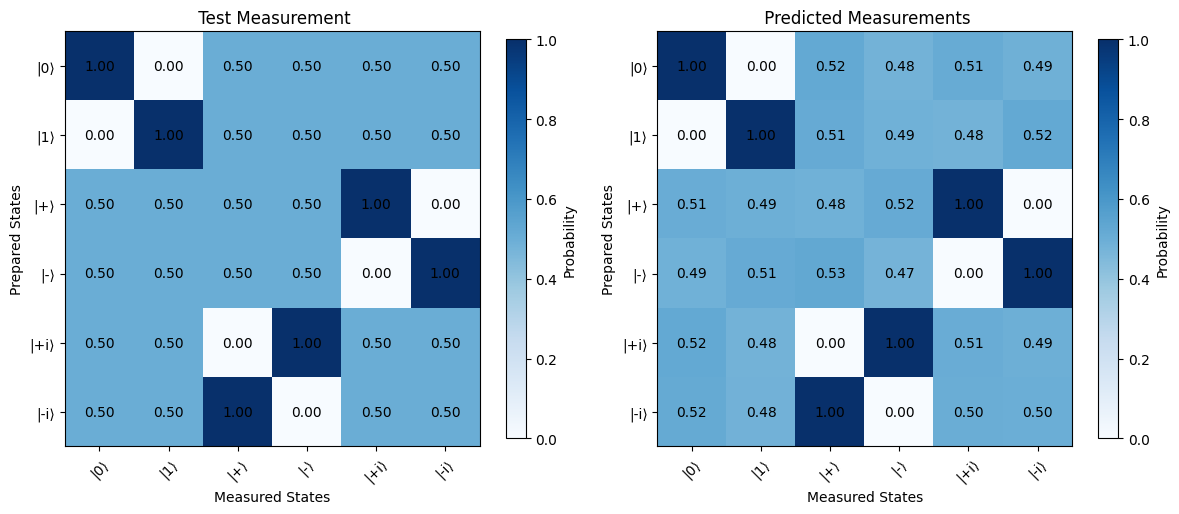

In [78]:
import numpy as np
import matplotlib.pyplot as plt

# Matrices 
Tomographic_measurements = np.array((target_matrix))
Experimental_measurements = np.array((Prepared_measurements))

# Define the state labels
state_labels = ['|0⟩', '|1⟩', '|+⟩', '|-⟩', '|+i⟩', '|-i⟩']

# Create a figure with two subplots (1 row, 2 columns)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot the Target Measurements heatmap on the left
heatmap1 = ax1.imshow(Tomographic_measurements, cmap='Blues', interpolation='nearest')
ax1.set_title(' Test Measurement')
ax1.set_xticks(np.arange(len(state_labels)))
ax1.set_yticks(np.arange(len(state_labels)))
ax1.set_xticklabels(state_labels, rotation=45)
ax1.set_yticklabels(state_labels)
ax1.set_xlabel('Measured States')
ax1.set_ylabel('Prepared States')

# Add text annotations to the target matrix
for i in range(Tomographic_measurements.shape[0]):
    for j in range(Tomographic_measurements.shape[1]):
        value = Tomographic_measurements[i, j]
        ax1.text(j, i, f'{value:.2f}', ha='center', va='center', color='black')

# Add color bar for the target heatmap
fig.colorbar(heatmap1, ax=ax1, label='Probability',shrink= 0.7)

# Plot the Prepared Measurements heatmap on the right
heatmap2 = ax2.imshow(Experimental_measurements, cmap='Blues', interpolation='nearest')
ax2.set_title(' Predicted Measurements')
ax2.set_xticks(np.arange(len(state_labels)))
ax2.set_yticks(np.arange(len(state_labels)))
ax2.set_xticklabels(state_labels, rotation=45)
ax2.set_yticklabels(state_labels)
ax2.set_xlabel('Measured States')
ax2.set_ylabel('Prepared States')

# Add text annotations to the prepared matrix
for i in range(Experimental_measurements.shape[0]):
    for j in range(Experimental_measurements.shape[1]):
        value = Experimental_measurements[i, j]
        ax2.text(j, i, f'{value:.2f}', ha='center', va='center', color='black')

# Add color bar for the prepared heatmap
fig.colorbar(heatmap2, ax=ax2, label='Probability',shrink= 0.7)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

# Fidelity Check 

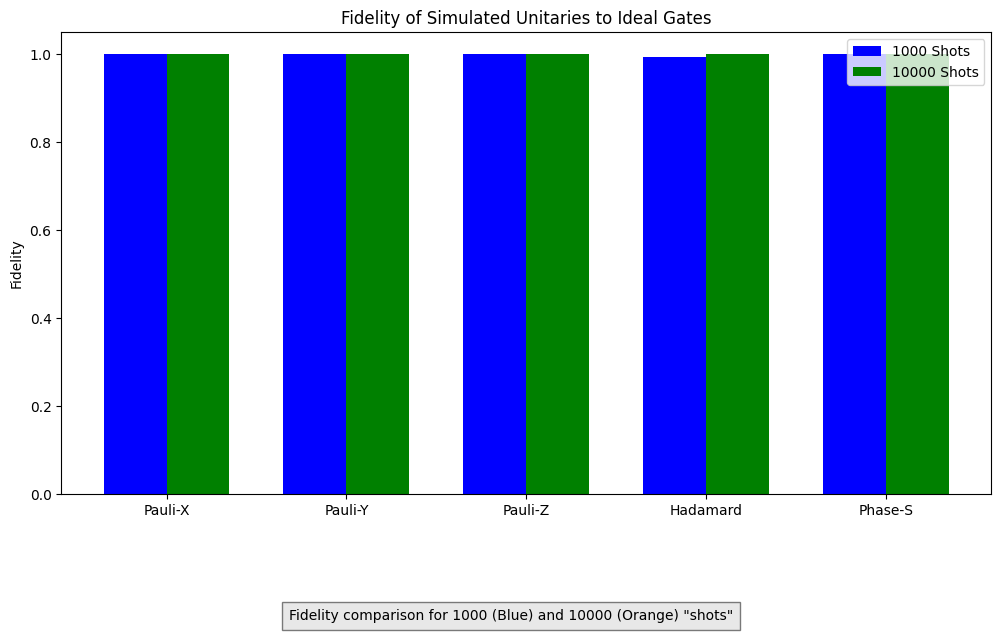

In [81]:
import numpy as np
import matplotlib.pyplot as plt

# Define the ideal unitaries
sigma_X = np.array([[0, 1],[1, 0]])
sigma_Y = np.array([[0, -1j], [1j, 0]])
sigma_Z = np.array([[1, 0], [0, -1]])
hadamard = 1 / np.sqrt(2) * np.array([[1, 1], [1, -1]])
phase_S = np.array([[1, 0], [0, np.exp(1j * np.pi / 2)]])

# Define a function to calculate fidelity
def calculate_fidelity(U, V):
    """
    Calculates the fidelity between two unitary operators U and V.
    """
    UdaggerV = np.dot(U.conj().T, V)
    fidelity = (np.abs(np.trace(UdaggerV))**2) / 4
    return fidelity

# Dictionary to store unitaries and their calculated versions
unitaries = {
    'Pauli-X': [sigma_X, rotation_matrix_result_x, rotation_matrix_result_x1],
    'Pauli-Y': [sigma_Y, rotation_matrix_result_y, rotation_matrix_result_y1],
    'Pauli-Z': [sigma_Z, rotation_matrix_result_z, rotation_matrix_result_z1],
    'Hadamard': [hadamard, rotation_matrix_result_h, rotation_matrix_result_h1],
    'Phase-S': [phase_S, rotation_matrix_result_s, rotation_matrix_result_s1]
}

# Calculating fidelities
fidelities = {}
for name, (ideal, result_1000, result_10000) in unitaries.items():
    fidelity_1000 = calculate_fidelity(result_1000, ideal)
    fidelity_10000 = calculate_fidelity(result_10000, ideal)
    fidelities[name] = [fidelity_1000, fidelity_10000]

# Plotting results
fig, ax = plt.subplots(figsize=(12, 6))
x = np.arange(len(fidelities))  # label locations
width = 0.35  # the width of the bars

colors = ['blue', 'green']  # Colors for the bars
for i, (name, fidelity_list) in enumerate(fidelities.items()):
    ax.bar(x[i] - width/2, fidelity_list[0], width, label='1000 Shots' if i == 0 else "", color=colors[0])
    ax.bar(x[i] + width/2, fidelity_list[1], width, label='10000 Shots' if i == 0 else "", color=colors[1])

ax.set_ylabel('Fidelity')
ax.set_title('Fidelity of Simulated Unitaries to Ideal Gates')
ax.set_xticks(x)
ax.set_xticklabels(fidelities.keys())
ax.legend()

# Add key below x-axis
plt.figtext(0.5, -0.1, 'Fidelity comparison for 1000 (Blue) and 10000 (Orange) "shots"', ha="center", fontsize=10, bbox={"facecolor":"lightgrey", "alpha":0.5, "pad":5})

plt.savefig('fidelity_of_simulated_gates_2.png')
plt.show()
